In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cm

import astropy.coordinates as coord
from astropy.table import Table, vstack
from astropy.io import fits
import astropy.units as u
from astropy.coordinates import Angle

import pickle
import pandas as pd

coord.galactocentric_frame_defaults.set('v4.0')
import galstreams
import gala.coordinates as gc
import gala.potential as gp
import gala.dynamics as gd
from gala.units import galactic
from gala.dynamics.nbody import DirectNBody
import gala.integrate as gi

%matplotlib inline
%config InlineBackend.figure_format='retina'

from helpers.SimulationAnalysis import SimulationAnalysis, iterTrees
from helpers.SimulationAnalysis import readHlist

In [2]:
gsr = coord.Galactocentric()
mwsts = galstreams.MWStreams(verbose=False, implement_Off=False)

Initializing galstreams library from master_log... 


In [3]:
#Path to simulation data
path_to_data = ''

#Halo properties to load; see Section 2.4 of https://arxiv.org/abs/2008.08591 for info on Rockstar fields 
fields = ['scale','id', 'upid', 'pid', 'mvir', 'mpeak', 'rvir', 'RVmax', 'rs', 'vmax', 'vpeak', 'x', 'y', 'z', 'vx', 'vy', 'vz',
          'M200c', 'depth_first_id','scale_of_last_MM']

#Load z = 0 halo list for Halo416_16K
halos_z0 = readHlist(path_to_data+'hlist_1.00000.list',fields=fields) #0.97483 
MW_analog = halos_z0[np.argmax(halos_z0['mvir'])]

subhalos_z0 = halos_z0[halos_z0['upid']==MW_analog['id']]
LMC_analog = subhalos_z0[np.argmax(subhalos_z0['mvir'])]


#Reading in data from dm particles
t = Table.read('snapshot_now.fits')

# ind_lmc = subhalos_z0['pid']==LMC_analog['id']
ind_lmc = np.argmax(subhalos_z0['mvir'])



In [4]:
h = 0.7
ts = Table(subhalos_z0)
for comp in ['x', 'y', 'z']:
    ts[comp] = ((ts[comp] - MW_analog[comp])*u.Mpc/h).to(u.kpc)
for comp in ['vx', 'vy', 'vz']:
    ts[comp] = (ts[comp] - MW_analog[comp])*u.km/u.s

In [5]:
ind_massive = (ts['mvir'] > 10**7)
len(ts['mvir'][ind_massive])

1072

In [6]:
c = coord.Galactocentric(x=ts['x'][ind_massive], y=ts['y'][ind_massive], z=ts['z'][ind_massive],
                         v_x=ts['vx'][ind_massive], v_y=ts['vy'][ind_massive], v_z=ts['vz'][ind_massive])
ceq = c.transform_to(coord.ICRS()) 

ceq_lmc = coord.ICRS(ra=78.76*u.deg, dec=-69.19*u.deg, distance=(10**(0.2*18.50+1)*u.pc).to(u.kpc), 
                     radial_velocity=262.2*u.km/u.s, pm_ra_cosdec=1.91*u.mas/u.yr, pm_dec=0.229*u.mas/u.yr)
c_lmc = ceq_lmc.transform_to(coord.Galactocentric()) #galactocentric coordinates

In [7]:
vsim = np.array([c.x.value[ind_lmc], c.y.value[ind_lmc], c.z.value[ind_lmc]]) #this is the u vector 
vsim = vsim / np.linalg.norm(vsim)

vtrue = np.array([c_lmc.x.value, c_lmc.y.value, c_lmc.z.value]) #this is the v vector 
vtrue = vtrue / np.linalg.norm(vtrue)

vpole = np.cross(vsim, vtrue)
vpole = vpole / np.linalg.norm(vpole)

In [8]:
theta = np.arccos(np.dot(vsim,vtrue)/(np.linalg.norm(vsim)*np.linalg.norm(vtrue)))

#ROTATION MATRIX
R = np.array([[np.cos(theta) + vpole[0]**2*(1-np.cos(theta)),
              vpole[0]*vpole[1]*(1-np.cos(theta)) - vpole[2]*np.sin(theta),
              vpole[0]*vpole[2]*(1-np.cos(theta)) + vpole[1]*np.sin(theta)],
             [vpole[1]*vpole[0]*(1-np.cos(theta)) + vpole[2]*np.sin(theta),
              np.cos(theta) + vpole[1]**2*(1-np.cos(theta)),
              vpole[1]*vpole[2]*(1-np.cos(theta)) - vpole[0]*np.sin(theta)],
             [vpole[2]*vpole[0]*(1-np.cos(theta)) - vpole[1]*np.sin(theta),
              vpole[2]*vpole[1]*(1-np.cos(theta)) + vpole[0]*np.sin(theta),
              np.cos(theta) + vpole[2]**2*(1-np.cos(theta))]])

In [9]:
trot = Table(subhalos_z0[ind_massive])
N = len(trot)
trot['x'] = np.zeros(N)#*u.kpc
trot['y'] = np.zeros(N)#*u.kpc
trot['z'] = np.zeros(N)#*u.kpc

for i in range(N):
    temp_vec = np.array([ts['x'][ind_massive][i], ts['y'][ind_massive][i], ts['z'][ind_massive][i]])
    rot_vec = np.matmul(R, temp_vec)
    
    trot['x'][i] = rot_vec[0]#*u.kpc
    trot['y'][i] = rot_vec[1]#*u.kpc
    trot['z'][i] = rot_vec[2]#*u.kpc

In [10]:
#This is the radius from the center at which the maximum velocity occurs
trot['rs'] = (trot['RVmax'])/2.163

In [11]:
subhalo_dist=np.sqrt(trot['x']**2+trot['y']**2+trot['z']**2)

In [12]:
ham = gp.Hamiltonian(gp.NFWPotential(m=MW_analog['mvir']/h*u.Msun, 
                                     r_s=(MW_analog['rs'])/h*u.kpc, units=galactic))


In [13]:
#Getting the Orbits of Subhalos
dt = 1*u.Myr
subh_orbits = []
Nstep_long=3000
for subh in range(len(ts['x'][ind_massive])): 
    #This calculates the position of the subhalos at a given time
    c_subh = coord.Galactocentric(x=ts['x'][ind_massive][subh]*u.kpc, y=ts['y'][ind_massive][subh]*u.kpc, 
                                  z=ts['z'][ind_massive][subh]*u.kpc,
                                  v_x=ts['vx'][ind_massive][subh]*u.km/u.s, 
                                  v_y=ts['vy'][ind_massive][subh]*u.km/u.s,
                                  v_z=ts['vz'][ind_massive][subh]*u.km/u.s)
    w0_subh = gd.PhaseSpacePosition(c_subh.cartesian)
    subh_orbits += [ham.integrate_orbit(w0_subh, dt=-dt, n_steps=Nstep_long)]

In [14]:
#Rotating Subhalo Orbits 
N = len(subh_orbits[0].pos.x)

rot_orbits=np.zeros((len(ts['x'][ind_massive]), len(subh_orbits[1].pos.x), 3))

for j, subh in enumerate(subh_orbits):
    for i in range(N):
        temp_vec = np.array([subh.pos.x[i].value, subh.pos.y[i].value, subh.pos.z[i].value])
        rot_vec = np.matmul(R, temp_vec)

        rot_orbits[j][i][0] = rot_vec[0]
        rot_orbits[j][i][1] = rot_vec[1]
        rot_orbits[j][i][2] = rot_vec[2]

In [15]:
#Rotating Subhalo Velocity Orbits 
N = len(subh_orbits[0].vel.d_x)

rot_orbits_vel=np.zeros((len(ts['vx'][ind_massive]), len(subh_orbits[1].vel.d_x), 3))

for j, subh in enumerate(subh_orbits):
    for i in range(N):
        temp_vec_vel = np.array([subh.vel.d_x.to(u.km/u.s)[i].value, 
                                 subh.vel.d_y.to(u.km/u.s)[i].value, 
                                 subh.vel.d_z.to(u.km/u.s)[i].value])
        rot_vec_vel = np.matmul(R, temp_vec_vel)

        rot_orbits_vel[j][i][0] = rot_vec_vel[0]
        rot_orbits_vel[j][i][1] = rot_vec_vel[1]
        rot_orbits_vel[j][i][2] = rot_vec_vel[2]

In [16]:
r_peri = dict(LMS_1=10.8, Gjoll=8.5, Leiptr=12.3, Hrid=1.1, Pal5=6.9, Orphan=15.6, 
             Gaia_1=8.2, Fimbulthul=2.4, Ylgr=11.5, Fjorm=9.1, Kshir=13.4, Cetus=14.7,
             Svol=5.9, Gunnthra=4.2, Slidr=8.7, M92=3.0, NGC_6397=3.4, NGC_3201=8.5,
             Ophiuchus=3.9, Atlas=11.7, C_7=3.5, C_3=5.7, Palca=10.8, Sylgr=8.7,
             Gaia_6=6.0, Gaia_9=8.7, Gaia_10=4.3, Gaia_12=18.5, Indus=12.6, Jhelum=8.7,
             Phoenix=11.7, NGC5466=4.8, M5=3.4, C_20=20.8, NGC7089=2.9, C_19=9.3,
             Elqui=12.1, Chenab=22.0, AliqaUma=11.6, Phlegethon=5.5, GD_1=14.1)


r_apo = dict(LMS_1=20.6, Gjoll=27.4, Leiptr=45.1, Hrid=22.0, Pal5=15.8, Orphan=41.2, 
             Gaia_1=67.6, Fimbulthul=7.2, Ylgr=20.7, Fjorm=29.1, Kshir=16.0, Cetus=35.9,
             Svol=10.0, Gunnthra=7.2, Slidr=32.3, M92=10.7, NGC_6397=6.4, NGC_3201=30.5,
             Ophiuchus=14.2, Atlas=32.4, C_7=21.0, C_3=10.0, Palca=16.5, Sylgr=24.6,
             Gaia_6=9.5, Gaia_9=20.8, Gaia_10=37.7, Gaia_12=194.3, Indus=18.9, Jhelum=24.5,
             Phoenix=18.1, NGC5466=33.7, M5=24.8, C_20=58.5, NGC7089=14.7, C_19=21.6,
             Elqui=54.0, Chenab=81.0, AliqaUma=31.9, Phlegethon=22.1, GD_1=23.0)



In [16]:
#Creating a data frame with Malhans info on Streams
data = [['Gjoll', 82.1, -13.95, 3.26, 23.58, -23.7, 78.73], 
        ['Leiptr', 89.11, -28.37, 7.39, 10.59, -9.9, 194.22],
        ['Hrid', 280.51, 33.3, 2.75, -5.88, 20.08, -238.77],
        ['Pal5', 229.65, 0.26, 20.16, -2.75, -2.68, -57.03],
        ['Gaia_1', 190.96, -9.16, 5.57, -14.39, -19.72, 214.91], #Gaia_1
        ['Ylgr', 173.82, -22.31, 9.72, -0.44, -7.65, 317.86], 
        ['Fjorm', 251.89, 65.38, 6.42, 3.92, 3.1, -25.37],
        ['Kshir', 205.88, 67.25, 9.57, -7.67, -3.92, -249.88],
        ['Gunnthra', 284.22, -73.49, 2.83, -15.83, -24.04, 132.26],
        ['Slidr', 160.05, 10.22, 2.99, -24.6, -6.65, 87.98],
        ['M92', 259.89, 43.08, 8.94, -5.15, -0.63, -140.66],
        ['NGC_3201', 152.46, -46.32, 4.99, 8.87, -2.22, 489.63],
        ['Atlas', 25.04, -29.81, 19.93, 0.04, -0.89, -85.65],
        ['C_7', 287.15, -50.17, 6.77, -13.79, -12.38, 55.05],
        ['Palca', 36.57, -36.15, 12.31, 0.9, -0.23, 106.32],
        ['Sylgr', 179.68, -2.44, 3.77, -13.98, -12.9, -184.8],
        ['Gaia_9', 233.27, 60.42, 4.68, -12.49, 6.37, -359.86],
        ['Gaia_10', 161.47, 15.17, 13.32, -4.14, -3.15, 289.62],
        ['Gaia_12', 41.05, 16.45, 15.71, 5.84, -5.66, -303.83],
        ['Indus', 340.12, -60.58, 14.96, 3.59, -4.89, -49.15],
        ['Jhelum', 351.95, -51.74, 11.39, 7.23, -4.37, -1.29],
        ['Phoenix', 23.96, -50.01, 16.8, 2.72, -0.07, 45.92],
        ['NGC5466', 214.41, 26.84, 14.09, -5.64, -0.72, 95.04],
        ['M5', 206.96, 13.5, 7.44, 3.5, -8.76, -42.97],
        ['C_20', 359.81, 8.63, 18.11, -0.58, 1.44, -116.87],
        ['C_19', 355.28, 28.82, 18.04, 1.25, -2.74, -193.48],
        ['Elqui', 19.77, -42.36, 51.41, 0.33, -0.49, 15.86],
        ['AliqaUma', 34.08, -33.97, 21.98, 0.24, -0.79, -42.33],
        ['Phlegethon', 319.89, -32.07, 3.29, -3.97, -37.66, 15.9],
        ['GD_1', 160.02, 45.9, 8.06, -6.75, -10.88, -101.83]
       ]
  
# Create the pandas DataFrame
streams = pd.DataFrame(data, columns=['Stream', 'ra', 'dec', 'distance', 'pm_ra_cosdec', 'pm_dec', 'radial_velocity'])
  

# print dataframe.
streams


Stream      ra    dec  distance  pm_ra_cosdec  pm_dec  radial_velocity
0        Gjoll   82.10 -13.95      3.26         23.58  -23.70            78.73
1       Leiptr   89.11 -28.37      7.39         10.59   -9.90           194.22
2         Hrid  280.51  33.30      2.75         -5.88   20.08          -238.77
3         Pal5  229.65   0.26     20.16         -2.75   -2.68           -57.03
4       Gaia_1  190.96  -9.16      5.57        -14.39  -19.72           214.91
5         Ylgr  173.82 -22.31      9.72         -0.44   -7.65           317.86
6        Fjorm  251.89  65.38      6.42          3.92    3.10           -25.37
7        Kshir  205.88  67.25      9.57         -7.67   -3.92          -249.88
8     Gunnthra  284.22 -73.49      2.83        -15.83  -24.04           132.26
9        Slidr  160.05  10.22      2.99        -24.60   -6.65            87.98
10         M92  259.89  43.08      8.94         -5.15   -0.63          -140.66
11    NGC_3201  152.46 -46.32      4.99          8.87   -2.22           489.63
12       Atlas   25.04 -29.81     19.93          0.04   -0.89           -85.65
13         C_7  287.15 -50.17      6.77        -13.79  -12.38            55.05
14       Palca   36.57 -36.15     12.31          0.90   -0.23           106.32
15       Sylgr  179.68  -2.44      3.77        -13.98  -12.90          -184.80
16      Gaia_9  233.27  60.42      4.68        -12.49    6.37          -359.86
17     Gaia_10  161.47  15.17     13.32         -4.14   -3.15           289.62
18     Gaia_12   41.05  16.45     15.71          5.84   -5.66          -303.83
19       Indus  340.12 -60.58     14.96          3.59   -4.89           -49.15
20      Jhelum  351.95 -51.74     11.39          7.23   -4.37            -1.29
21     Phoenix   23.96 -50.01     16.80          2.72   -0.07            45.92
22     NGC5466  214.41  26.84     14.09         -5.64   -0.72            95.04
23          M5  206.96  13.50      7.44          3.50   -8.76           -42.97
24        C_20  359.81   8.63     18.11         -0.58    1.44          -116.87
25        C_19  355.28  28.82     18.04          1.25   -2.74          -193.48
26       Elqui   19.77 -42.36     51.41          0.33   -0.49            15.86
27    AliqaUma   34.08 -33.97     21.98          0.24   -0.79           -42.33
28  Phlegethon  319.89 -32.07      3.29         -3.97  -37.66            15.90
29        GD_1  160.02  45.90      8.06         -6.75  -10.88          -101.83

In [28]:
#Use this to figure out names that go from Malhan to Mateau
names = dict(Gjoll='NGC3201-P21',Leiptr='Leiptr-I21',
Hrid='Hrid-I21', Pal5='Pal5-PW19', 
Gaia_1='Gaia-1-I21', Ylgr='Ylgr-I21', 
Fjorm='M68-P19', Kshir='Kshir-I21', 
Gunnthra='Gunnthra-I21', Slidr='Slidr-I21', 
M92='M92-I21', NGC_3201='NGC3201-P21',
Atlas='AAU-ATLAS-L21', C_7='C-7-I21', 
Palca='Palca-S18', Sylgr='Sylgr-I21',
Gaia_9='Gaia-9-I21', Gaia_10='Gaia-10-I21', 
Gaia_12='Gaia-12-I21', Indus='Indus-S19', 
Jhelum='Jhelum-a-B19', Phoenix='Phoenix-S19',
NGC5466='NGC5466-G06', M5='M5-G19', 
C_20='None', C_19='C-19-I21',
Elqui='Elqui-S19', AliqaUma='AAU-AliqaUma-L21', 
Phlegethon='Phlegethon-I21', GD_1='GD-1-I21')

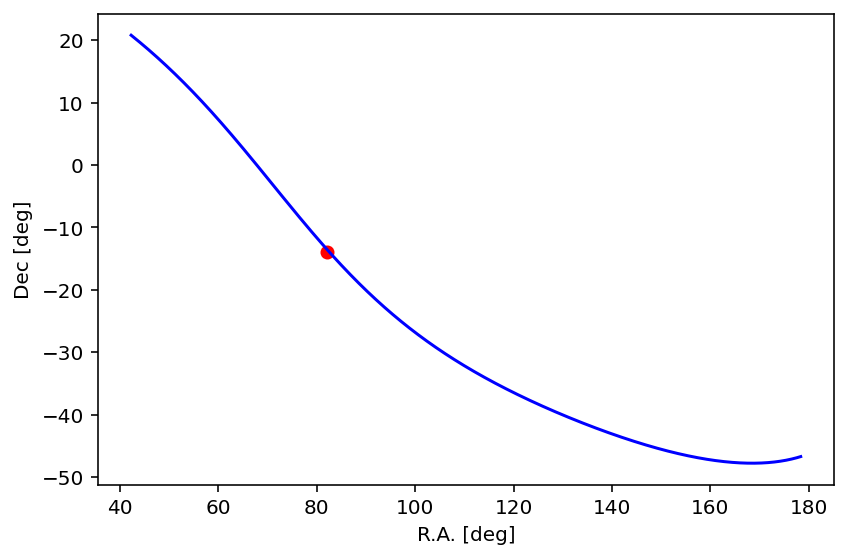

In [29]:
# define Galactocentric reference frame
coord.galactocentric_frame_defaults.set('v4.0')
gc_frame = coord.Galactocentric()
#define hamiltonian
ham = gp.Hamiltonian(gp.NFWPotential(m=MW_analog['mvir']/h*u.Msun, 
                                     r_s=(MW_analog['rs'])/h*u.kpc, units=galactic))
#Gjoll
c = coord.SkyCoord(ra=streams.iloc[0][1]*u.deg, dec=streams.iloc[0][2]*u.deg, distance=streams.iloc[0][3]*u.kpc, 
                   pm_ra_cosdec=streams.iloc[0][4]*u.mas/u.yr,pm_dec=streams.iloc[0][5]*u.mas/u.yr, 
                   radial_velocity=streams.iloc[0][6]*u.km/u.s, frame='icrs')
w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)



name=list(names.values())[0] #This one corresponds to Gjoll
plt.figure()
plt.plot(c.ra.wrap_at(180*u.deg), c.dec, 'ro')
plt.plot(mwsts[name].track.ra.wrap_at(180*u.deg), mwsts[name].track.dec, 'b-')
plt.xlabel('R.A. [deg]')
plt.ylabel('Dec [deg]')
#plt.gca().set_aspect('equal')
plt.tight_layout()


<ipython-input-31-c3fd38d0e5bb>:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


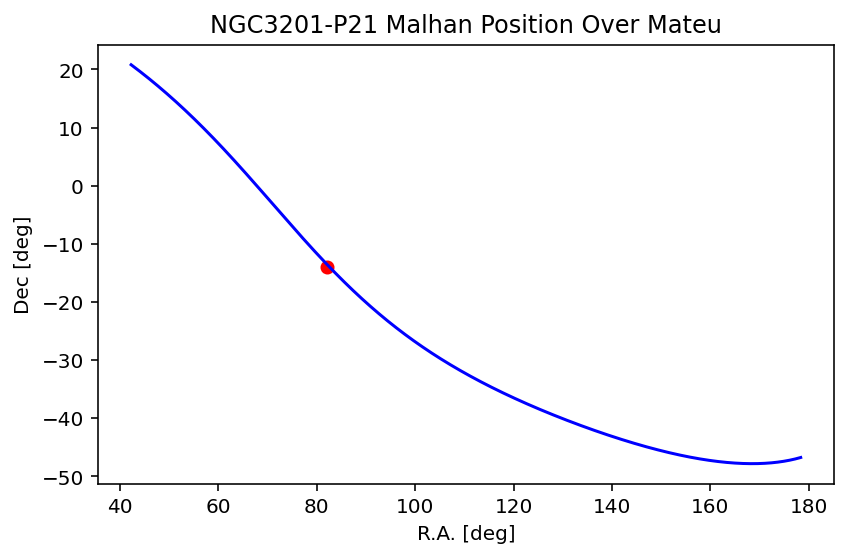

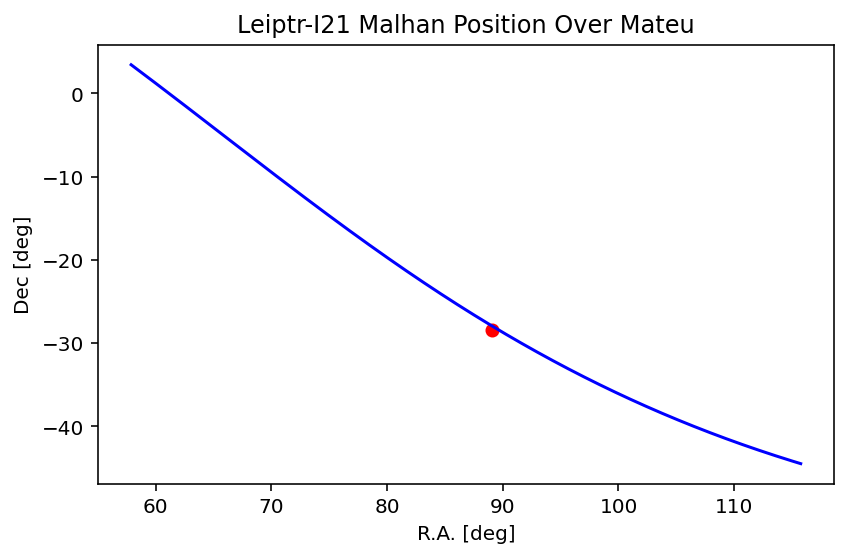

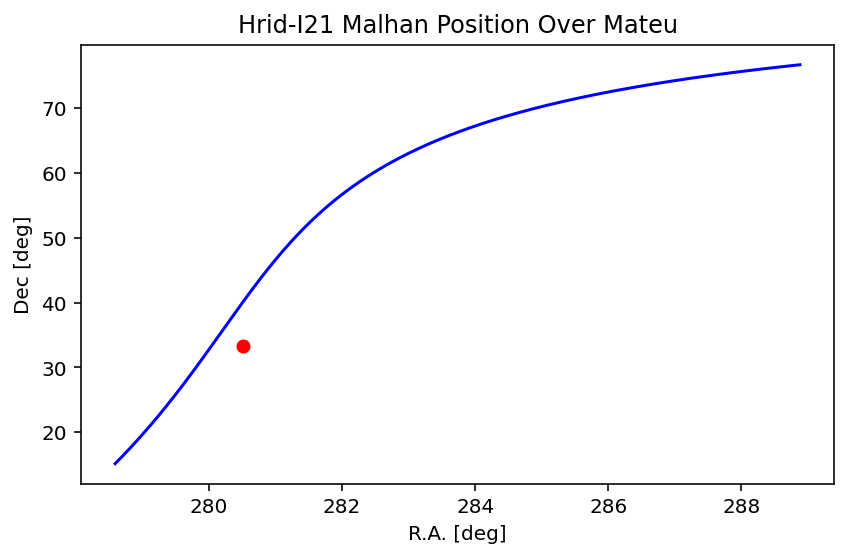

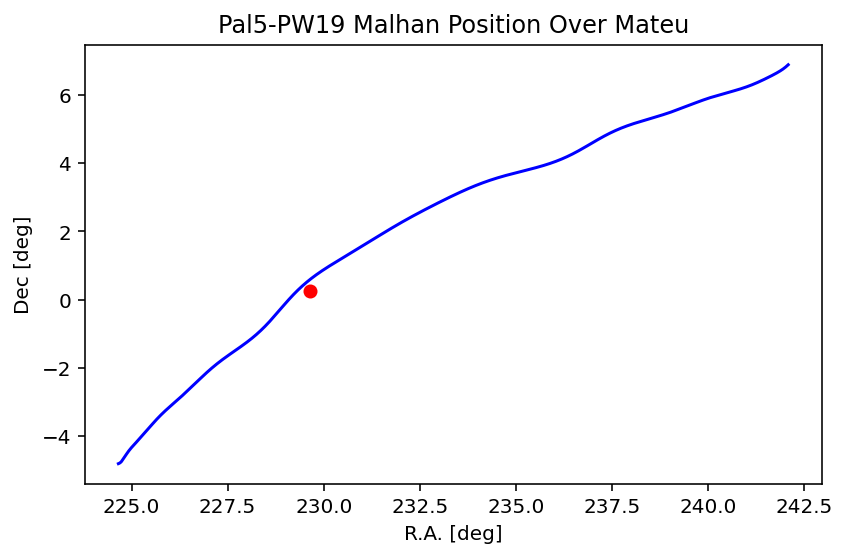

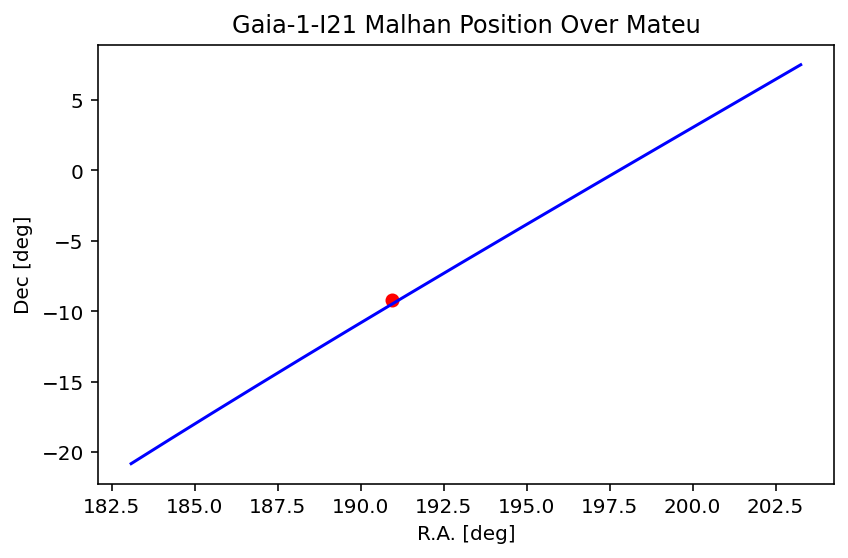

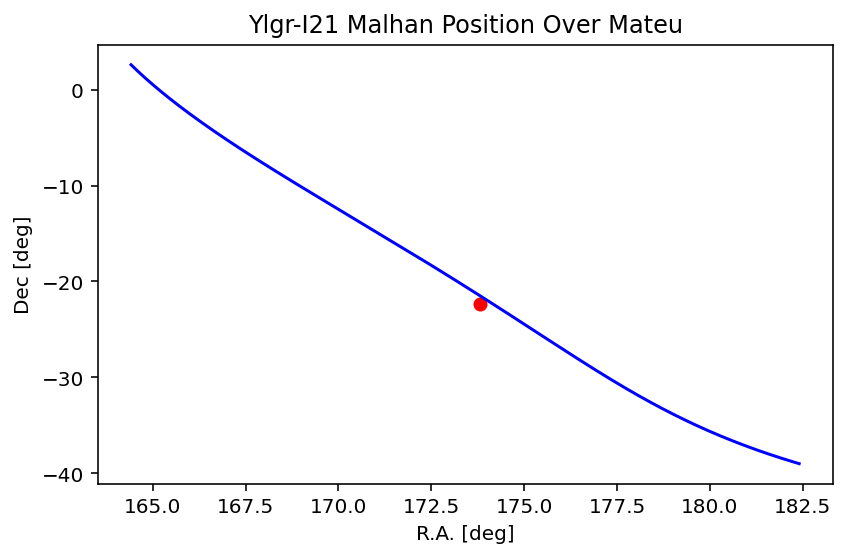

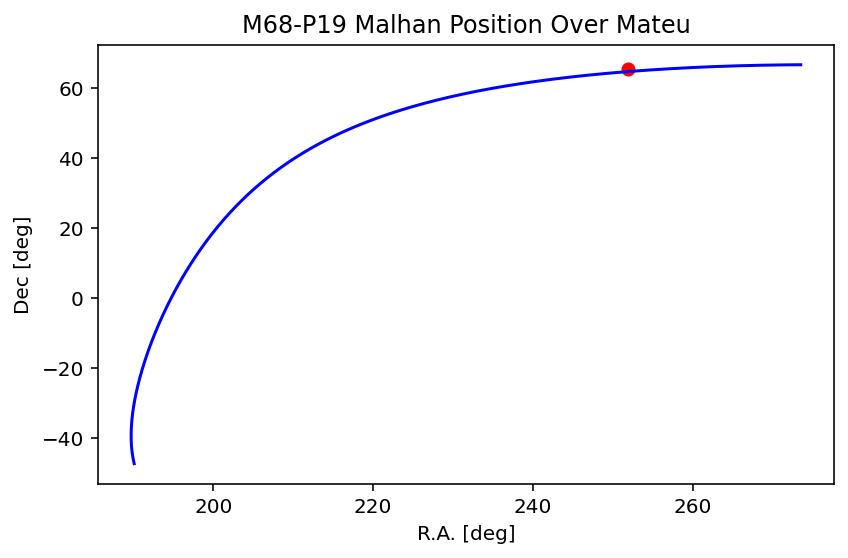

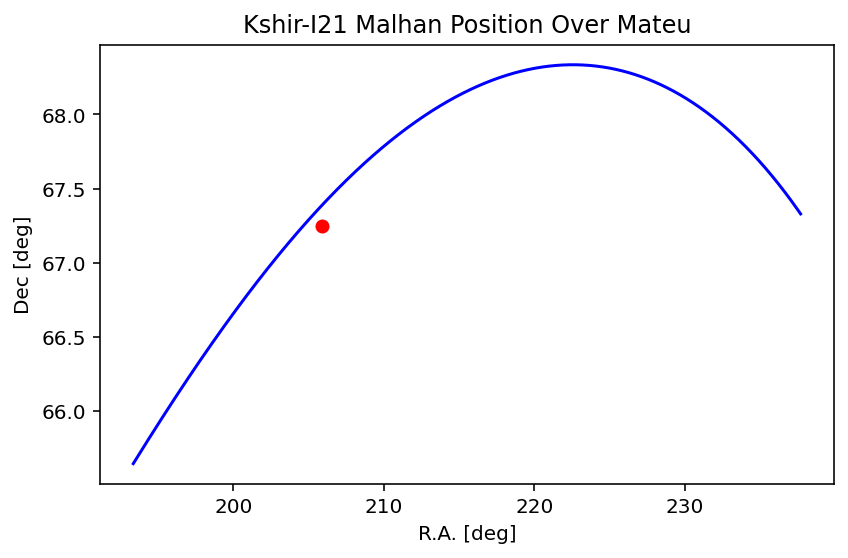

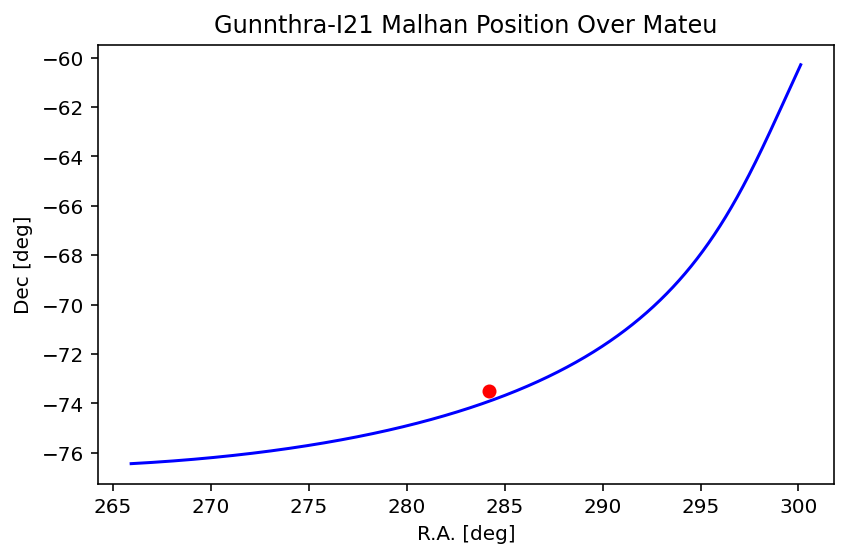

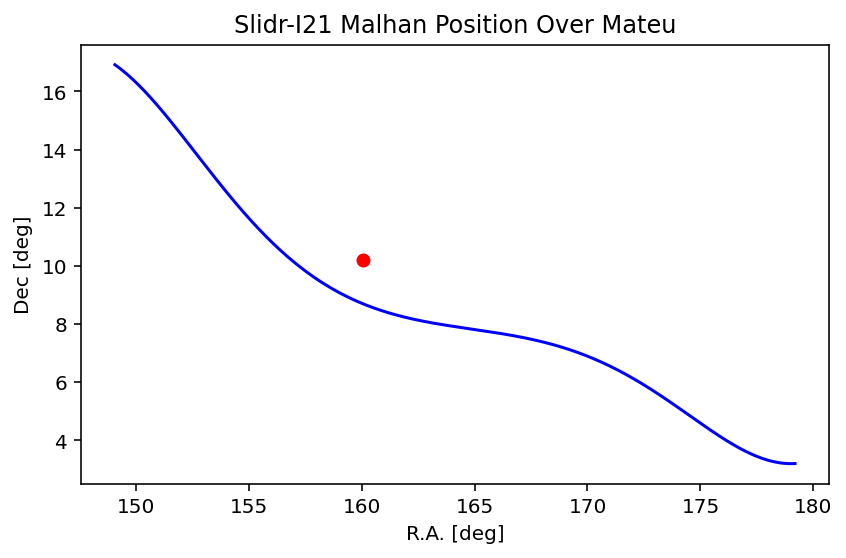

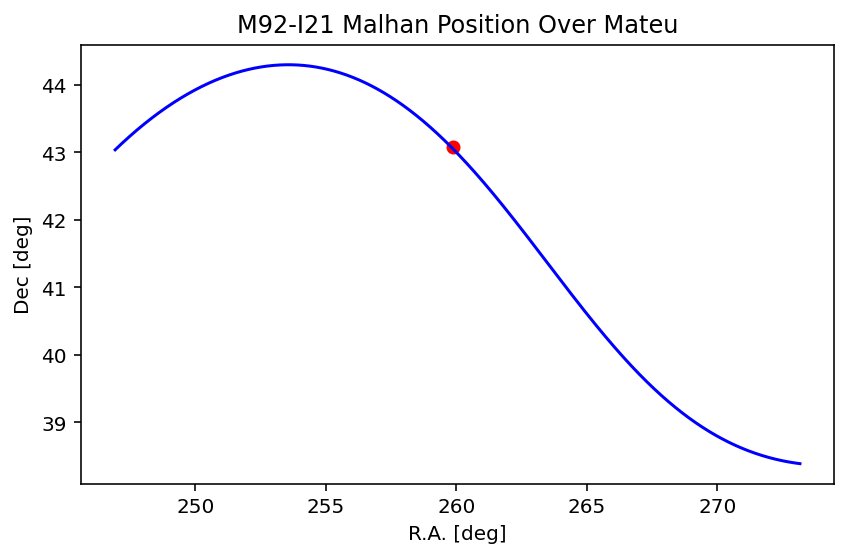

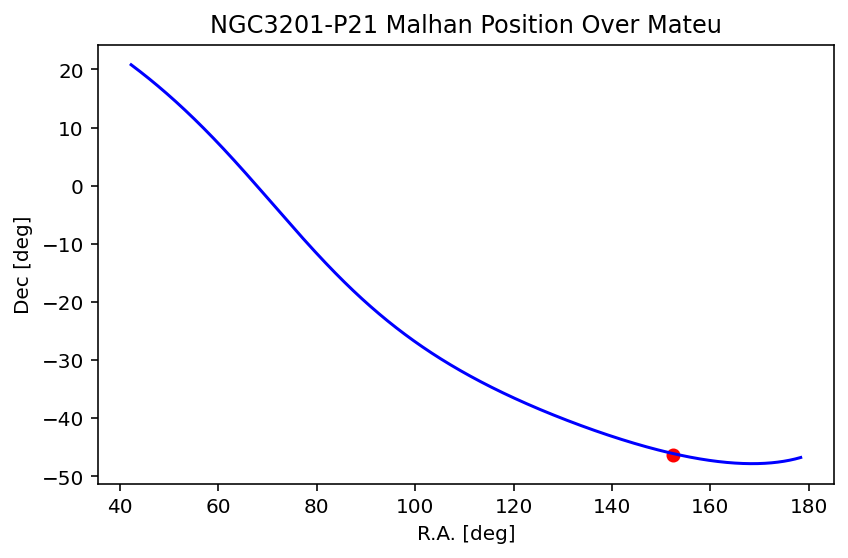

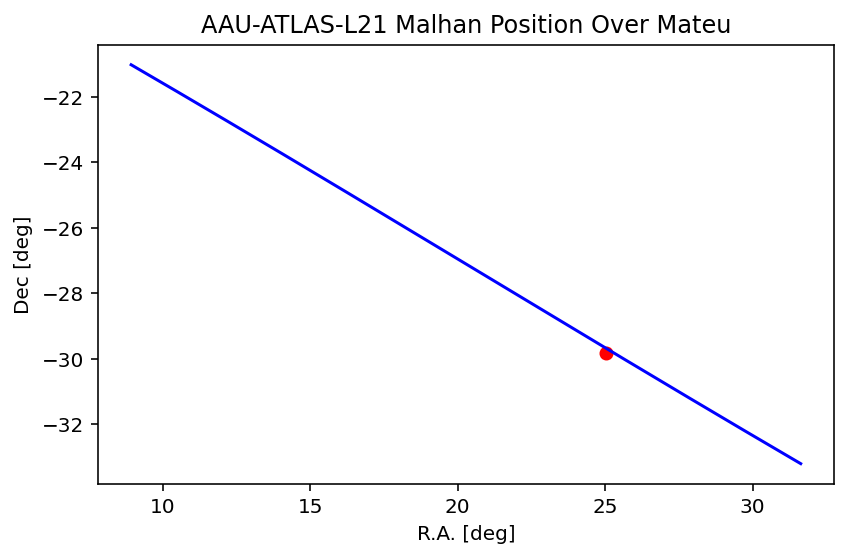

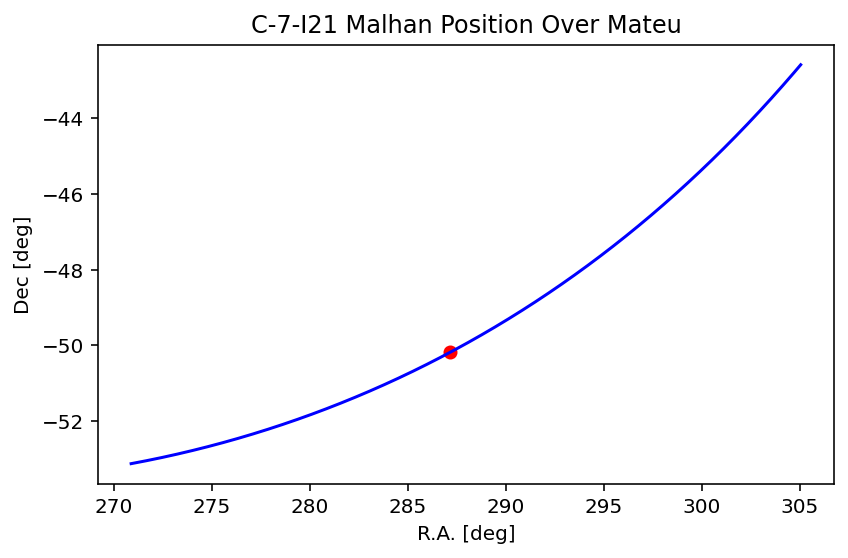

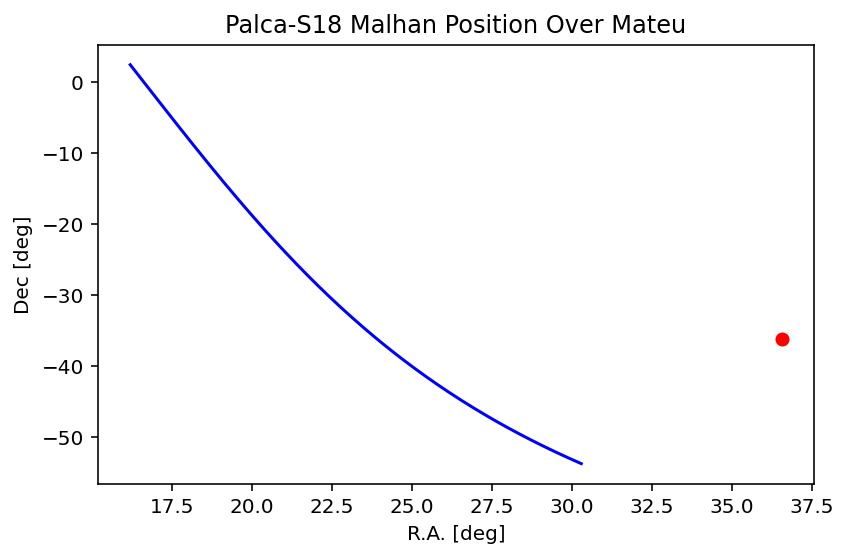

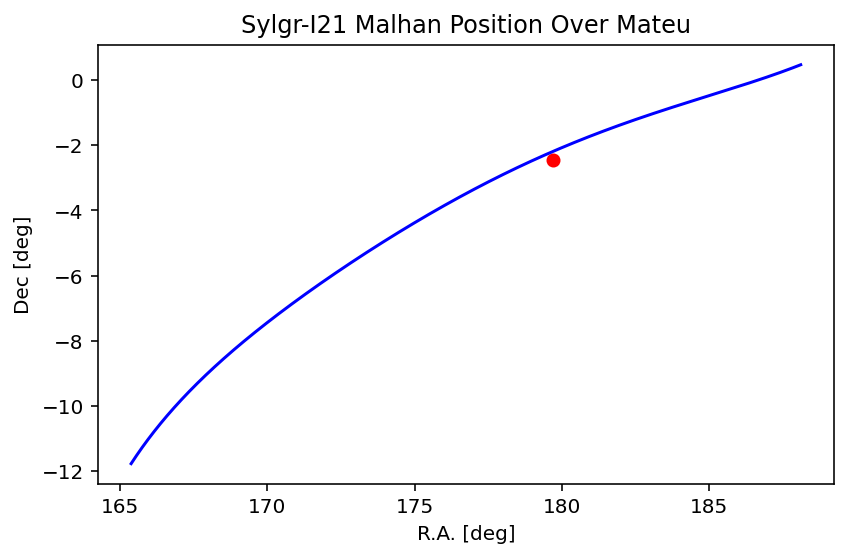

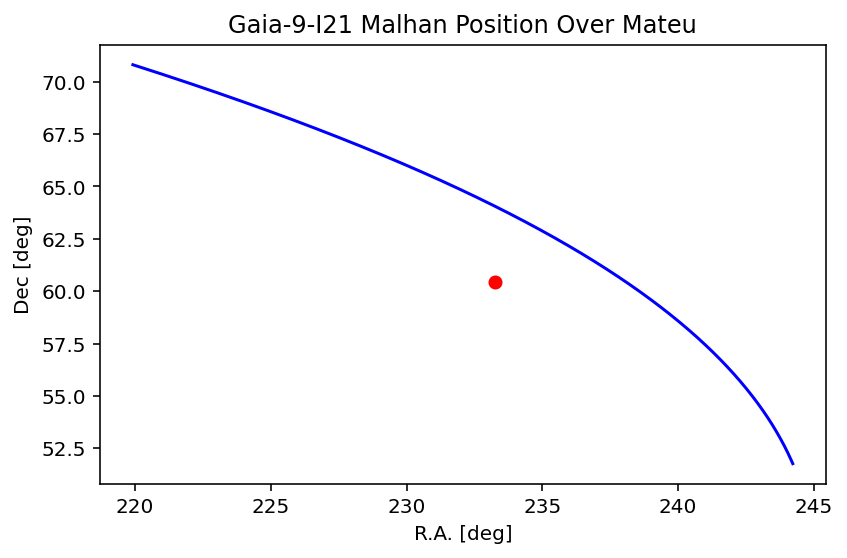

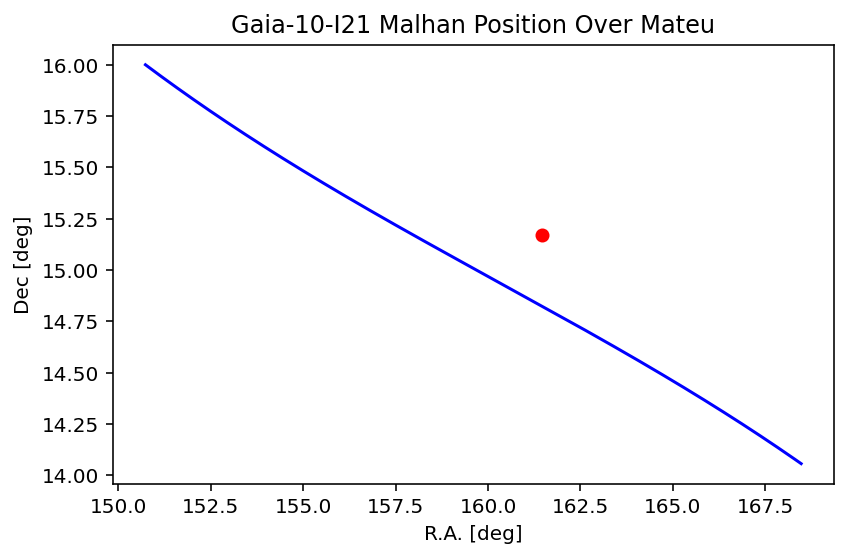

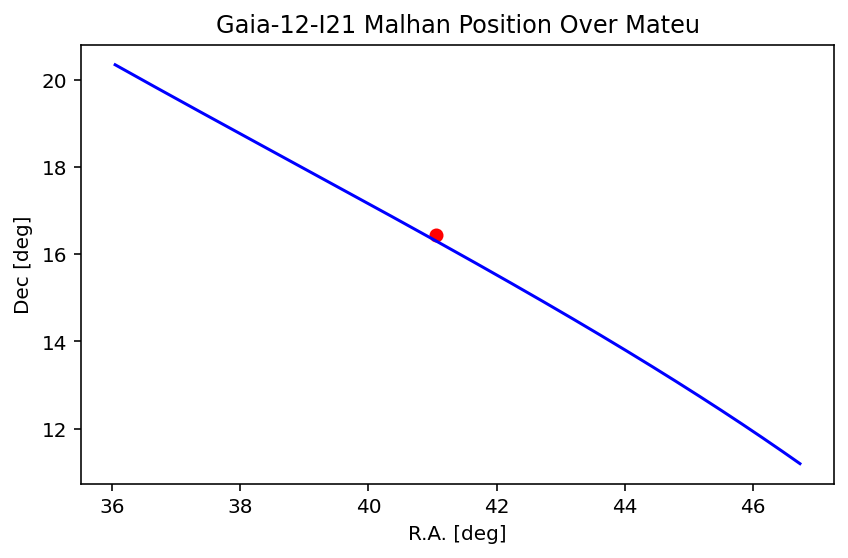

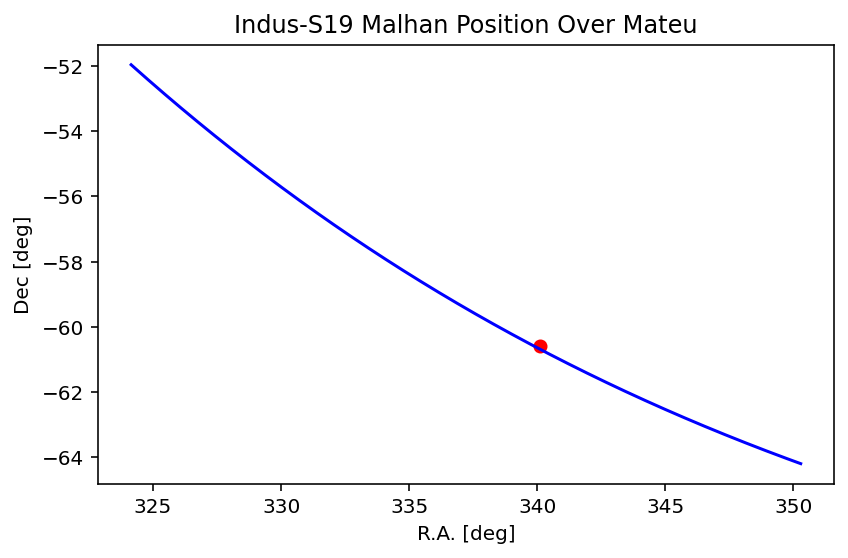

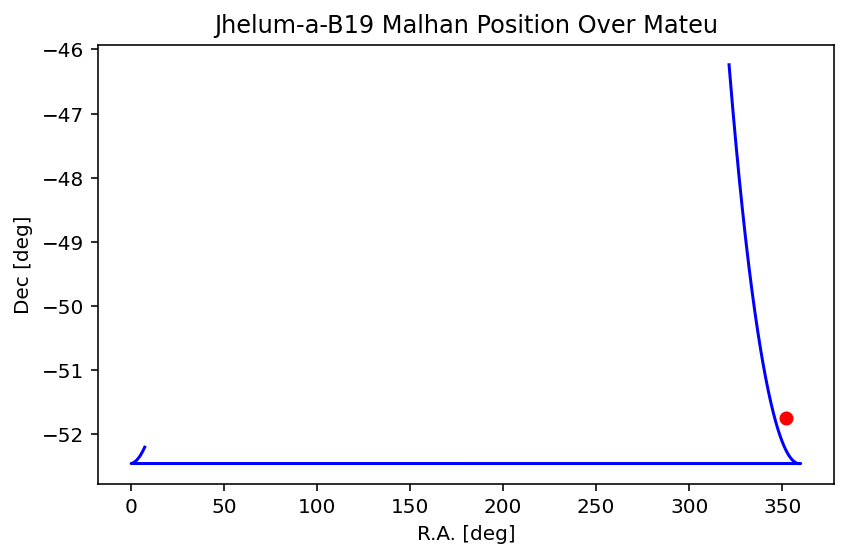

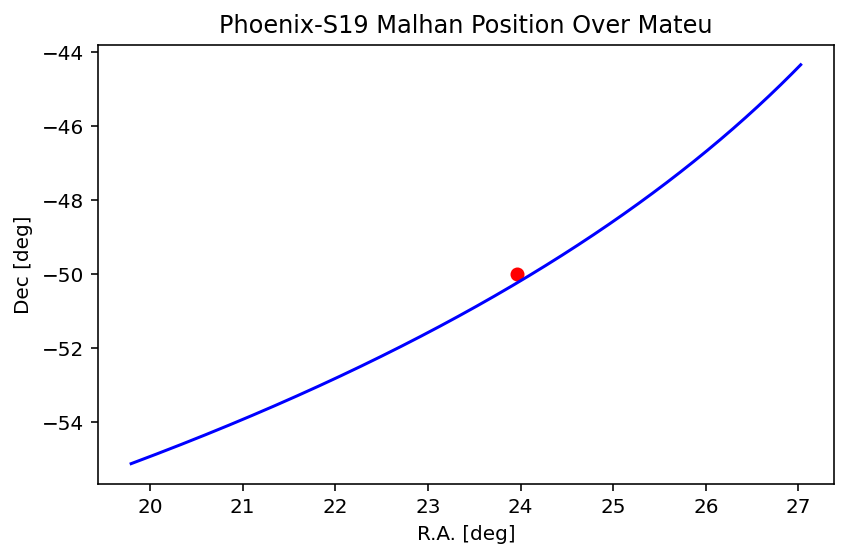

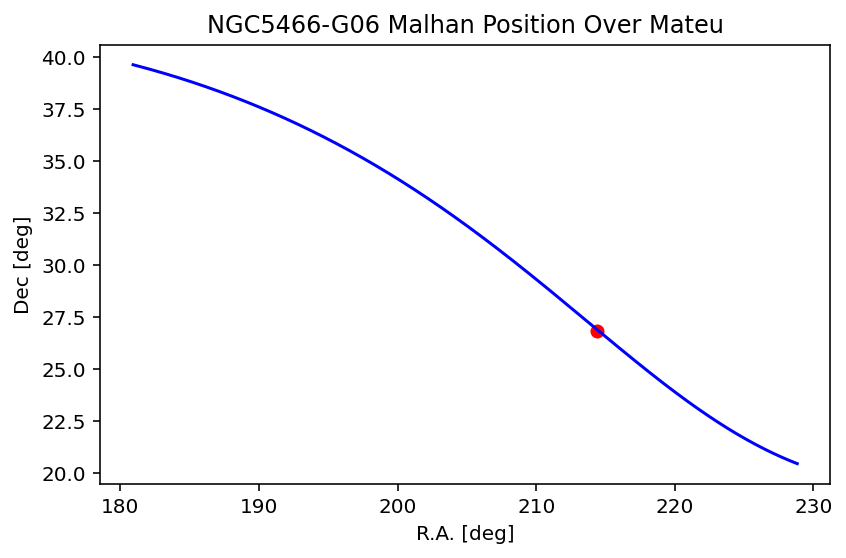

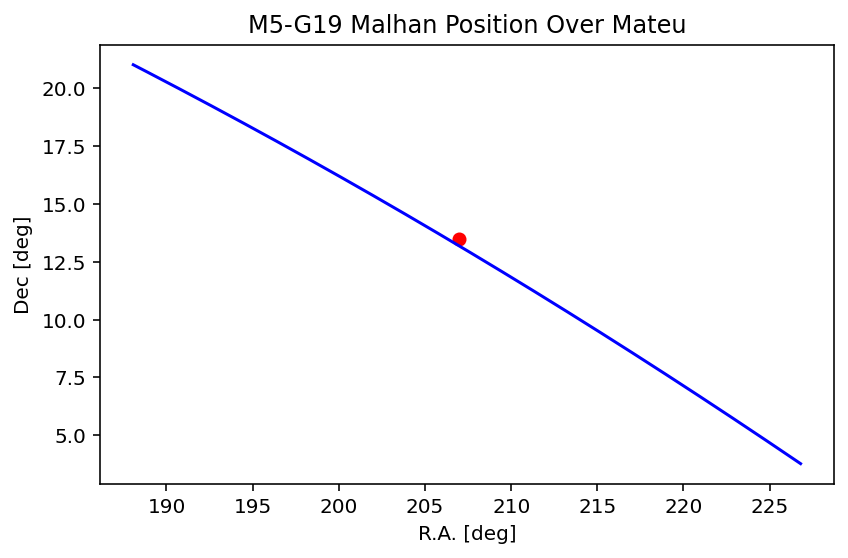

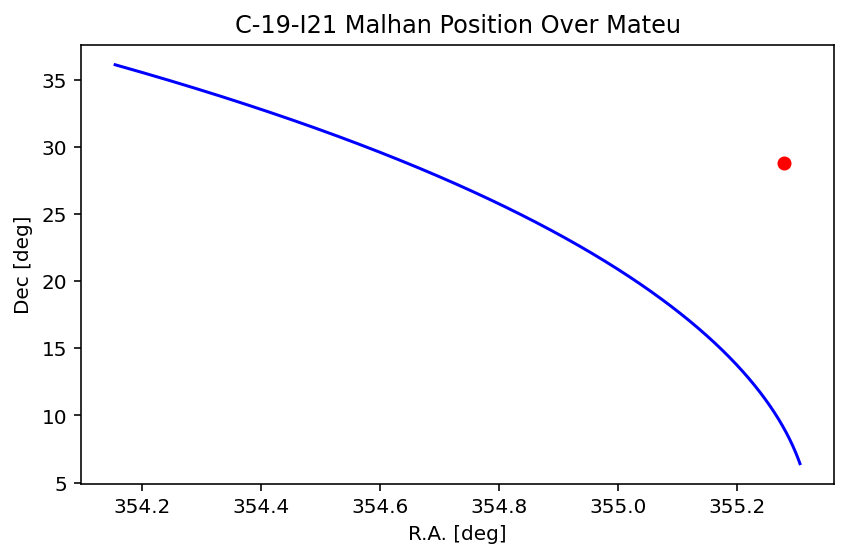

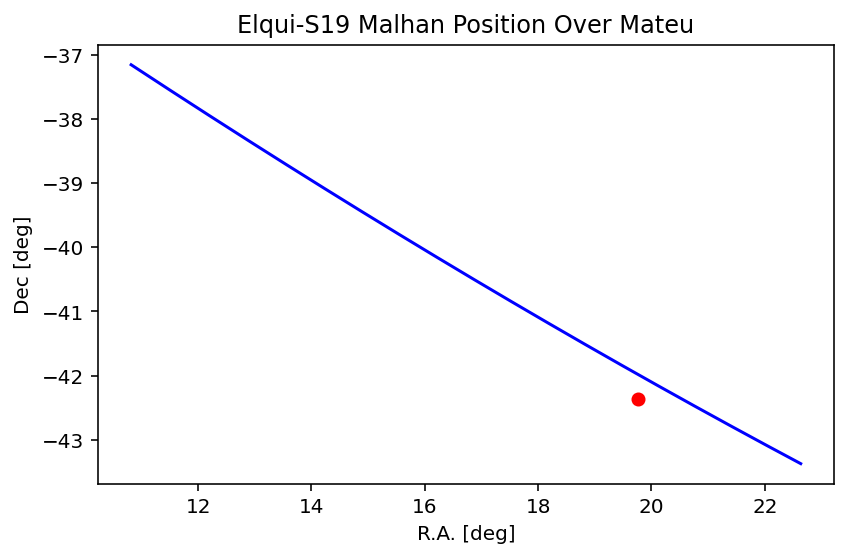

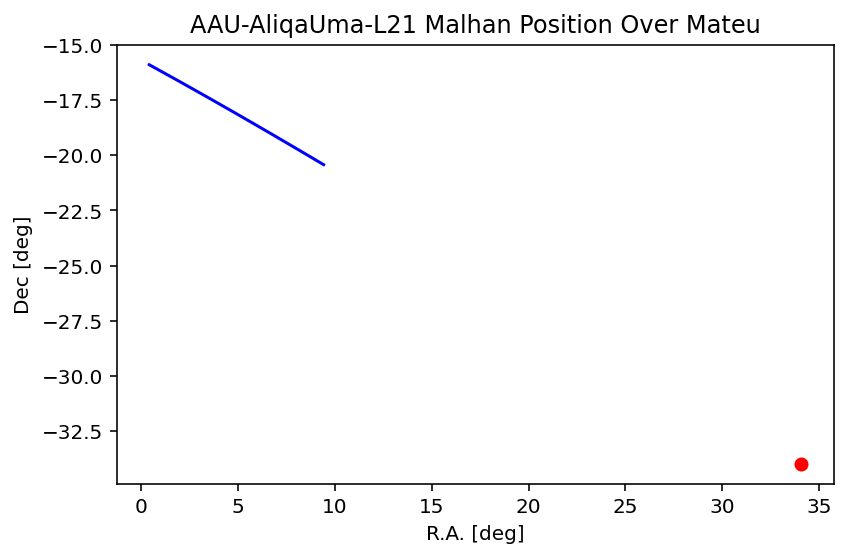

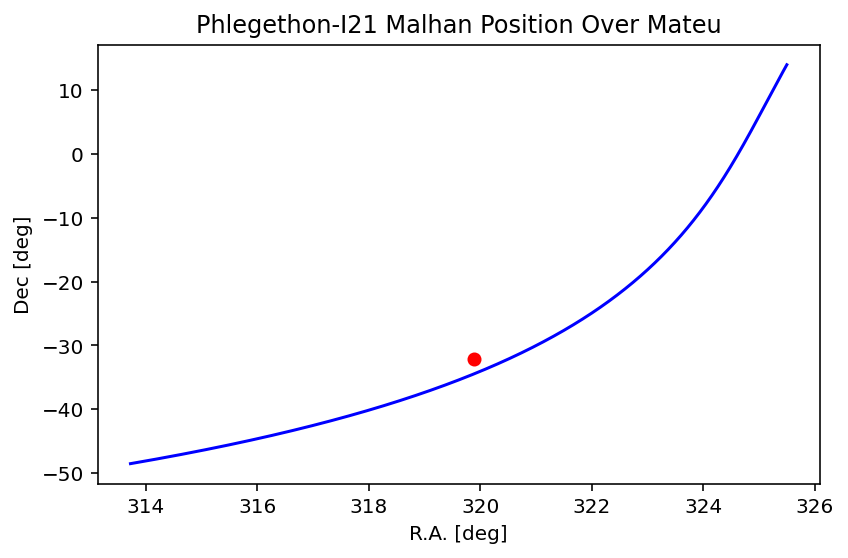

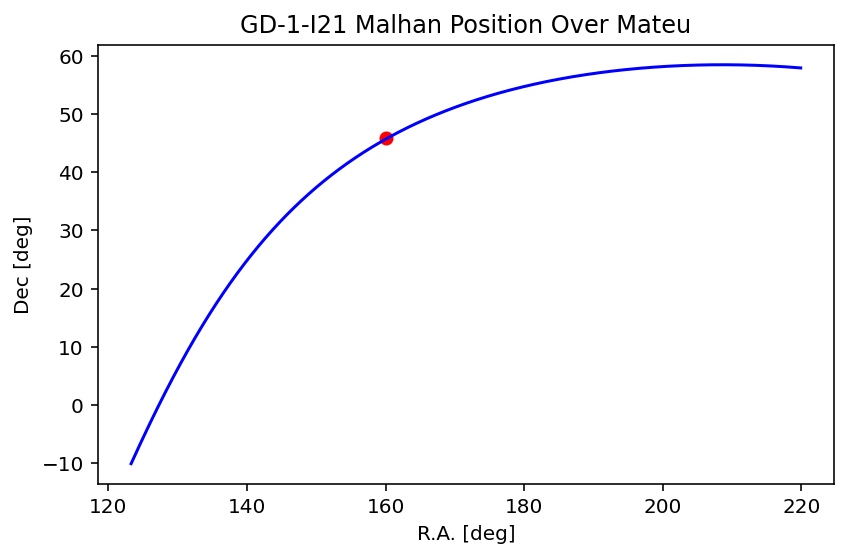

In [31]:
# define Galactocentric reference frame
coord.galactocentric_frame_defaults.set('v4.0')
gc_frame = coord.Galactocentric()
#define hamiltonian
ham = gp.Hamiltonian(gp.NFWPotential(m=MW_analog['mvir']/h*u.Msun, 
                                     r_s=(MW_analog['rs'])/h*u.kpc, units=galactic))

for i in range(len(names)):
    if list(names.values())[i] != 'None':
        c = coord.SkyCoord(ra=streams.iloc[i][1]*u.deg, dec=streams.iloc[i][2]*u.deg, distance=streams.iloc[i][3]*u.kpc, 
                           pm_ra_cosdec=streams.iloc[i][4]*u.mas/u.yr,pm_dec=streams.iloc[i][5]*u.mas/u.yr, 
                           radial_velocity=streams.iloc[i][6]*u.km/u.s, frame='icrs')
        w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)

        name=list(names.values())[i] #This one corresponds to Gjoll
        plt.figure()
        plt.plot(c.ra.wrap_at(360*u.deg), c.dec, 'ro')
        plt.plot(mwsts[name].track.ra.wrap_at(360*u.deg), mwsts[name].track.dec, 'b-')
        plt.title(list(names.values())[i]+' Malhan Position Over Mateu')
        plt.xlabel('R.A. [deg]')
        plt.ylabel('Dec [deg]')
        #plt.gca().set_aspect('equal')
        plt.tight_layout()

        plt.savefig('Creating_Streams_Steps/Original_Pos/'+name+'_Original_Pos.png', transparent=False, dpi=200)
        
        
        

<ipython-input-32-8d6827e4ce25>:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


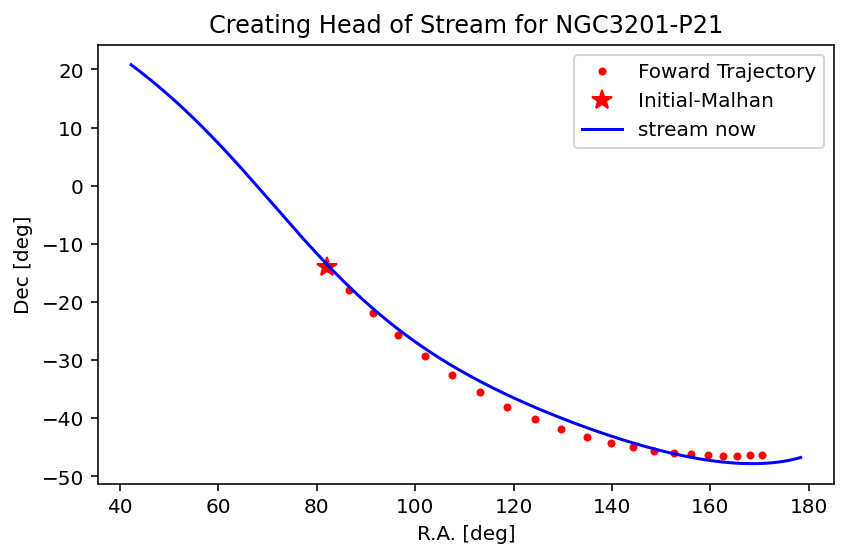

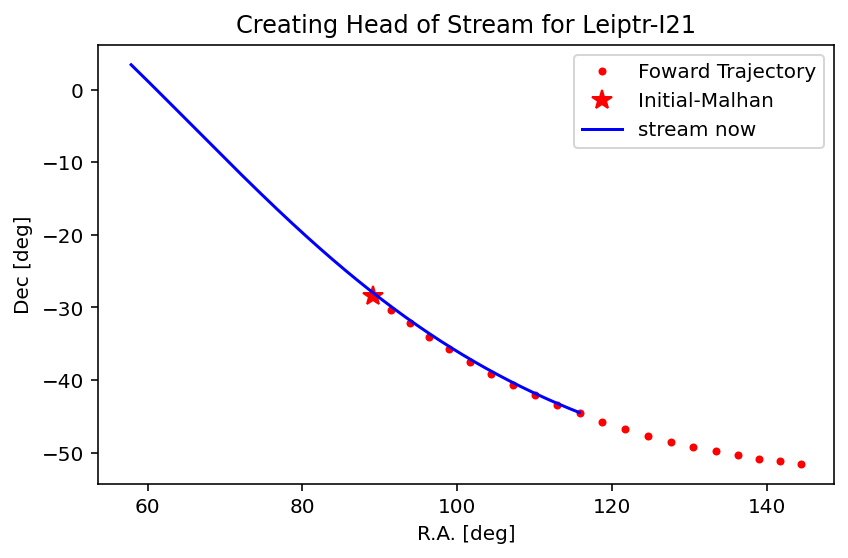

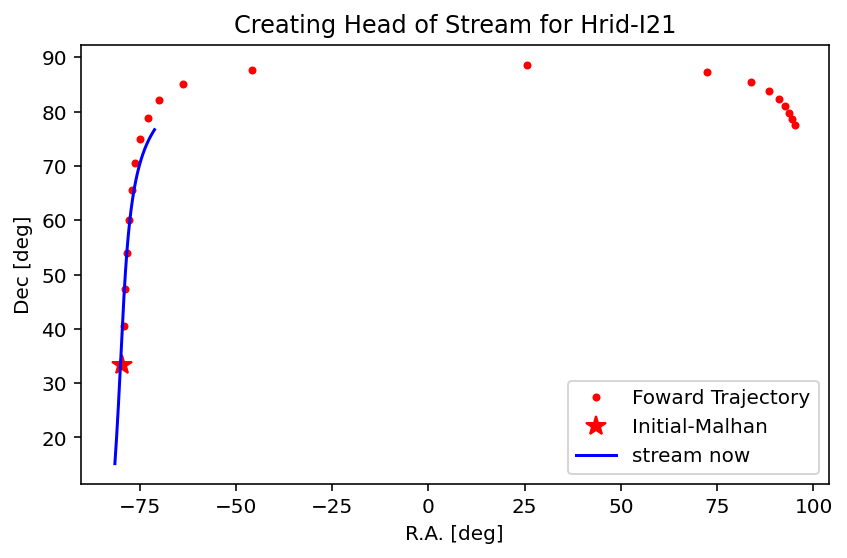

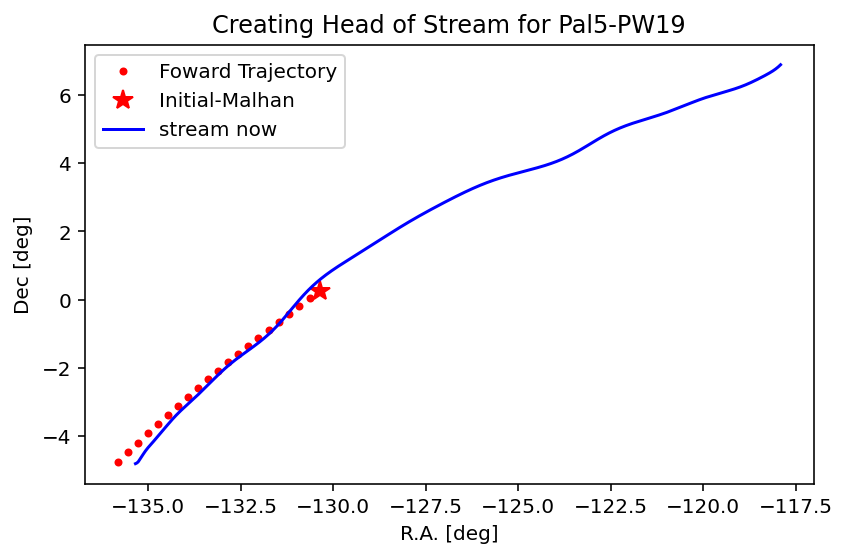

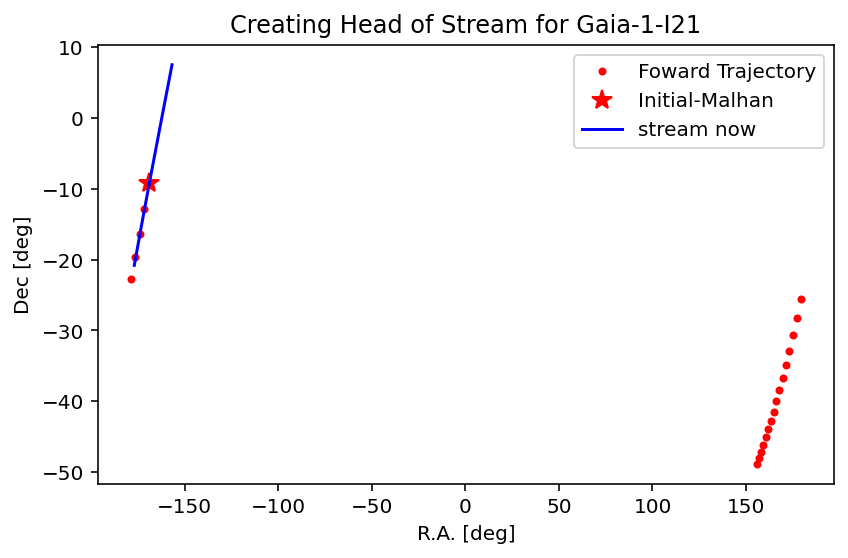

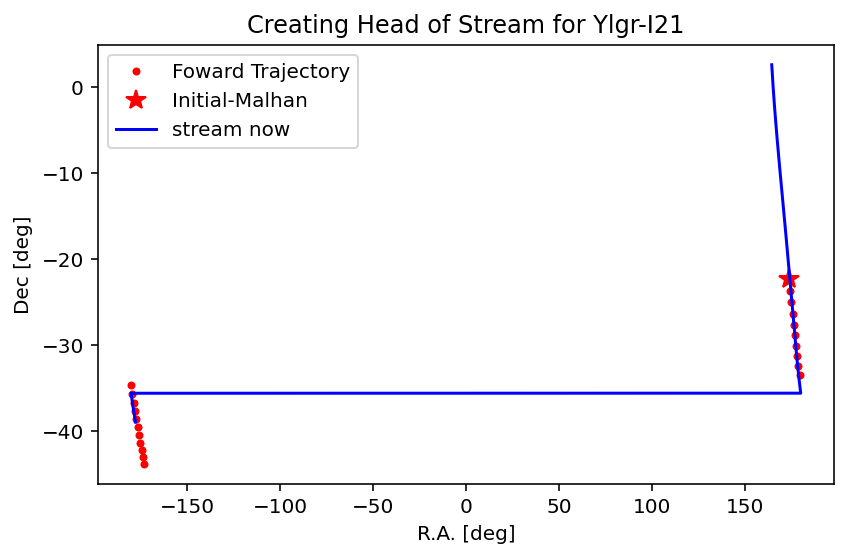

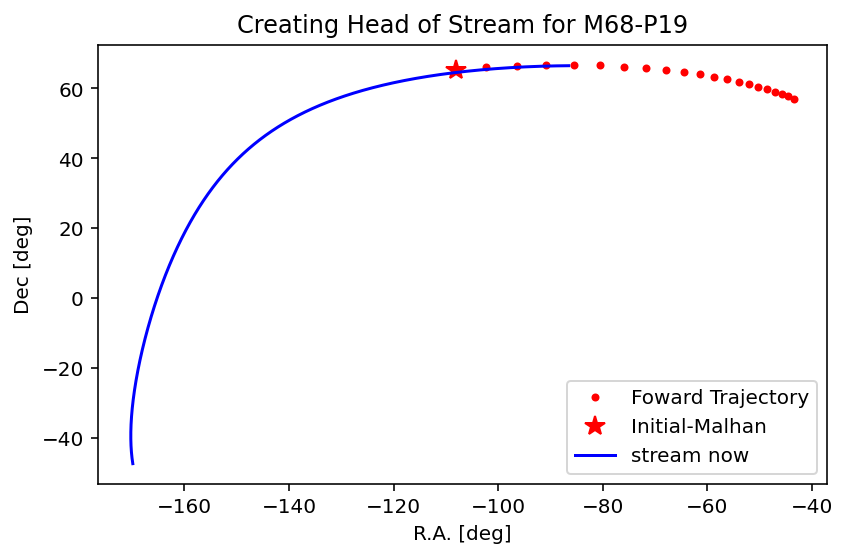

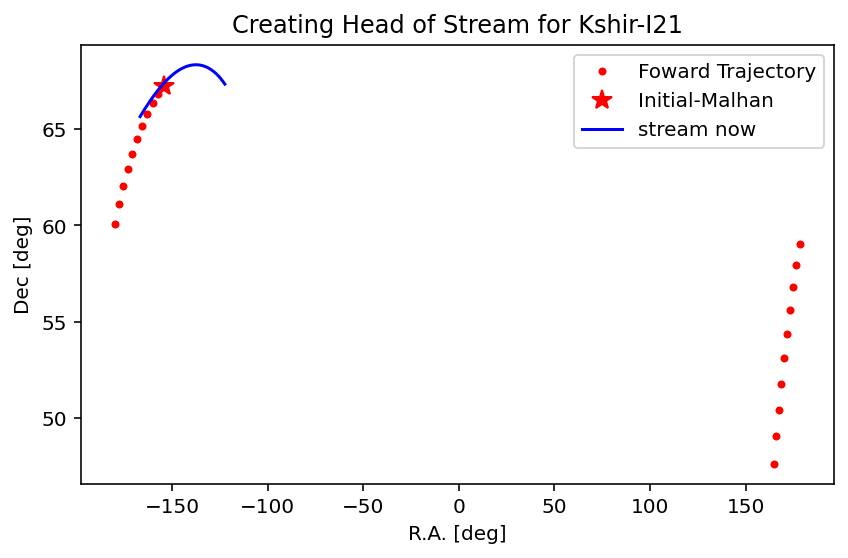

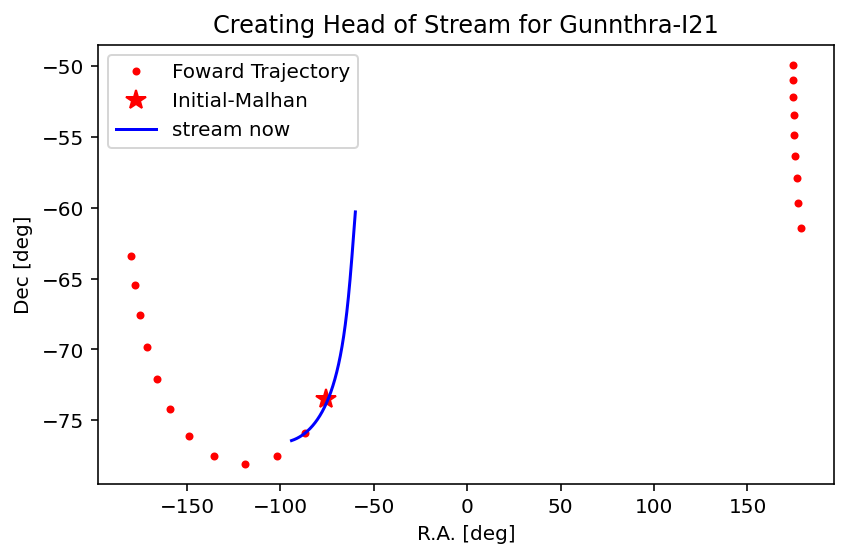

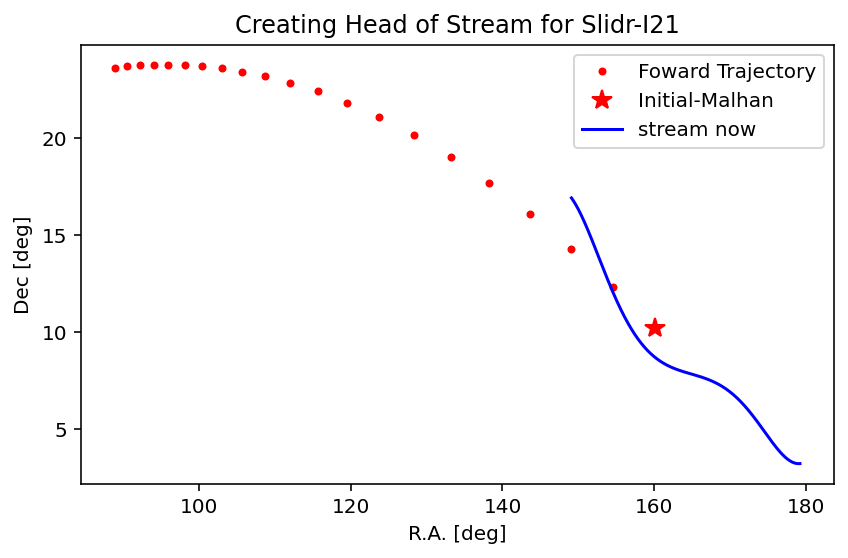

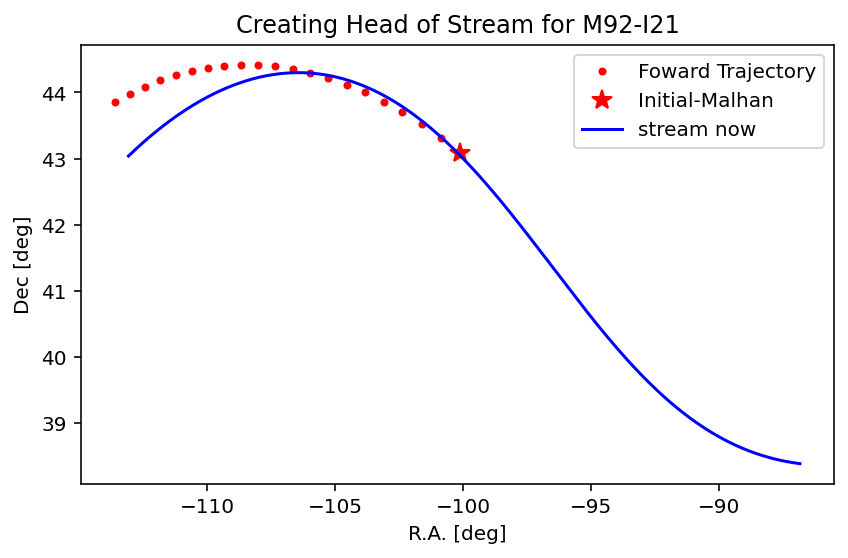

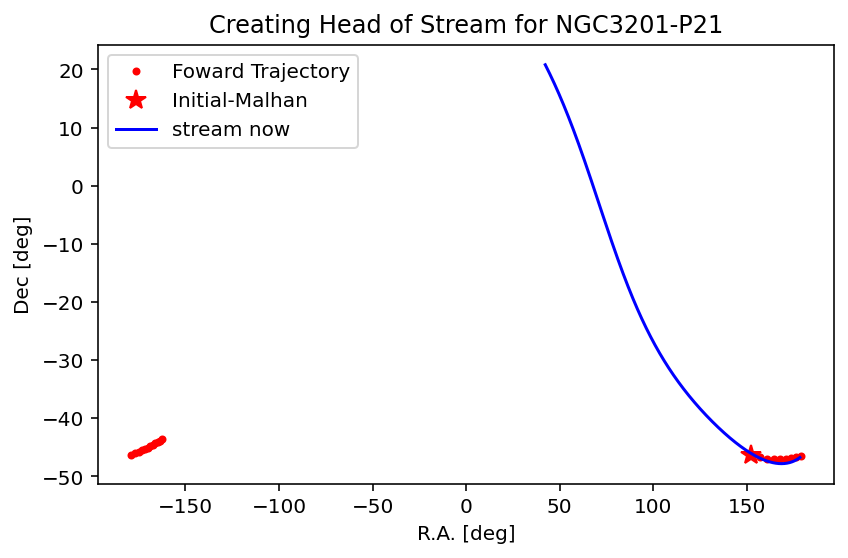

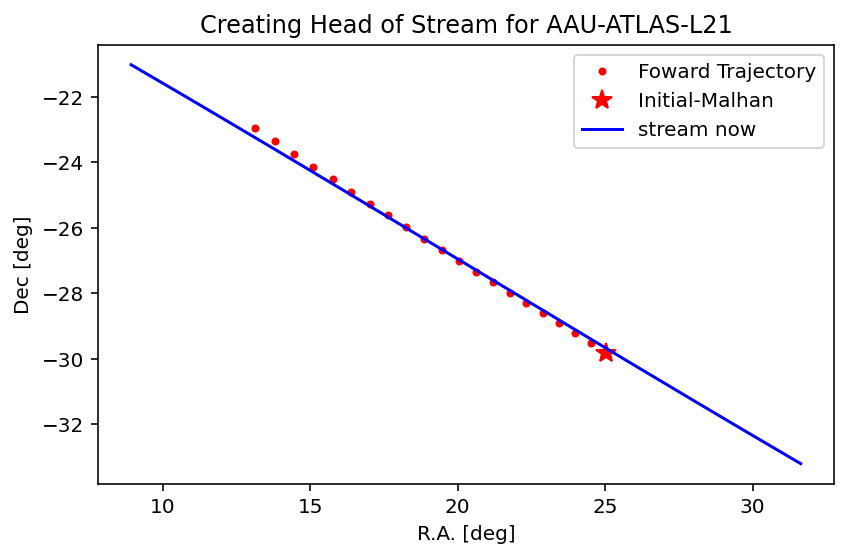

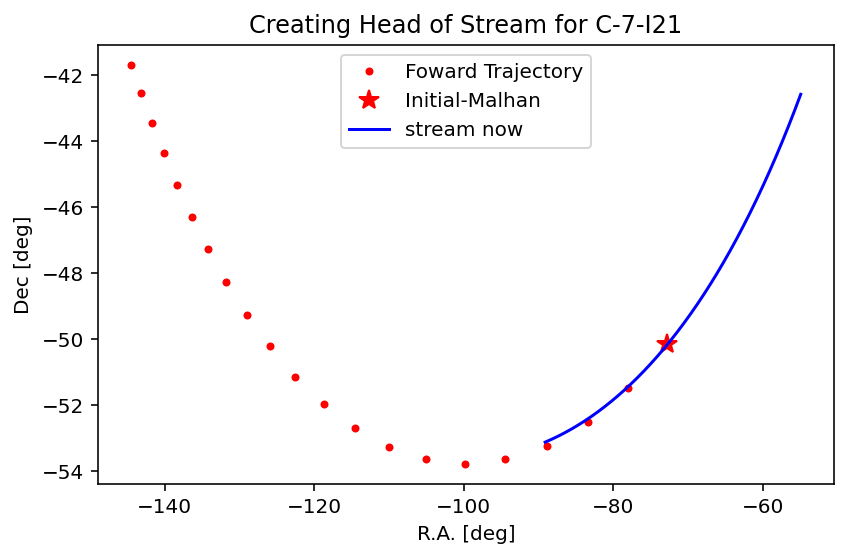

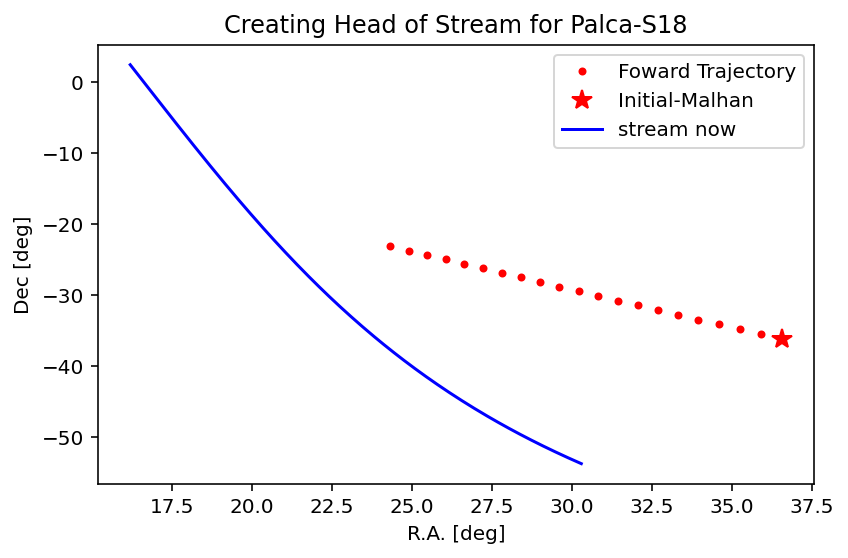

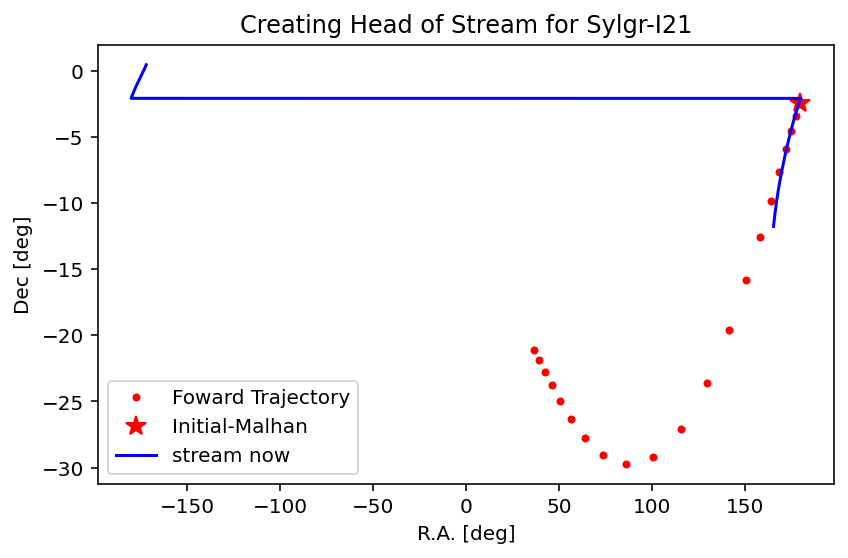

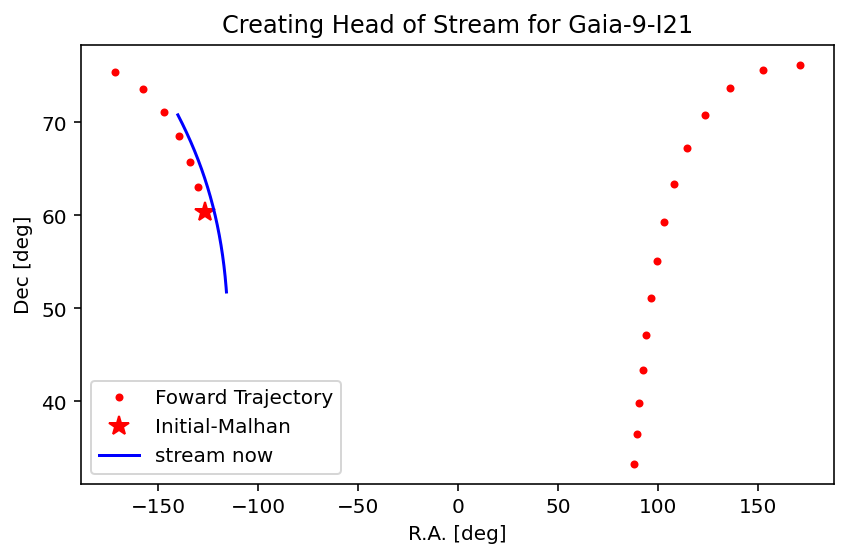

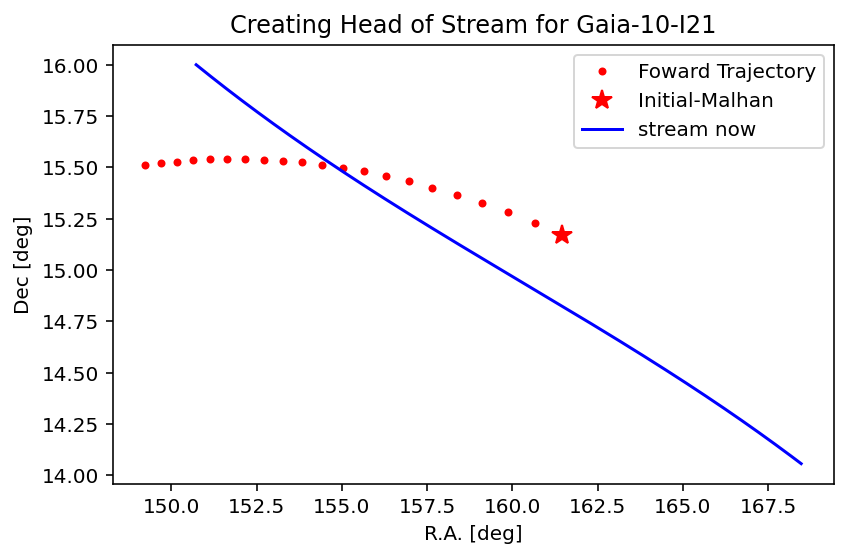

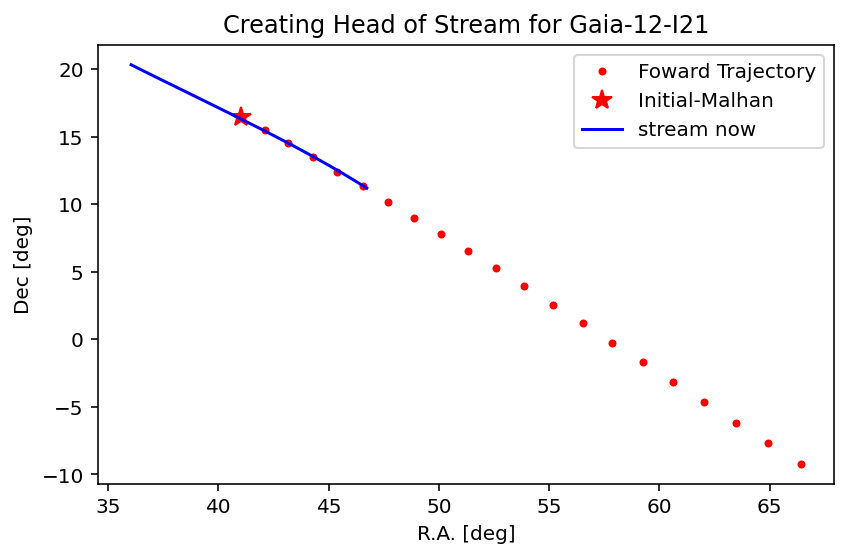

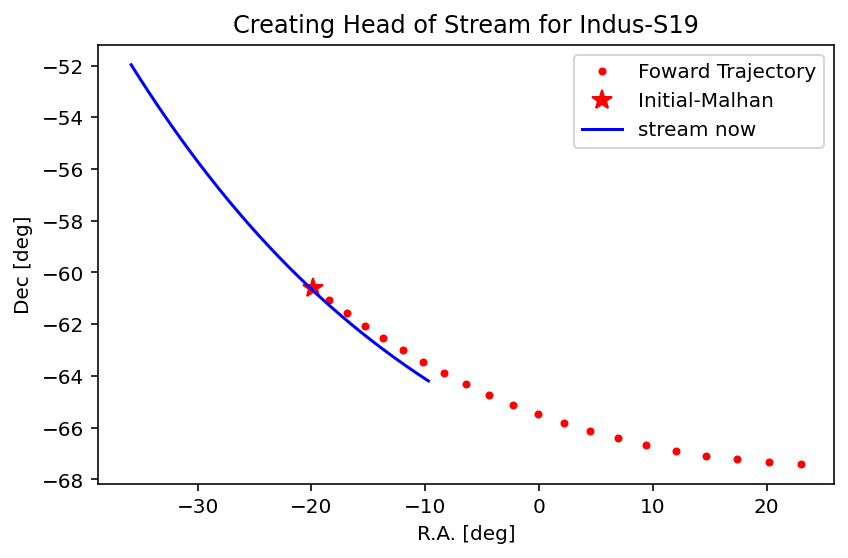

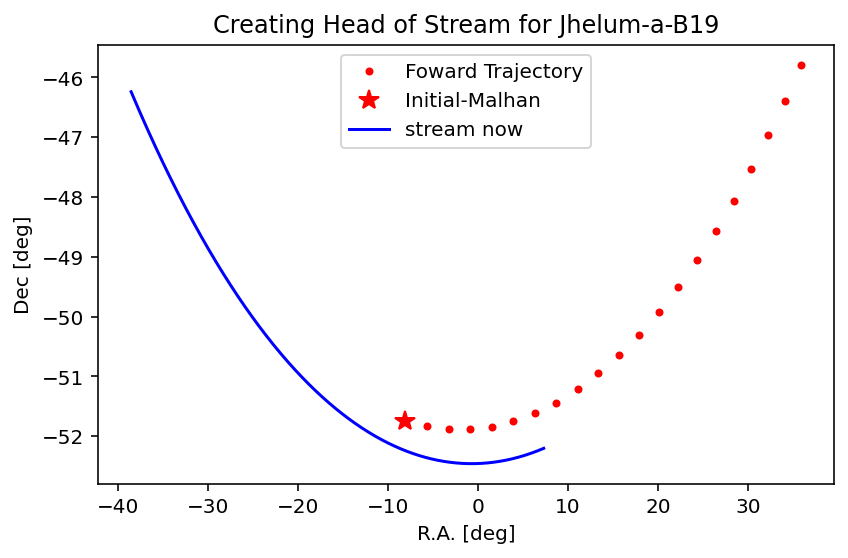

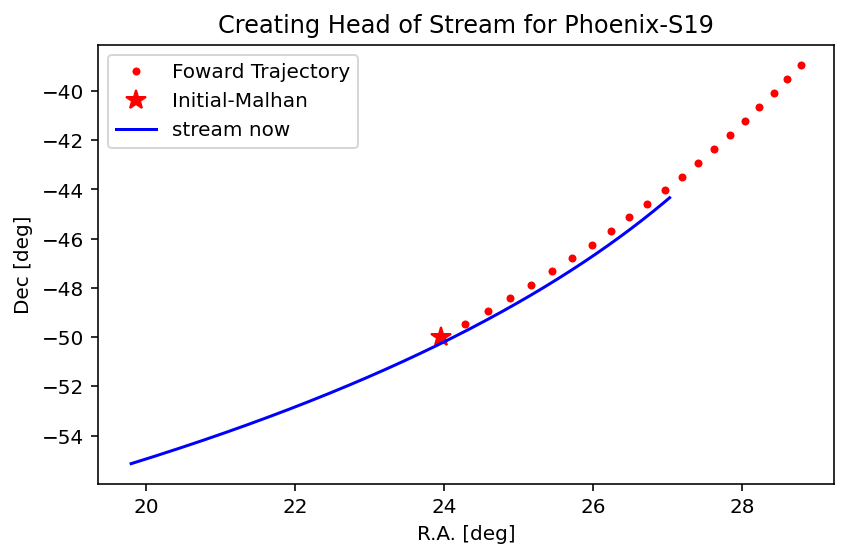

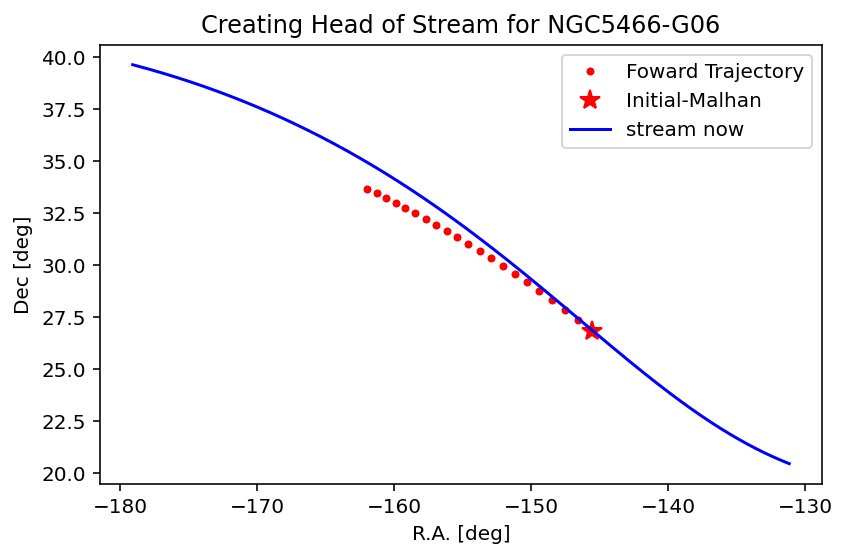

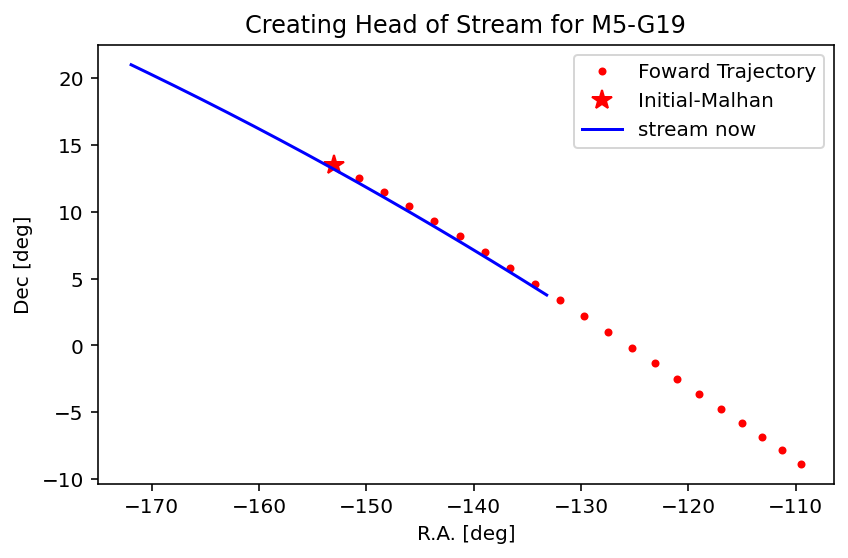

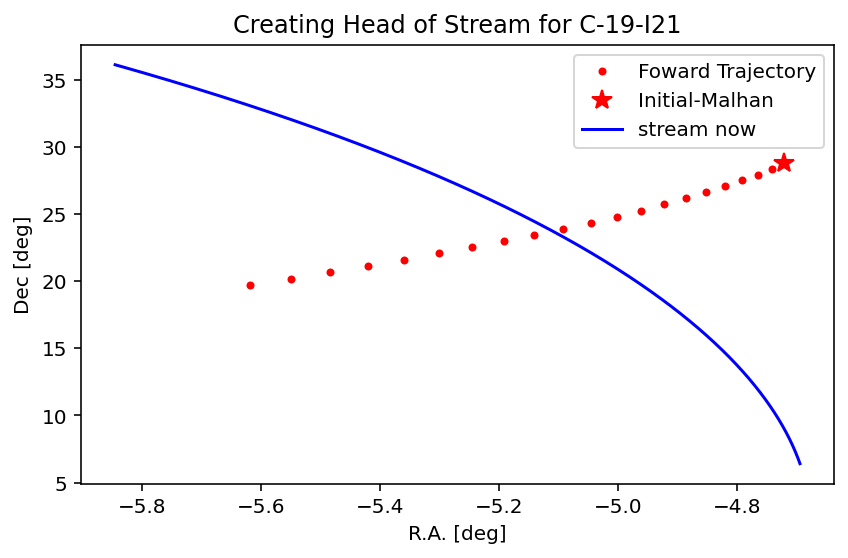

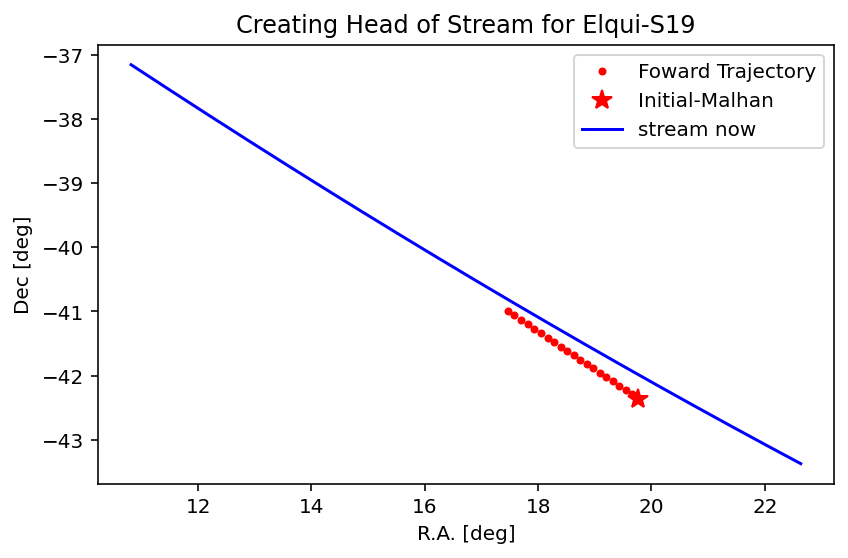

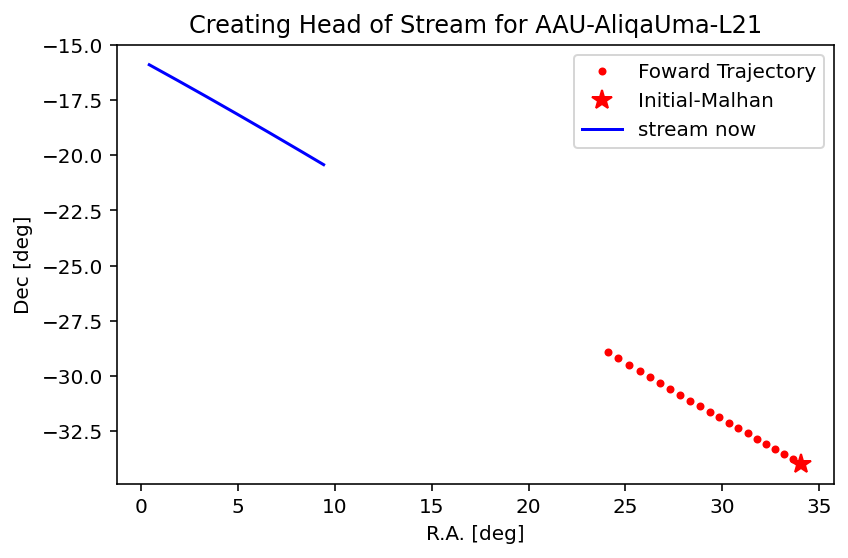

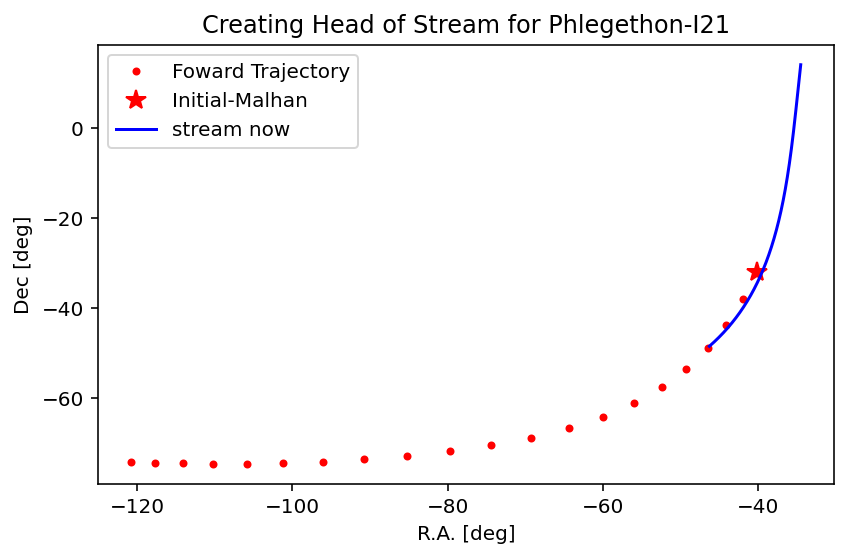

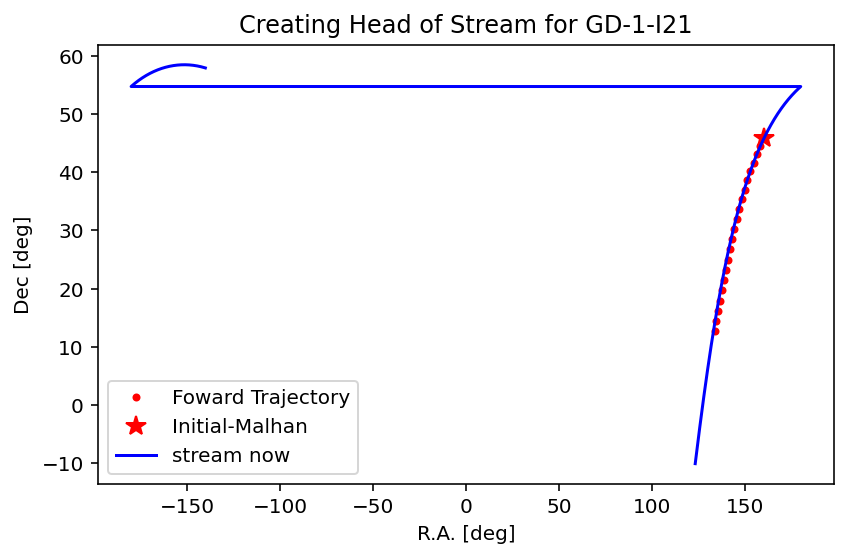

In [32]:
# define Galactocentric reference frame
coord.galactocentric_frame_defaults.set('v4.0')
gc_frame = coord.Galactocentric()
#define hamiltonian
ham = gp.Hamiltonian(gp.NFWPotential(m=MW_analog['mvir']/h*u.Msun, 
                                     r_s=(MW_analog['rs'])/h*u.kpc, units=galactic))

for i in range(len(names)):
    if list(names.values())[i] != 'None':
        c = coord.SkyCoord(ra=streams.iloc[i][1]*u.deg, dec=streams.iloc[i][2]*u.deg, distance=streams.iloc[i][3]*u.kpc, 
                           pm_ra_cosdec=streams.iloc[i][4]*u.mas/u.yr,pm_dec=streams.iloc[i][5]*u.mas/u.yr, 
                           radial_velocity=streams.iloc[i][6]*u.km/u.s, frame='icrs')
        w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)

        name=list(names.values())[i] 
        
        plt.figure()
        dt = 1*u.Myr
        Nstep_foward = 20
        orbit_foward = ham.integrate_orbit(w0, dt=dt, n_steps=Nstep_foward)
        orbit_foward_icrs = orbit_foward.to_coord_frame(coord.ICRS())

        plt.plot(orbit_foward_icrs.ra.wrap_at(180*u.deg), orbit_foward_icrs.dec, '.r', label='Foward Trajectory')
        plt.plot(orbit_foward_icrs.ra.wrap_at(180*u.deg)[0], orbit_foward_icrs.dec[0], '*r', label='Initial-Malhan', ms=10)
        plt.plot(mwsts[name].track.ra.wrap_at(180*u.deg), mwsts[name].track.dec, 'b-', label='stream now')
        plt.legend(loc='best')
        plt.title('Creating Head of Stream for '+name)
        plt.xlabel('R.A. [deg]')
        plt.ylabel('Dec [deg]')
        plt.tight_layout()
        plt.savefig('Creating_Streams_Steps/New_Initial_Pos/'+name+'_New_Initial_Pos.png', transparent=False, dpi=200)


In [ ]:
#Plot Atlas and AAU and try to combine them into one stream. 

In [36]:
Nstep_foward_dict = dict(Gjoll=20,Leiptr=10,
Hrid=8, Pal5=19, 
Gaia_1=3, Ylgr=12, #check Ylgr
Fjorm=4, Kshir=3, #check Kshir
Gunnthra=1, Slidr=2, #check Gunthra & Slidr
M92=20, NGC_3201=8, #check M92  #for NGC try to zoom in or wrap aorund 360 
Atlas=25, C_7=3, 
Palca='Unknown', Sylgr=5, #check Sylgr
Gaia_9=4, Gaia_10=17, #check Gaia9 #add a number for Gaia 10 
Gaia_12=5, Indus=7, 
Jhelum=6, Phoenix=11,
NGC5466=50, M5=8, #check NGC5466
C_20='None', C_19='Unknown', #check label 
Elqui=70, AliqaUma='Unknown', 
Phlegethon=3, GD_1=35)

#Next step is to access these N Steps foward to create separate individual graphs (as the one below) and then
#Find how many total steps represent the stream 

In [42]:
names.values()

dict_values(['NGC3201-P21', 'Leiptr-I21', 'Hrid-I21', 'Pal5-PW19', 'Gaia-1-I21', 'Ylgr-I21', 'M68-P19', 'Kshir-I21', 'Gunnthra-I21', 'Slidr-I21', 'M92-I21', 'NGC3201-P21', 'AAU-ATLAS-L21', 'C-7-I21', 'Palca-S18', 'Sylgr-I21', 'Gaia-9-I21', 'Gaia-10-I21', 'Gaia-12-I21', 'Indus-S19', 'Jhelum-a-B19', 'Phoenix-S19', 'NGC5466-G06', 'M5-G19', 'None', 'C-19-I21', 'Elqui-S19', 'AAU-AliqaUma-L21', 'Phlegethon-I21', 'GD-1-I21'])

In [61]:
list(Nstep_foward_dict.values())[14]

'Unknown'

In [62]:
list(names.values())[15]

'Sylgr-I21'

In [80]:
names.values()

dict_values(['NGC3201-P21', 'Leiptr-I21', 'Hrid-I21', 'Pal5-PW19', 'Gaia-1-I21', 'Ylgr-I21', 'M68-P19', 'Kshir-I21', 'Gunnthra-I21', 'Slidr-I21', 'M92-I21', 'NGC3201-P21', 'AAU-ATLAS-L21', 'C-7-I21', 'Palca-S18', 'Sylgr-I21', 'Gaia-9-I21', 'Gaia-10-I21', 'Gaia-12-I21', 'Indus-S19', 'Jhelum-a-B19', 'Phoenix-S19', 'NGC5466-G06', 'M5-G19', 'None', 'C-19-I21', 'Elqui-S19', 'AAU-AliqaUma-L21', 'Phlegethon-I21', 'GD-1-I21'])

<ipython-input-119-b225170b22d9>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


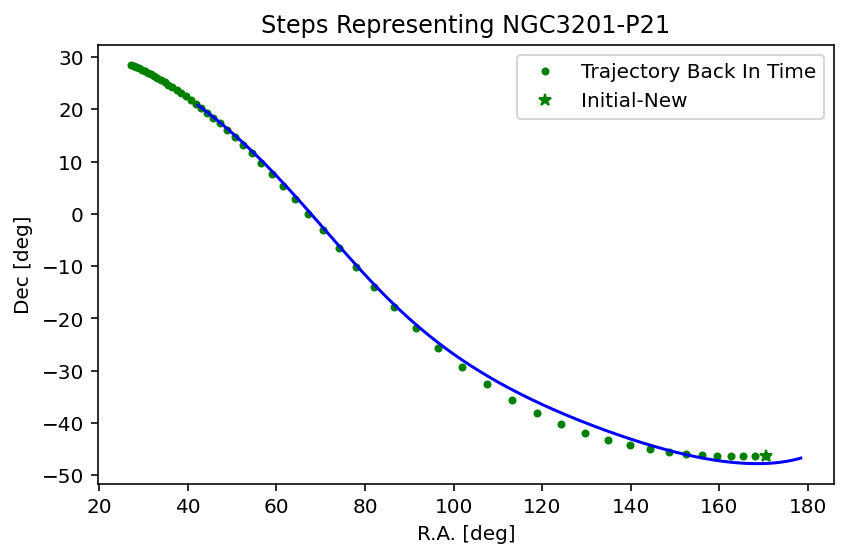

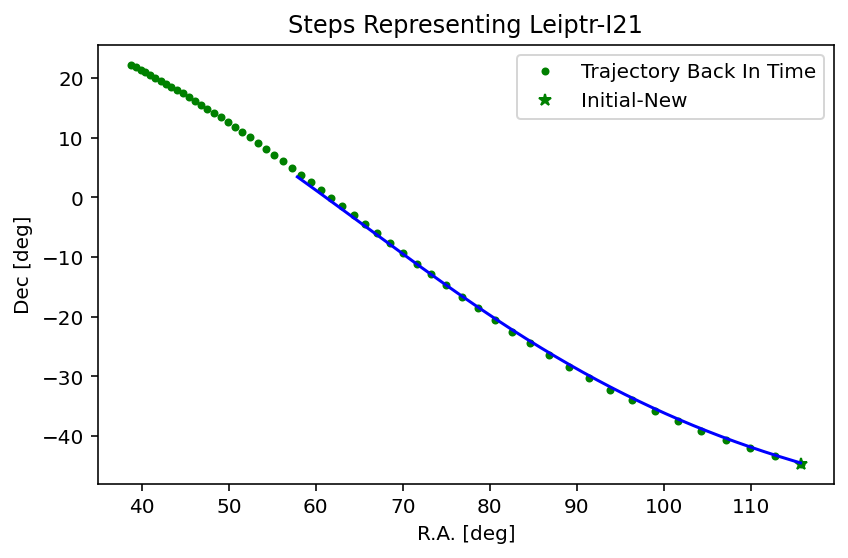

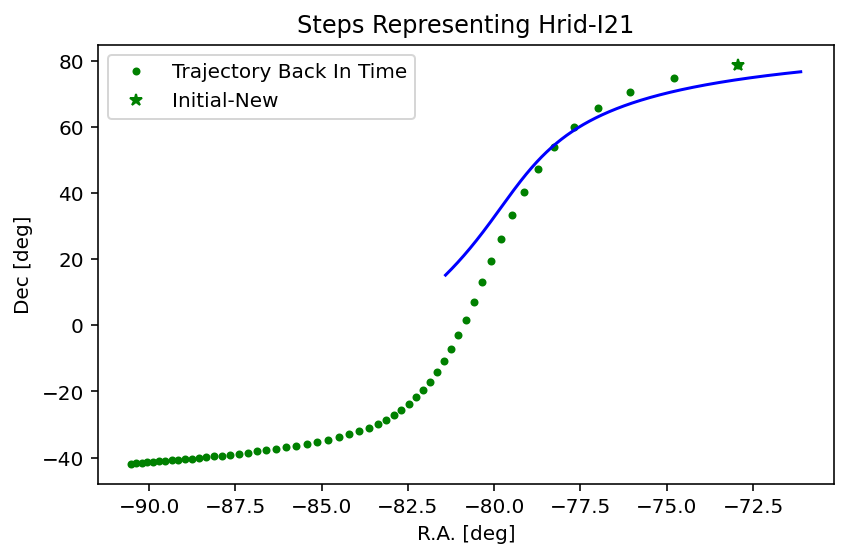

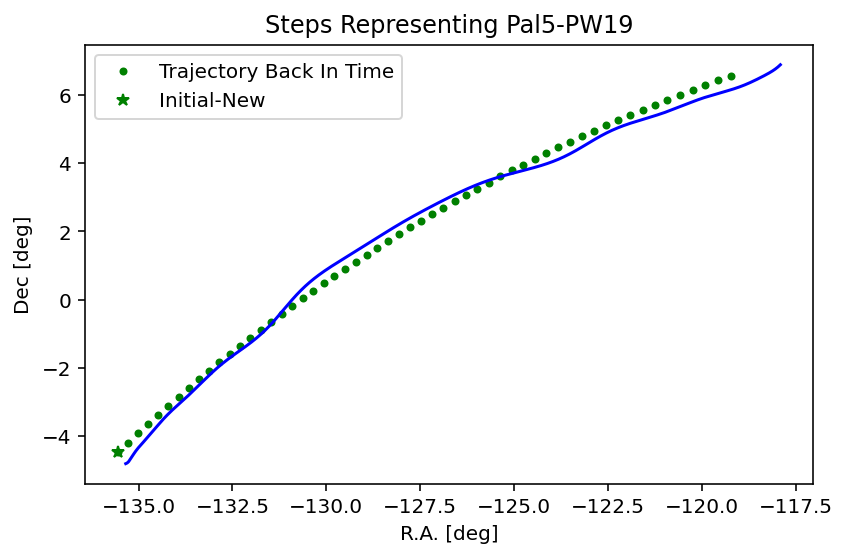

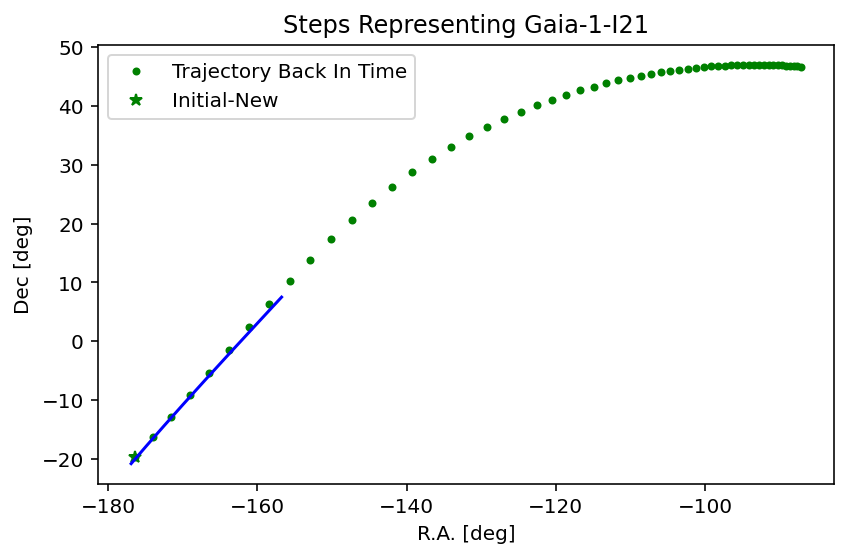

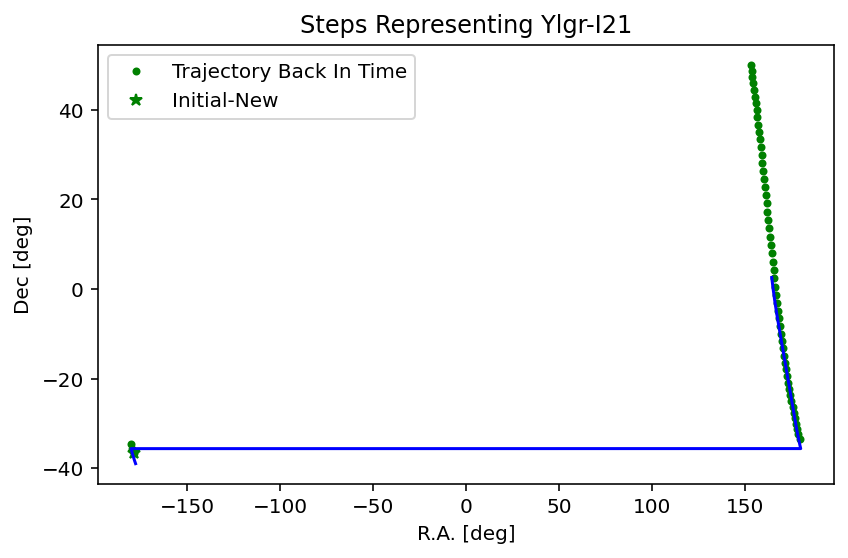

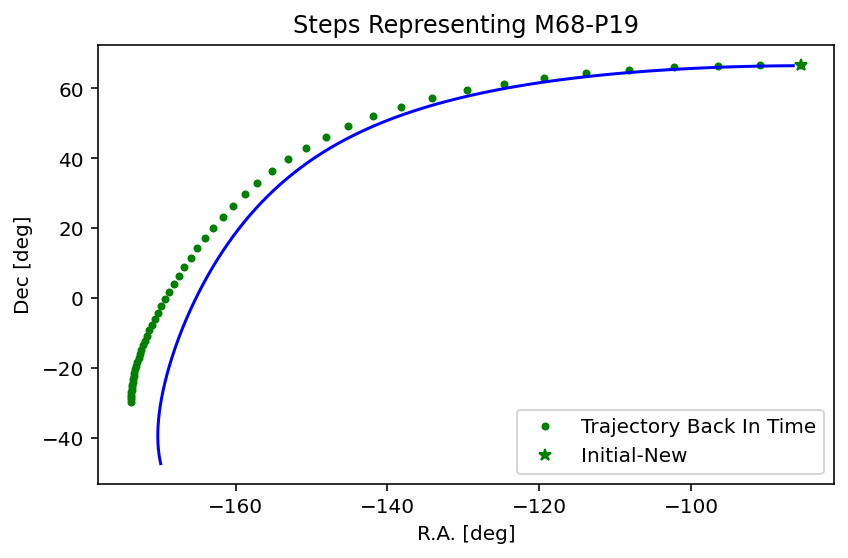

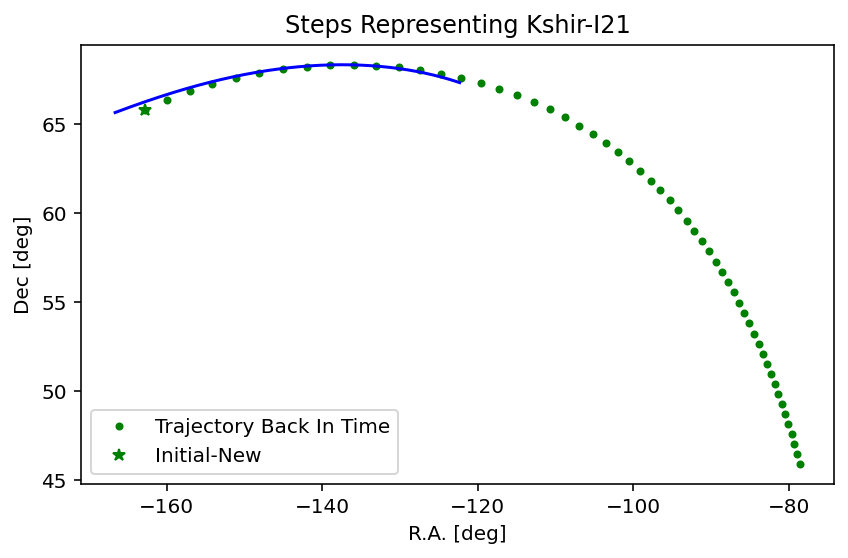

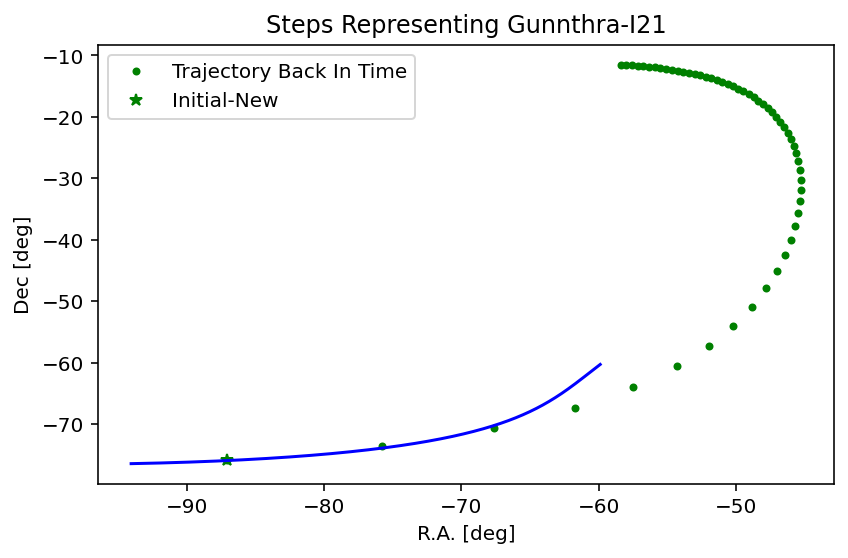

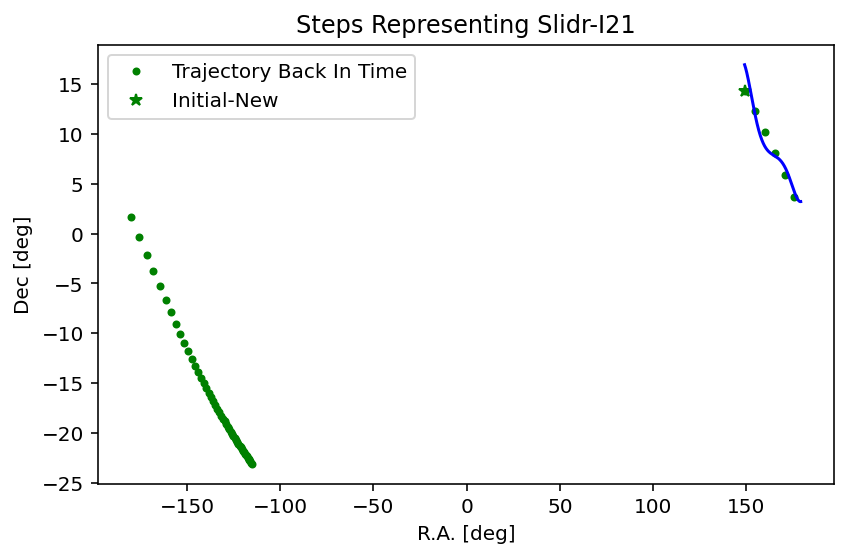

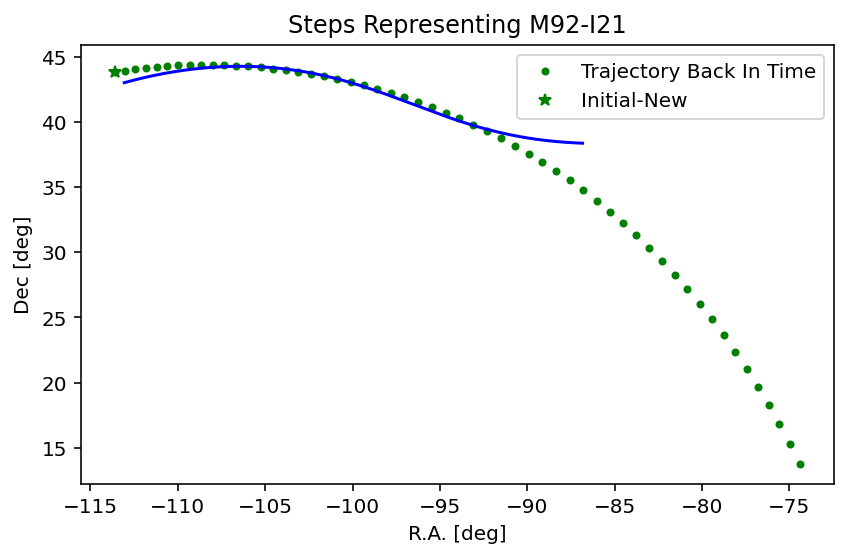

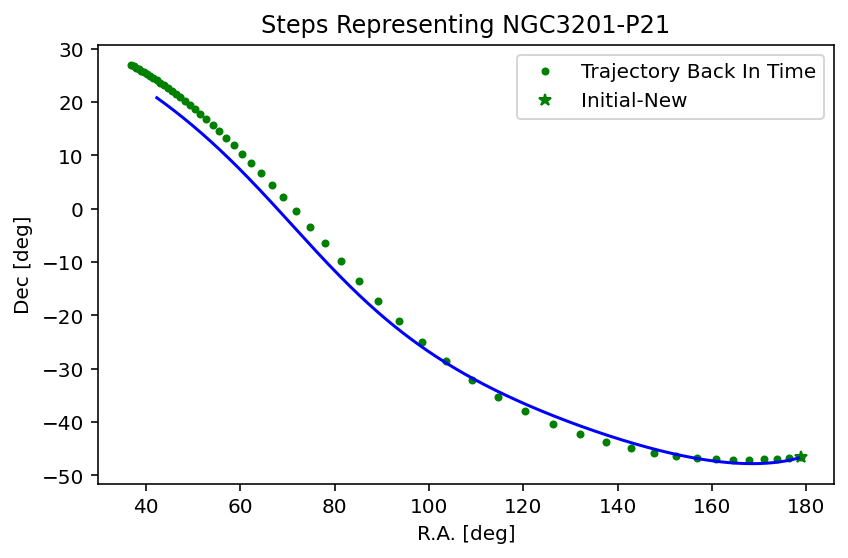

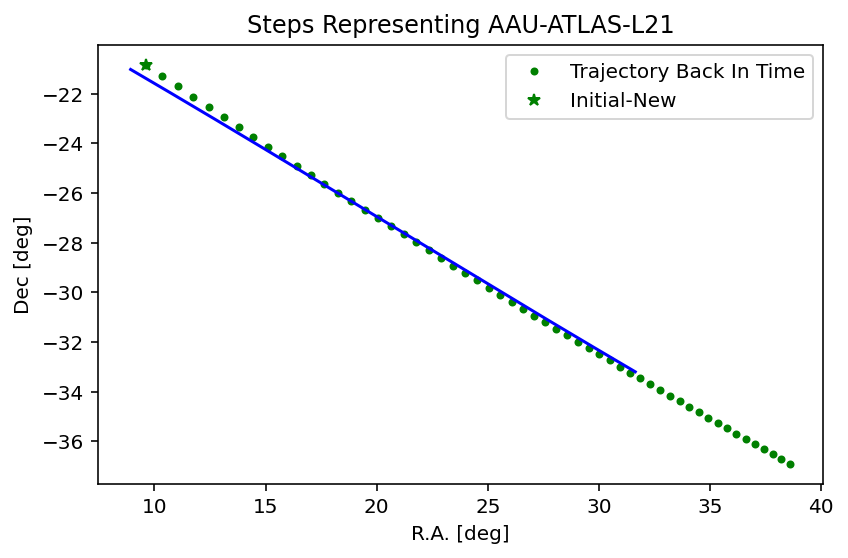

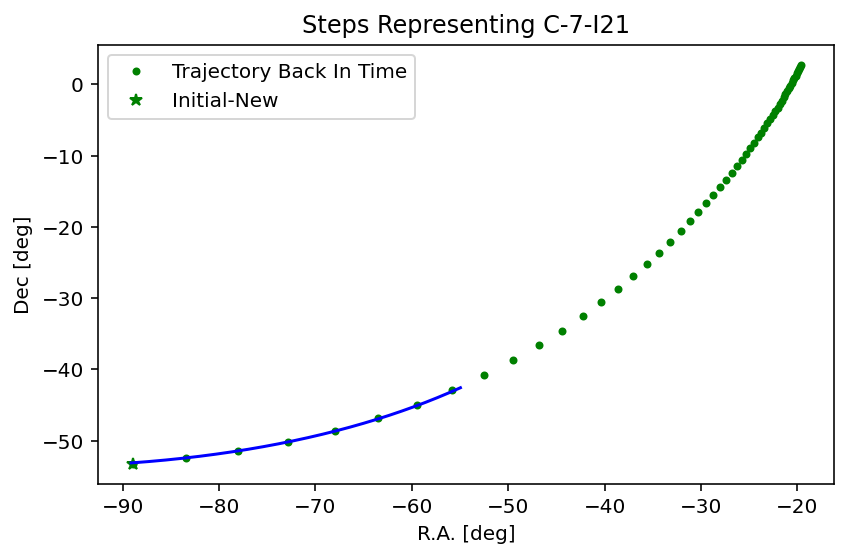

<Figure size 432x288 with 0 Axes>

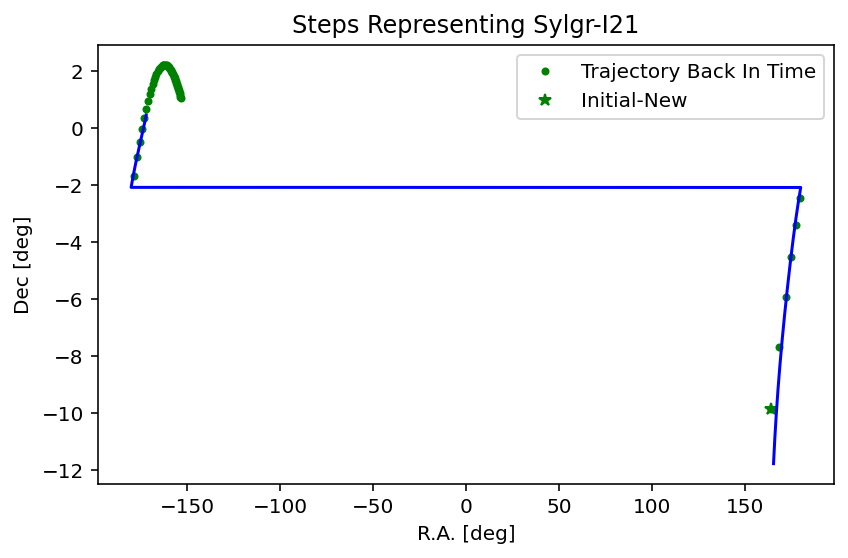

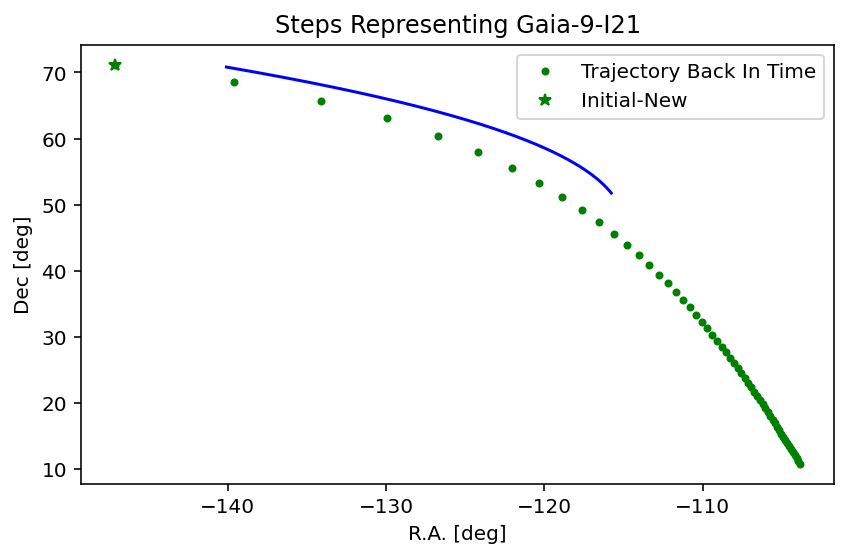

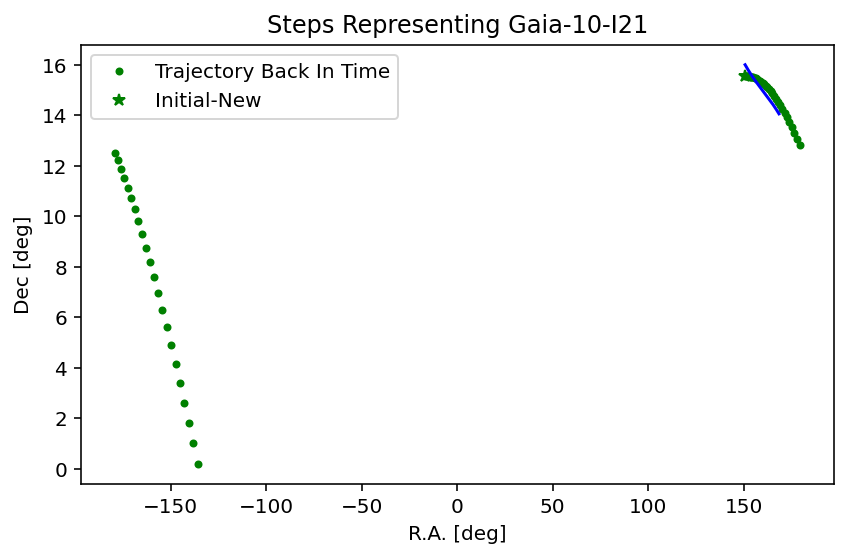

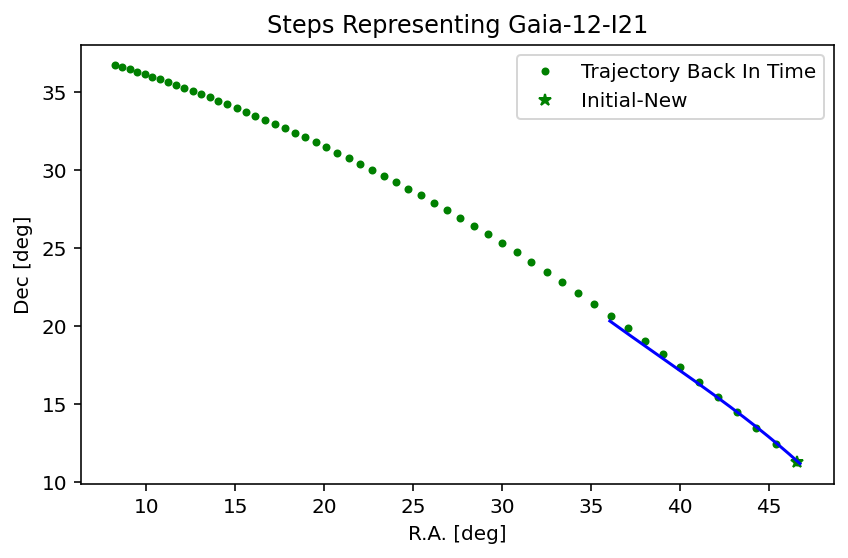

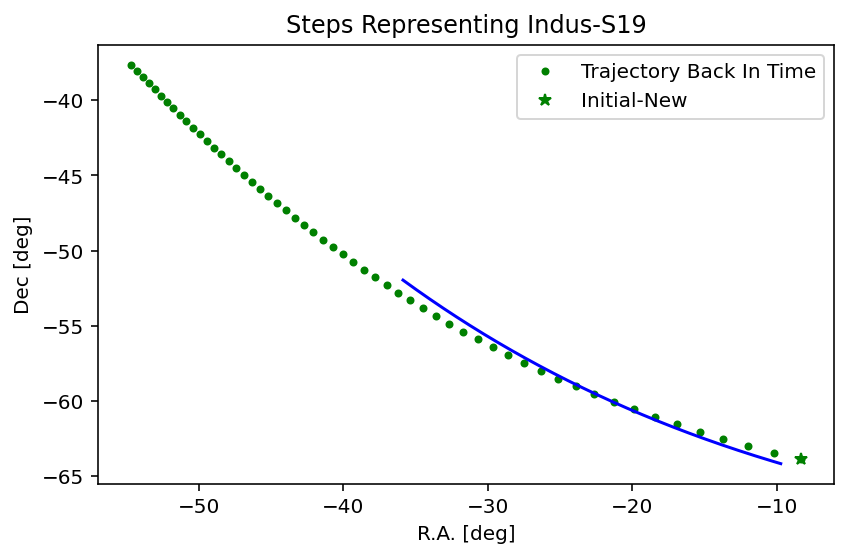

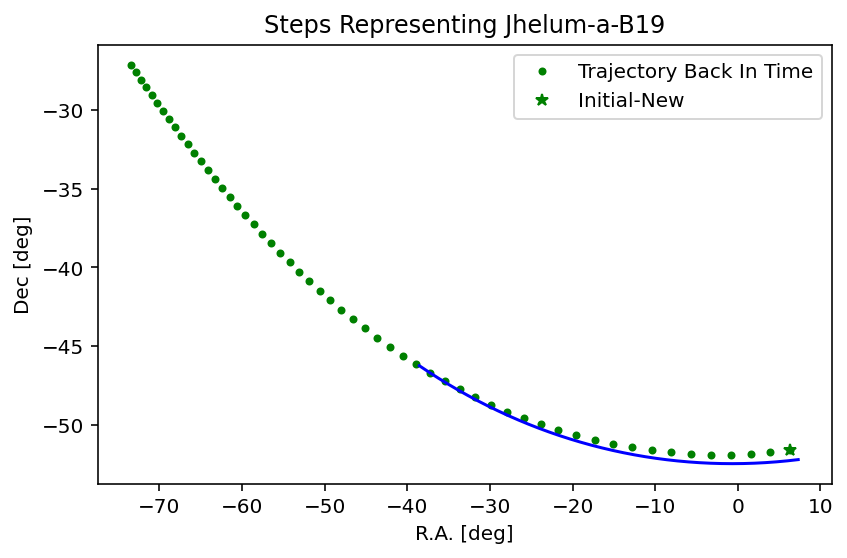

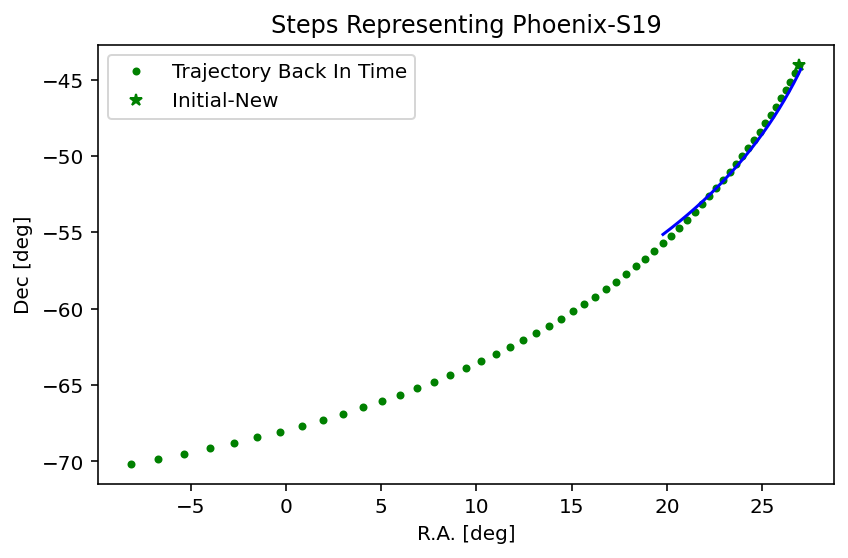

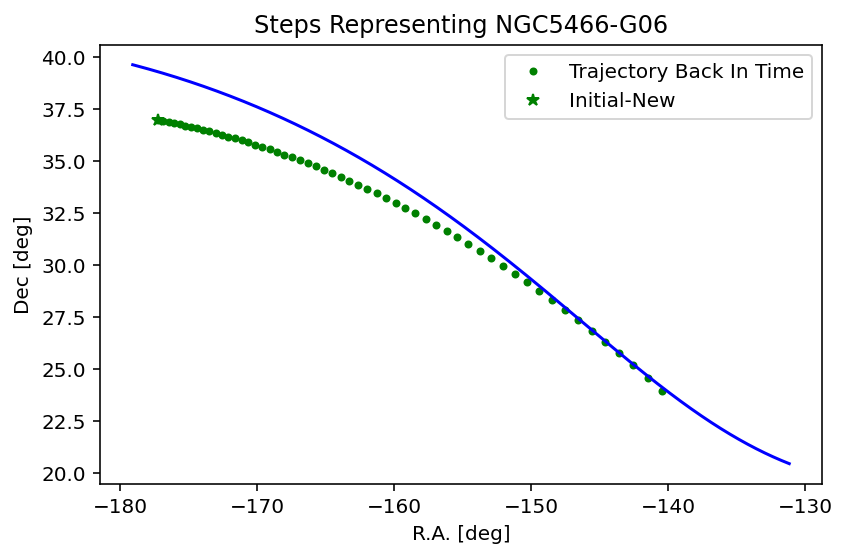

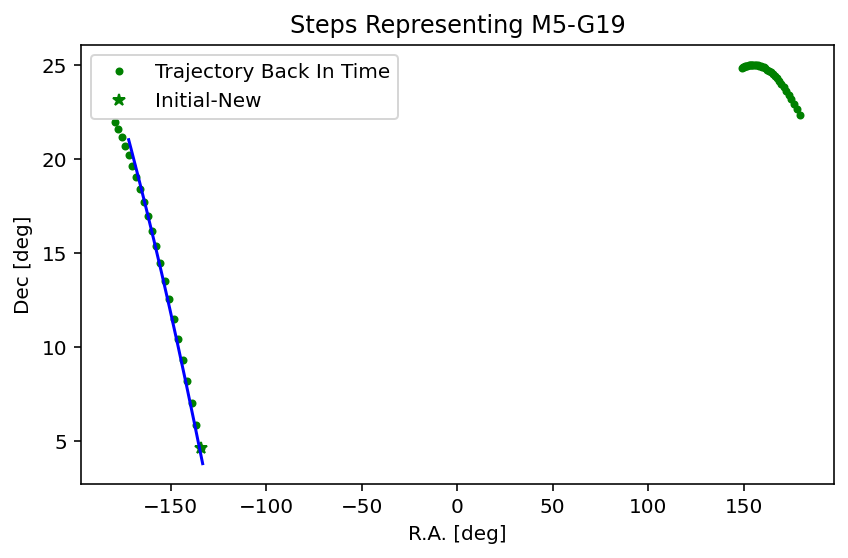

<Figure size 432x288 with 0 Axes>

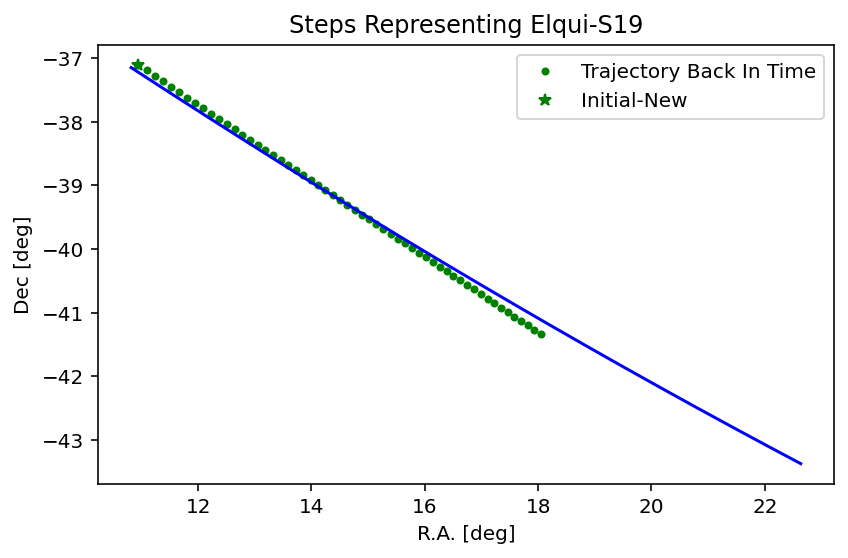

<Figure size 432x288 with 0 Axes>

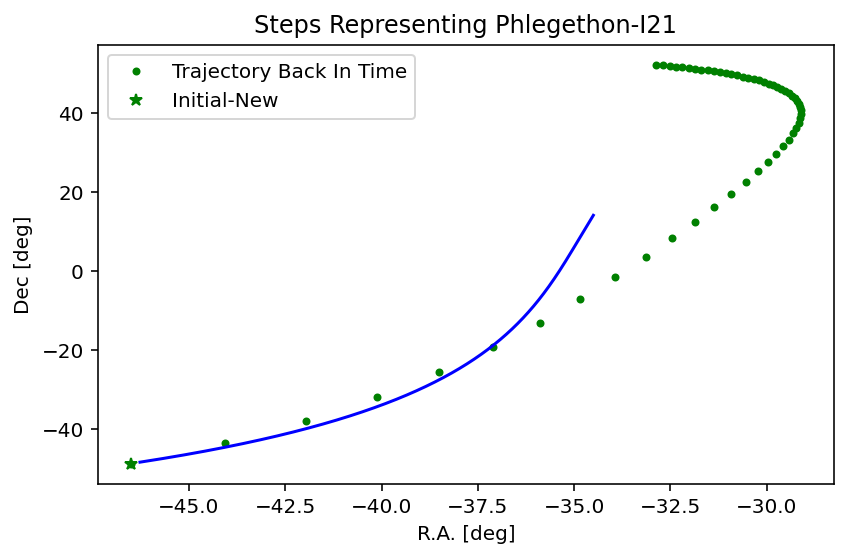

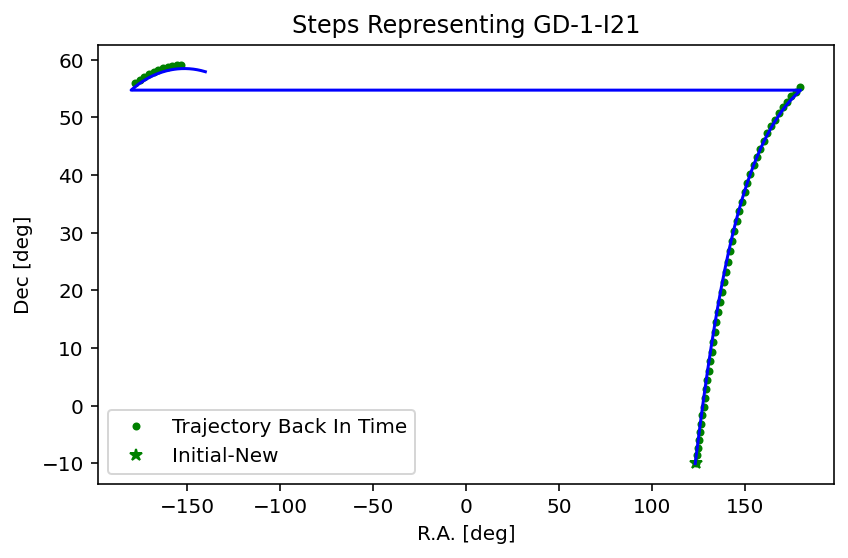

In [119]:
# define Galactocentric reference frame
coord.galactocentric_frame_defaults.set('v4.0')
gc_frame = coord.Galactocentric()
#define hamiltonian
ham = gp.Hamiltonian(gp.NFWPotential(m=MW_analog['mvir']/h*u.Msun, 
                                     r_s=(MW_analog['rs'])/h*u.kpc, units=galactic))

for i in range(len(names)):
    if list(names.values())[i] != 'None':
        c = coord.SkyCoord(ra=streams.iloc[i][1]*u.deg, dec=streams.iloc[i][2]*u.deg, distance=streams.iloc[i][3]*u.kpc, 
                           pm_ra_cosdec=streams.iloc[i][4]*u.mas/u.yr,pm_dec=streams.iloc[i][5]*u.mas/u.yr, 
                           radial_velocity=streams.iloc[i][6]*u.km/u.s, frame='icrs')
        w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)

        name=list(names.values())[i] 
        
        plt.figure()
        dt = 1*u.Myr
        if type(list(Nstep_foward_dict.values())[i]) != str:
            Nstep_foward = list(Nstep_foward_dict.values())[i]
            orbit_foward = ham.integrate_orbit(w0, dt=dt, n_steps=Nstep_foward)
            orbit_foward_icrs = orbit_foward.to_coord_frame(coord.ICRS())

#         plt.savefig('Creating_Streams_Steps/New_Initial_Pos/'+name+'_New_Initial_Pos.png', transparent=False, dpi=200)
            w0_start = gd.PhaseSpacePosition(orbit_foward.pos[-1], orbit_foward.vel[-1])
            Nstep = 55 #this is a value to guess 
            orbit = ham.integrate_orbit(w0_start, dt=-dt, n_steps=Nstep)
            orbit_sky = orbit.to_coord_frame(coord.ICRS())

            plt.plot(orbit_sky.ra.wrap_at(180*u.deg), orbit_sky.dec, '.g', label='Trajectory Back In Time')
            plt.plot(orbit_sky.ra.wrap_at(180*u.deg)[0], orbit_sky.dec[0], '*g', label='Initial-New')
            plt.plot(mwsts[name].track.ra.wrap_at(180*u.deg), mwsts[name].track.dec, 'b-')
            plt.legend(loc='best')
            plt.title('Steps Representing '+name)
            plt.xlabel('R.A. [deg]')
            plt.ylabel('Dec [deg]')
            plt.tight_layout()

            

In [120]:
Nstep_represent_dict = dict(Gjoll=36,Leiptr=29,
Hrid=12, Pal5=58, 
Gaia_1=7, Ylgr=27,
Fjorm=75, Kshir=14, 
Gunnthra=4, Slidr=5, 
M92=33, NGC_3201=43, 
Atlas=38, C_7=7, 
Palca='Unknown', Sylgr=10,
Gaia_9=9, Gaia_10=26, 
Gaia_12=10, Indus=23, 
Jhelum=21, Phoenix=22,
NGC5466=85, M5=17, 
C_20='None', C_19='Unknown',  
Elqui=85, AliqaUma='Unknown', 
Phlegethon=9, GD_1=58)

In [94]:
names

{'Gjoll': 'NGC3201-P21',
 'Leiptr': 'Leiptr-I21',
 'Hrid': 'Hrid-I21',
 'Pal5': 'Pal5-PW19',
 'Gaia_1': 'Gaia-1-I21',
 'Ylgr': 'Ylgr-I21',
 'Fjorm': 'M68-P19',
 'Kshir': 'Kshir-I21',
 'Gunnthra': 'Gunnthra-I21',
 'Slidr': 'Slidr-I21',
 'M92': 'M92-I21',
 'NGC_3201': 'NGC3201-P21',
 'Atlas': 'AAU-ATLAS-L21',
 'C_7': 'C-7-I21',
 'Palca': 'Palca-S18',
 'Sylgr': 'Sylgr-I21',
 'Gaia_9': 'Gaia-9-I21',
 'Gaia_10': 'Gaia-10-I21',
 'Gaia_12': 'Gaia-12-I21',
 'Indus': 'Indus-S19',
 'Jhelum': 'Jhelum-a-B19',
 'Phoenix': 'Phoenix-S19',
 'NGC5466': 'NGC5466-G06',
 'M5': 'M5-G19',
 'C_20': 'None',
 'C_19': 'C-19-I21',
 'Elqui': 'Elqui-S19',
 'AliqaUma': 'AAU-AliqaUma-L21',
 'Phlegethon': 'Phlegethon-I21',
 'GD_1': 'GD-1-I21'}

In [195]:
Nstep_represent_dict

{'Gjoll': 36,
 'Leiptr': 29,
 'Hrid': 12,
 'Pal5': 58,
 'Gaia_1': 7,
 'Ylgr': 27,
 'Fjorm': 75,
 'Kshir': 14,
 'Gunnthra': 4,
 'Slidr': 5,
 'M92': 33,
 'NGC_3201': 43,
 'Atlas': 38,
 'C_7': 7,
 'Palca': 'Unknown',
 'Sylgr': 10,
 'Gaia_9': 9,
 'Gaia_10': 26,
 'Gaia_12': 10,
 'Indus': 23,
 'Jhelum': 21,
 'Phoenix': 22,
 'NGC5466': 85,
 'M5': 17,
 'C_20': 'None',
 'C_19': 'Unknown',
 'Elqui': 85,
 'AliqaUma': 'Unknown',
 'Phlegethon': 9,
 'GD_1': 58}

In [198]:
list(Nstep_represent_dict)[24]

'C_20'

In [176]:
for i in range(len(list(names.values())[i])):
    if list(names.values())[i] == 'None':
        print(i)

In [231]:
Nstep_foward_dict.values()

dict_values([20, 10, 8, 19, 3, 12, 4, 3, 1, 2, 20, 8, 25, 3, 'Unknown', 5, 4, 17, 5, 7, 6, 11, 50, 8, 'None', 'Unknown', 70, 'Unknown', 3, 35])

In [232]:
# define Galactocentric reference frame
coord.galactocentric_frame_defaults.set('v4.0')
gc_frame = coord.Galactocentric()

#define hamiltonian
ham = gp.Hamiltonian(gp.NFWPotential(m=MW_analog['mvir']/h*u.Msun, 
                                     r_s=(MW_analog['rs'])/h*u.kpc, units=galactic))

def ClosestDist_new(streams):
    #Information for Stream 
    closest_dist1 = pd.DataFrame()
    for i in range(len(names)):
        if (list(names.values())[i] != 'None') & (list(Nstep_foward_dict.values())[i] != 'None' or 'Unknown'):
            c = coord.SkyCoord(ra=streams.iloc[i][1]*u.deg, dec=streams.iloc[i][2]*u.deg, distance=streams.iloc[i][3]*u.kpc, 
                               pm_ra_cosdec=streams.iloc[i][4]*u.mas/u.yr,pm_dec=streams.iloc[i][5]*u.mas/u.yr, 
                               radial_velocity=streams.iloc[i][6]*u.km/u.s, frame='icrs')
            w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)

            dt = 1*u.Myr
            Nstep_foward = list(Nstep_foward_dict.values())[i]
            orbit_foward = ham.integrate_orbit(w0, dt=dt, n_steps=Nstep_foward)
            orbit_foward_icrs = orbit_foward.to_coord_frame(coord.ICRS())

            w0_start = gd.PhaseSpacePosition(orbit_foward.pos[-1], orbit_foward.vel[-1])
            Nstep = list(Nstep_represent_dict.values())[i] 
            orbit = ham.integrate_orbit(w0_start, dt=-dt, n_steps=Nstep)
            orbit_sky = orbit.to_coord_frame(coord.ICRS())
            
            #Going back for 3 Gyrs (3000 steps of -1Myr)
            Nstep_long = 3000
            orbit_long = ham.integrate_orbit(w0_start, dt=-dt, n_steps=Nstep_long)

    
        
            data_new = {'Stream':[str(streams.iloc[i]['Stream'])]}
            data_temp = pd.DataFrame(data=data_new)
            for subh in range(len(trot['x'])): #subh stands for individual subhalo
                dist_x = orbit_long.pos.x - rot_orbits[subh,:,0]*u.kpc 
                dist_y = orbit_long.pos.y - rot_orbits[subh,:,1]*u.kpc
                dist_z = orbit_long.pos.z - rot_orbits[subh,:,2]*u.kpc
                rel_dist = np.sqrt((dist_x**2) + (dist_y**2) + (dist_z**2))
                closest_dist2 = np.min(rel_dist)

                #For time
                time_occurance = -dt*np.argmin(rel_dist)

                #For velocity 
                ind_time = np.argmin(rel_dist)
                vel_x = orbit_long.vel.d_x.to(u.km/u.s) - rot_orbits_vel[subh,:,0]*(u.km/u.s) 
                vel_y = orbit_long.vel.d_y.to(u.km/u.s) - rot_orbits_vel[subh,:,1]*(u.km/u.s)
                vel_z = orbit_long.vel.d_z.to(u.km/u.s) - rot_orbits_vel[subh,:,2]*(u.km/u.s)
                rel_vel = np.sqrt((vel_x**2) + (vel_y**2) + (vel_z**2))

                data_temp['Subhalo_'+ str(subh)+ ' Distance (kpc)'] = [closest_dist2.value]
                data_temp['Subhalo_'+ str(subh)+ ' Time (Myr)'] = [time_occurance.value]
                data_temp['Subhalo_'+ str(subh)+ ' Relative Velocity (km/s)'] = [rel_vel[ind_time].value]
            
        closest_dist1 = closest_dist1.append(data_temp, ignore_index=True)
    return closest_dist1




In [233]:
pb= ClosestDist_new(streams)
pb

ValueError: invalid literal for int() with base 10: 'Unknown'

In [225]:
# # define Galactocentric reference frame
# coord.galactocentric_frame_defaults.set('v4.0')
# gc_frame = coord.Galactocentric()

# #define hamiltonian
# ham = gp.Hamiltonian(gp.NFWPotential(m=MW_analog['mvir']/h*u.Msun, 
#                                      r_s=(MW_analog['rs'])/h*u.kpc, units=galactic))

# def ClosestDist_new(streams):
#     #Information for Stream 
#     closest_dist1 = pd.DataFrame()
#     for i in range(len(names)):
#         if list(names.values())[i] != 'None':
#             c = coord.SkyCoord(ra=streams.iloc[i][1]*u.deg, dec=streams.iloc[i][2]*u.deg, distance=streams.iloc[i][3]*u.kpc, 
#                                pm_ra_cosdec=streams.iloc[i][4]*u.mas/u.yr,pm_dec=streams.iloc[i][5]*u.mas/u.yr, 
#                                radial_velocity=streams.iloc[i][6]*u.km/u.s, frame='icrs')
#             w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)

#             dt = 1*u.Myr
#             Nstep_foward = list(Nstep_foward_dict.values())[i]
#             orbit_foward = ham.integrate_orbit(w0, dt=dt, n_steps=Nstep_foward)
#             orbit_foward_icrs = orbit_foward.to_coord_frame(coord.ICRS())

#             w0_start = gd.PhaseSpacePosition(orbit_foward.pos[-1], orbit_foward.vel[-1])
#             Nstep = list(Nstep_represent_dict.values())[i] 
#             orbit = ham.integrate_orbit(w0_start, dt=-dt, n_steps=Nstep)
#             orbit_sky = orbit.to_coord_frame(coord.ICRS())
            
#             #Going back for 3 Gyrs (3000 steps of -1Myr)
#             Nstep_long = 3000
#             orbit_long = ham.integrate_orbit(w0_start, dt=-dt, n_steps=Nstep_long)

    
        
#             data_new = {'Stream':[str(streams.iloc[i]['Stream'])]}
#             data_temp = pd.DataFrame(data=data_new)
#             for subh in range(len(trot['x'])): #subh stands for individual subhalo
#                 dist_x = orbit_long.pos.x - rot_orbits[subh,:,0]*u.kpc 
#                 dist_y = orbit_long.pos.y - rot_orbits[subh,:,1]*u.kpc
#                 dist_z = orbit_long.pos.z - rot_orbits[subh,:,2]*u.kpc
#                 rel_dist = np.sqrt((dist_x**2) + (dist_y**2) + (dist_z**2))
#                 closest_dist2 = np.min(rel_dist)

#                 #For time
#                 time_occurance = -dt*np.argmin(rel_dist)

#                 #For velocity 
#                 ind_time = np.argmin(rel_dist)
#                 vel_x = orbit_long.vel.d_x.to(u.km/u.s) - rot_orbits_vel[subh,:,0]*(u.km/u.s) 
#                 vel_y = orbit_long.vel.d_y.to(u.km/u.s) - rot_orbits_vel[subh,:,1]*(u.km/u.s)
#                 vel_z = orbit_long.vel.d_z.to(u.km/u.s) - rot_orbits_vel[subh,:,2]*(u.km/u.s)
#                 rel_vel = np.sqrt((vel_x**2) + (vel_y**2) + (vel_z**2))

#                 data_temp['Subhalo_'+ str(subh)+ ' Distance (kpc)'] = [closest_dist2.value]
#                 data_temp['Subhalo_'+ str(subh)+ ' Time (Myr)'] = [time_occurance.value]
#                 data_temp['Subhalo_'+ str(subh)+ ' Relative Velocity (km/s)'] = [rel_vel[ind_time].value]

#         closest_dist1 = closest_dist1.append(data_temp, ignore_index=True)
#     return closest_dist1

# #             if list(names.values())[i] != 'None':
# #                 closest_dist1 = closest_dist1.append(data_temp, ignore_index=True)
# #                 return closest_dist1

In [123]:
# ##ORIGINALLLLLL

# # define Galactocentric reference frame
# coord.galactocentric_frame_defaults.set('v4.0')
# gc_frame = coord.Galactocentric()

# #define hamiltonian
# ham = gp.Hamiltonian(gp.NFWPotential(m=MW_analog['mvir']/h*u.Msun, 
#                                      r_s=(MW_analog['rs'])/h*u.kpc, units=galactic))

# def ClosestDist(streams):
#     #Information for Stream 
#     closest_dist1 = pd.DataFrame()
#     for i in range(len(streams)): #goes through every stream
#         c = coord.SkyCoord(ra=streams.iloc[i]['ra']*u.deg, dec=streams.iloc[i]['dec']*u.deg, 
#                            distance=streams.iloc[i]['distance']*u.kpc, pm_ra_cosdec=streams.iloc[i]['pm_ra_cosdec']*u.mas/u.yr,
#                            pm_dec=streams.iloc[i]['pm_dec']*u.mas/u.yr, radial_velocity=streams.iloc[i]['radial_velocity']*u.km/u.s, frame='icrs')

#         w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)


#         dt = 1*u.Myr
#         Nstep_foward = 2
#         orbit_foward = ham.integrate_orbit(w0, dt=dt, n_steps=Nstep_foward)
#         orbit_foward_icrs = orbit_foward.to_coord_frame(coord.ICRS())

#         w0_start = gd.PhaseSpacePosition(orbit_foward.pos[-1], orbit_foward.vel[-1])
#         Nstep = 7
#         orbit = ham.integrate_orbit(w0_start, dt=-dt, n_steps=Nstep)
#         orbit_sky = orbit.to_coord_frame(coord.ICRS())
        
#         #Going back for 3 Gyrs (3000 steps of -1Myr)
#         Nstep_long = 3000
#         orbit_long = ham.integrate_orbit(w0_start, dt=-dt, n_steps=Nstep_long)

        
        
#         data_new = {'Stream':[str(streams.iloc[i]['Stream'])]}
#         data_temp = pd.DataFrame(data=data_new)
#         for subh in range(len(trot['x'])): #subh stands for individual subhalo
#             dist_x = orbit_long.pos.x - rot_orbits[subh,:,0]*u.kpc 
#             dist_y = orbit_long.pos.y - rot_orbits[subh,:,1]*u.kpc
#             dist_z = orbit_long.pos.z - rot_orbits[subh,:,2]*u.kpc
#             rel_dist = np.sqrt((dist_x**2) + (dist_y**2) + (dist_z**2))
#             closest_dist2 = np.min(rel_dist)
            
#             #For time
#             time_occurance = -dt*np.argmin(rel_dist)
            
#             #For velocity 
#             ind_time = np.argmin(rel_dist)
#             vel_x = orbit_long.vel.d_x.to(u.km/u.s) - rot_orbits_vel[subh,:,0]*(u.km/u.s) 
#             vel_y = orbit_long.vel.d_y.to(u.km/u.s) - rot_orbits_vel[subh,:,1]*(u.km/u.s)
#             vel_z = orbit_long.vel.d_z.to(u.km/u.s) - rot_orbits_vel[subh,:,2]*(u.km/u.s)
#             rel_vel = np.sqrt((vel_x**2) + (vel_y**2) + (vel_z**2))
            
#             data_temp['Subhalo_'+ str(subh)+ ' Distance (kpc)'] = [closest_dist2.value]
#             data_temp['Subhalo_'+ str(subh)+ ' Time (Myr)'] = [time_occurance.value]
#             data_temp['Subhalo_'+ str(subh)+ ' Relative Velocity (km/s)'] = [rel_vel[ind_time].value]
            
#         closest_dist1 = closest_dist1.append(data_temp, ignore_index=True)
#     return closest_dist1




In [30]:
#pb = ClosestDist(streams)
#pb

Stream  Subhalo_0 Distance (kpc)  Subhalo_0 Time (Myr)  \
0        Gjoll                 23.418654                -287.0   
1       Leiptr                  8.075946                -329.0   
2         Hrid                 54.796486                -325.0   
3         Pal5                 33.962001                -223.0   
4       Gaia_1                 30.611827                -405.0   
5         Ylgr                 31.574246                -281.0   
6        Fjorm                 58.666359                -189.0   
7        Kshir                 41.470491                -244.0   
8     Gunnthra                 38.755451                -293.0   
9        Slidr                 41.036184                -301.0   
10         M92                 34.570465                -306.0   
11    NGC_3201                 11.796747                -307.0   
12       Atlas                 35.003437                -160.0   
13         C_7                 16.504717                -297.0   
14       Palca                 35.056198                -327.0   
15       Sylgr                 53.156212                -345.0   
16      Gaia_9                 47.914782                -286.0   
17     Gaia_10                 34.506814                -259.0   
18     Gaia_12                 49.108634                -413.0   
19       Indus                 49.354602                -296.0   
20      Jhelum                 53.039738                -326.0   
21     Phoenix                 41.578833                -331.0   
22     NGC5466                 23.328708                -220.0   
23          M5                 43.031747                -294.0   
24        C_20                 29.714292                -150.0   
25        C_19                 52.765472                -250.0   
26       Elqui                  9.720509                -158.0   
27    AliqaUma                 37.295617                -155.0   
28  Phlegethon                 37.451702                -304.0   
29        GD_1                 43.480403                -280.0   

    Subhalo_0 Relative Velocity (km/s)  Subhalo_1 Distance (kpc)  \
0                           535.449884                 88.090466   
1                           443.922337                 97.549989   
2                           435.146645                 97.453298   
3                           561.342650                107.766900   
4                           441.321231                 81.579544   
5                           636.041846                102.736961   
6                           461.360785                 94.740331   
7                           632.240152                102.753624   
8                           408.741276                110.538472   
9                           511.147252                103.437170   
10                          467.103347                108.097168   
11                          471.419281                 89.068789   
12                          445.319680                 98.618591   
13                          487.090181                 98.088000   
14                          574.605860                104.262870   
15                          605.733687                 89.813475   
16                          567.750865                102.663708   
17                          475.927630                 91.476524   
18                          296.656025                 56.779702   
19                          629.360092                100.078397   
20                          637.653561                 93.268970   
21                          564.091712                102.283769   
22                          473.308118                 89.237142   
23                          523.177096                 91.393205   
24                          600.069524                 87.532404   
25                          593.613418                 98.008463   
26                          425.962978                 78.170147   
27                          429.071979                 98

In [171]:
pb.to_csv('Closest_Distance_Subhalo_to_All_Streams.csv', index='False')

In [172]:
pb = pd.read_csv('Closest_Distance_Subhalo_to_All_Streams.csv')
pb = pb.drop("Unnamed: 0",axis=1)

In [173]:
pb

Stream  Subhalo_0 Distance (kpc)  Subhalo_0 Time (Myr)  \
0        Gjoll                 23.418654                -287.0   
1       Leiptr                  8.075946                -329.0   
2         Hrid                 54.796486                -325.0   
3         Pal5                 33.962001                -223.0   
4       Gaia_1                 30.611827                -405.0   
5         Ylgr                 31.574246                -281.0   
6        Fjorm                 58.666359                -189.0   
7        Kshir                 41.470491                -244.0   
8     Gunnthra                 38.755451                -293.0   
9        Slidr                 41.036184                -301.0   
10         M92                 34.570465                -306.0   
11    NGC_3201                 11.796747                -307.0   
12       Atlas                 35.003437                -160.0   
13         C_7                 16.504717                -297.0   
14       Palca                 35.056198                -327.0   
15       Sylgr                 53.156212                -345.0   
16      Gaia_9                 47.914782                -286.0   
17     Gaia_10                 34.506814                -259.0   
18     Gaia_12                 49.108634                -413.0   
19       Indus                 49.354602                -296.0   
20      Jhelum                 53.039738                -326.0   
21     Phoenix                 41.578833                -331.0   
22     NGC5466                 23.328708                -220.0   
23          M5                 43.031747                -294.0   
24        C_20                 29.714292                -150.0   
25        C_19                 52.765472                -250.0   
26       Elqui                  9.720509                -158.0   
27    AliqaUma                 37.295617                -155.0   
28  Phlegethon                 37.451702                -304.0   
29        GD_1                 43.480403                -280.0   

    Subhalo_0 Relative Velocity (km/s)  Subhalo_1 Distance (kpc)  \
0                           535.449884                 88.090466   
1                           443.922337                 97.549989   
2                           435.146645                 97.453298   
3                           561.342650                107.766900   
4                           441.321231                 81.579544   
5                           636.041846                102.736961   
6                           461.360785                 94.740331   
7                           632.240152                102.753624   
8                           408.741276                110.538472   
9                           511.147252                103.437170   
10                          467.103347                108.097168   
11                          471.419281                 89.068789   
12                          445.319680                 98.618591   
13                          487.090181                 98.088000   
14                          574.605860                104.262870   
15                          605.733687                 89.813475   
16                          567.750865                102.663708   
17                          475.927630                 91.476524   
18                          296.656025                 56.779702   
19                          629.360092                100.078397   
20                          637.653561                 93.268970   
21                          564.091712                102.283769   
22                          473.308118                 89.237142   
23                          523.177096                 91.393205   
24                          600.069524                 87.532404   
25                          593.613418                 98.008463   
26                          425.962978                 78.170147   
27                          429.071979                 98

<ipython-input-174-eba4f193662b>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


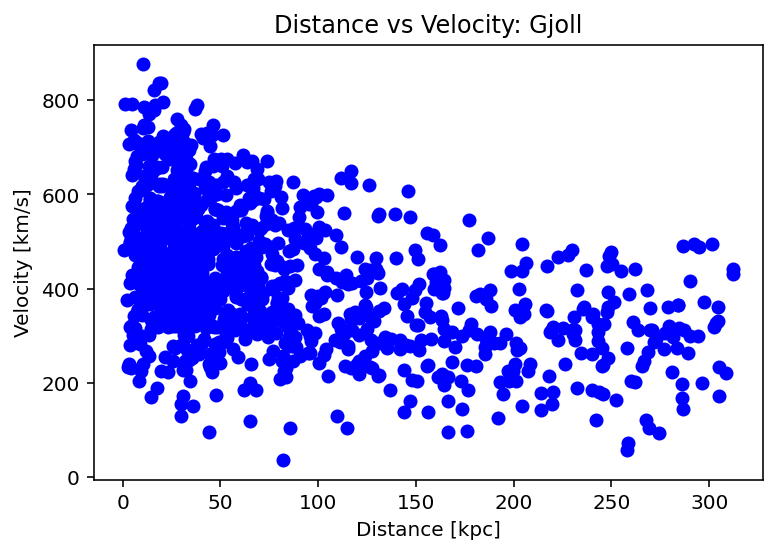

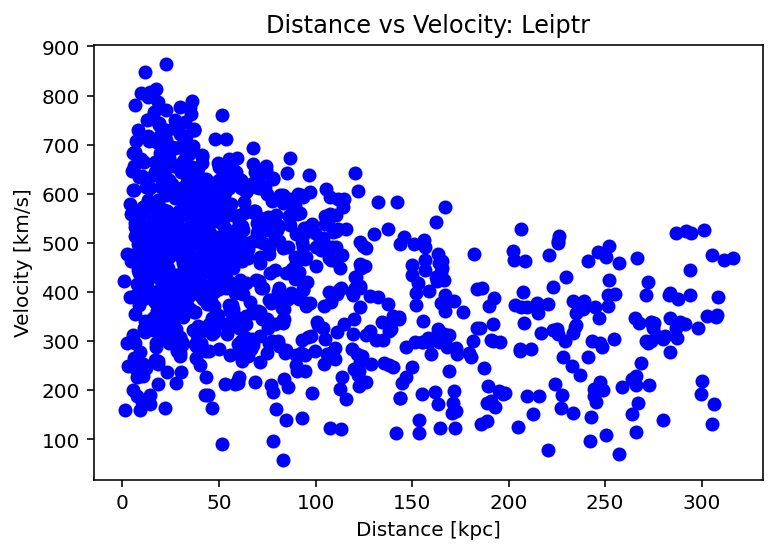

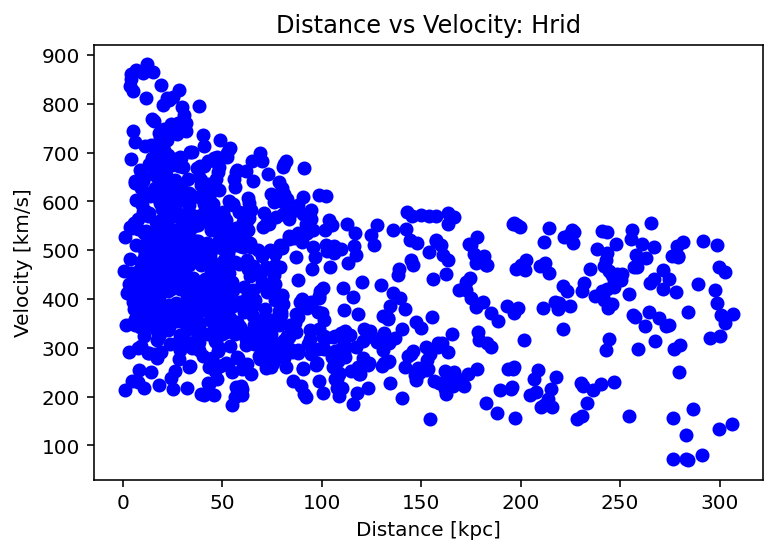

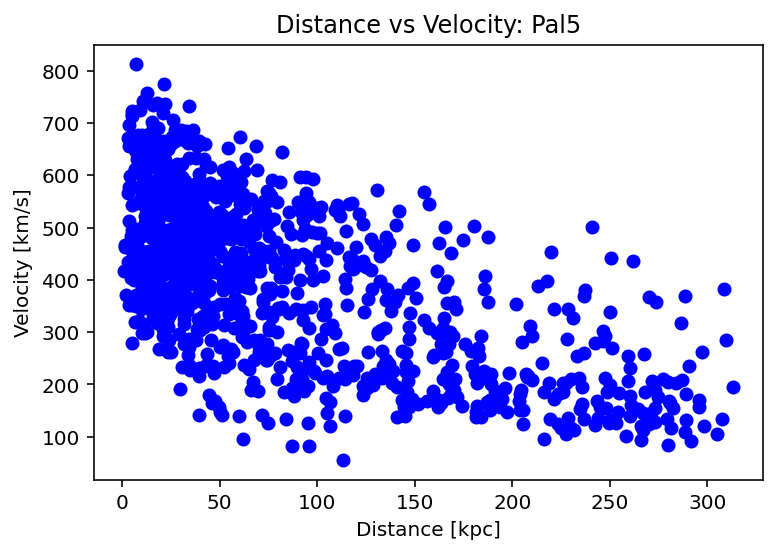

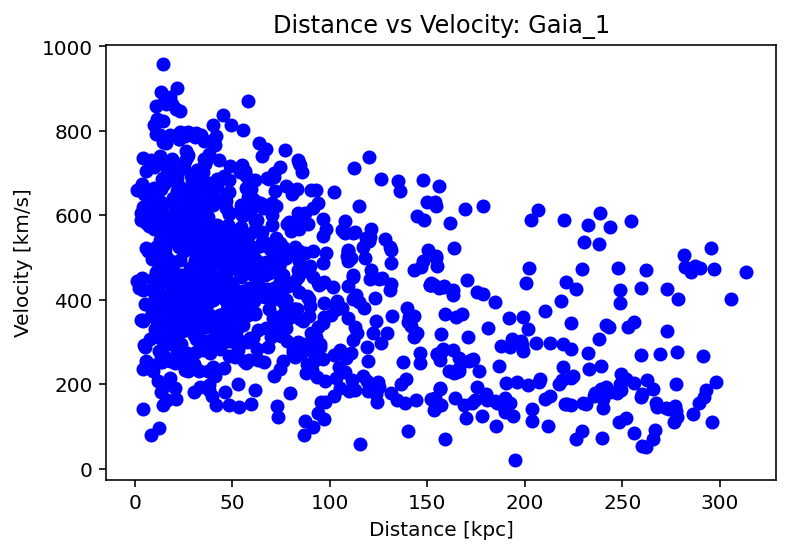

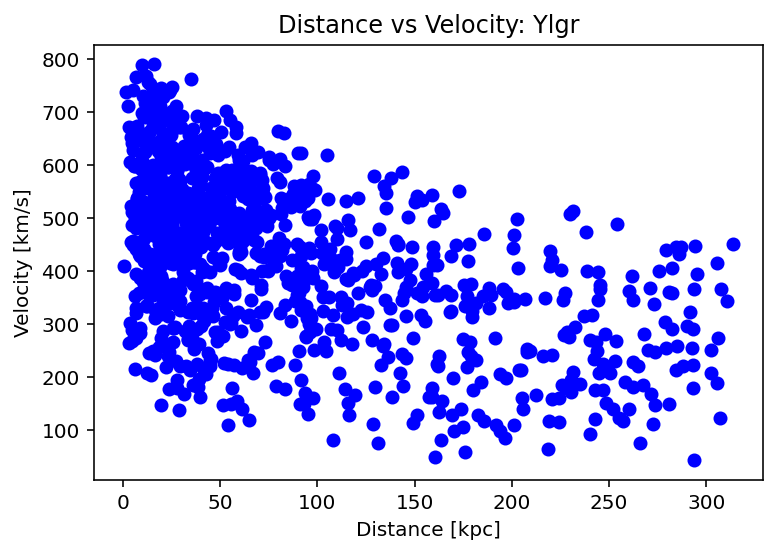

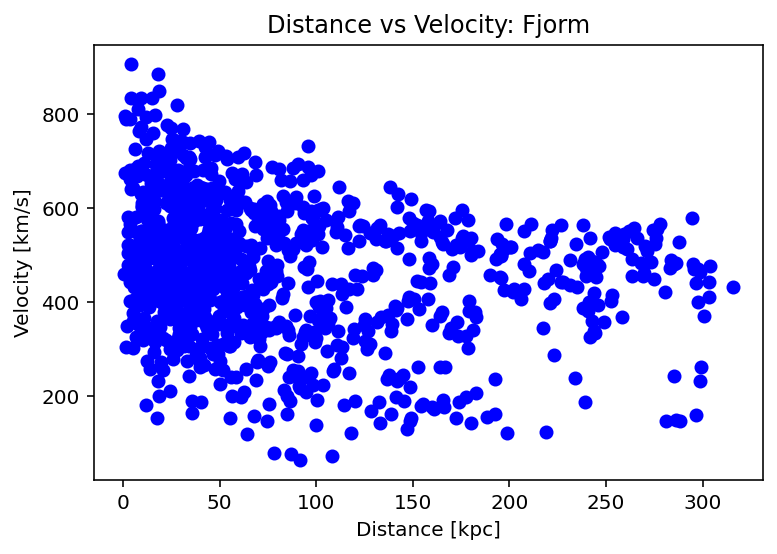

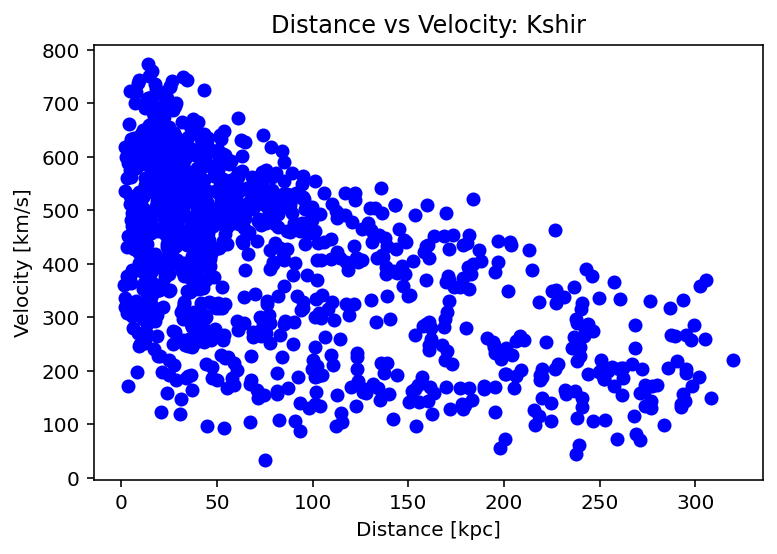

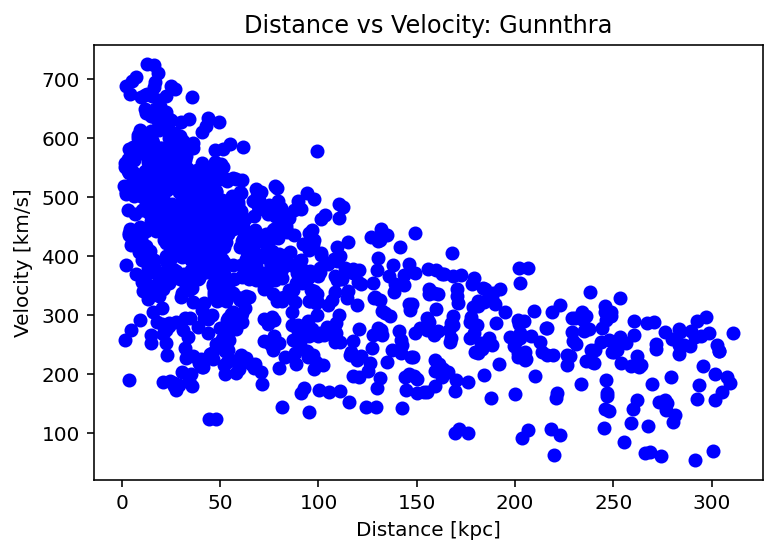

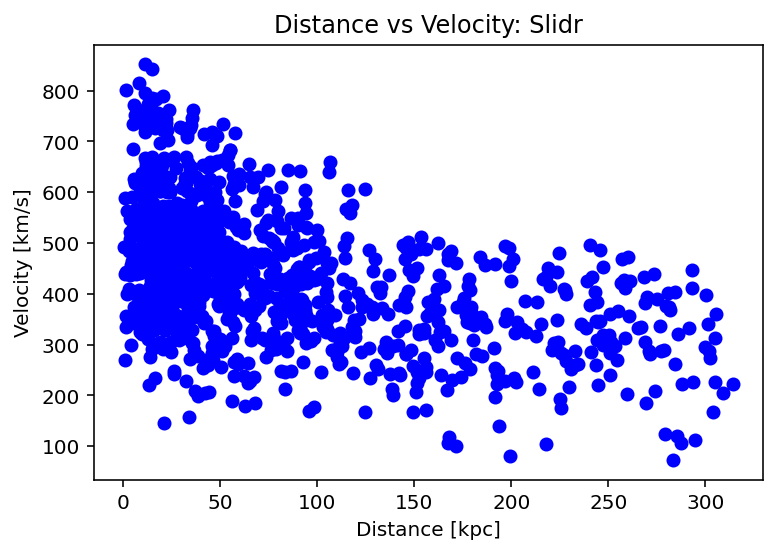

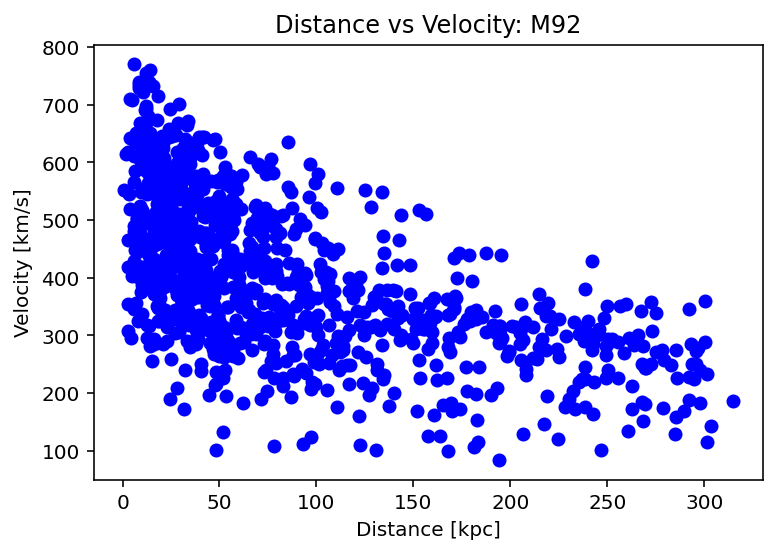

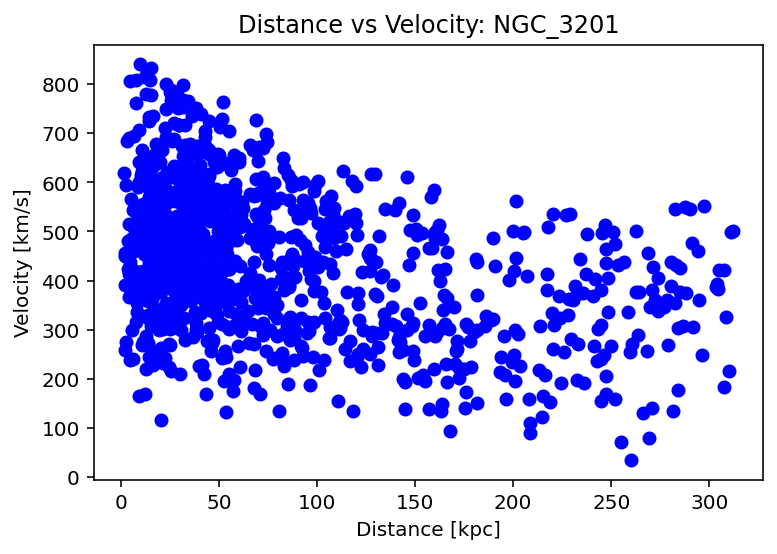

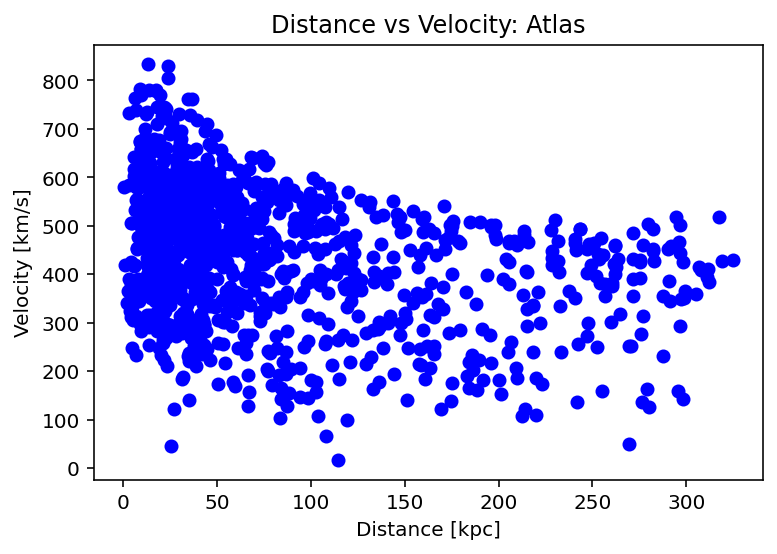

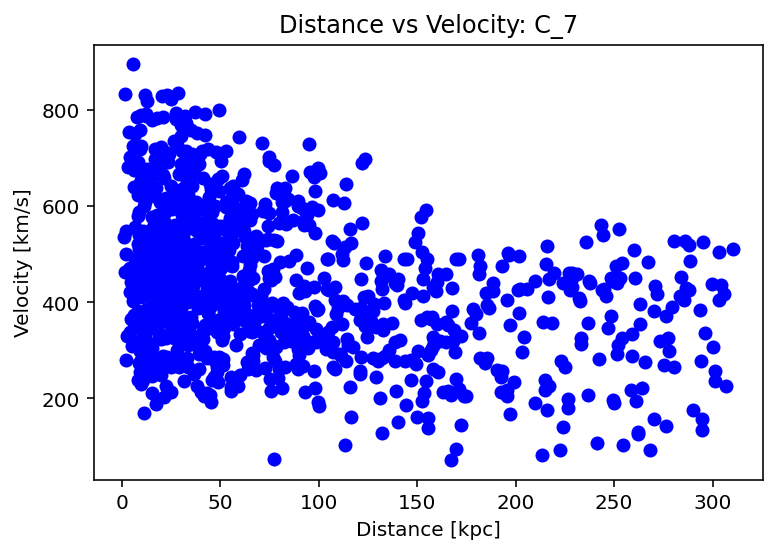

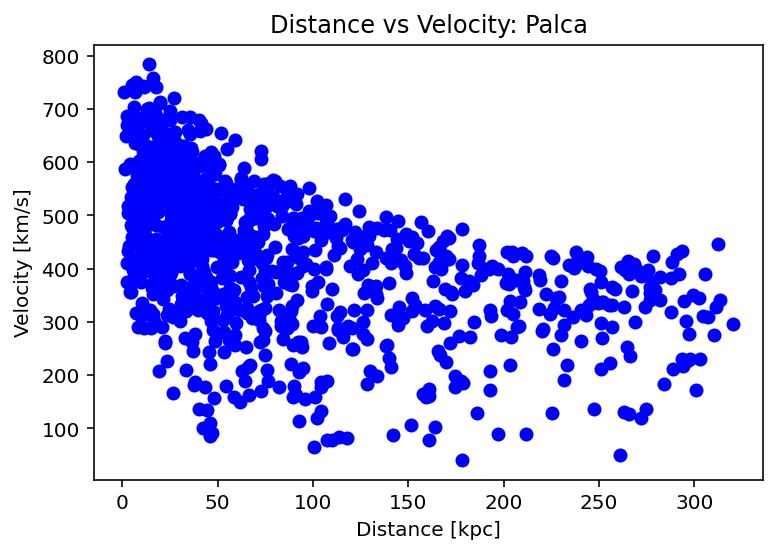

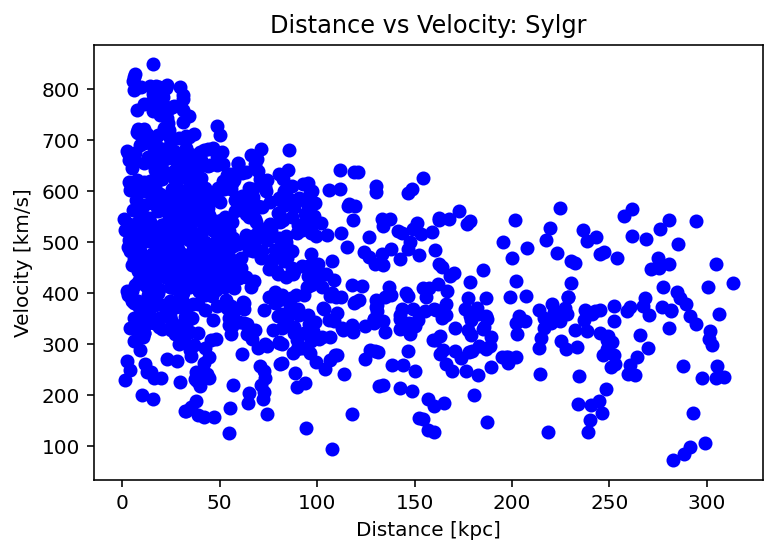

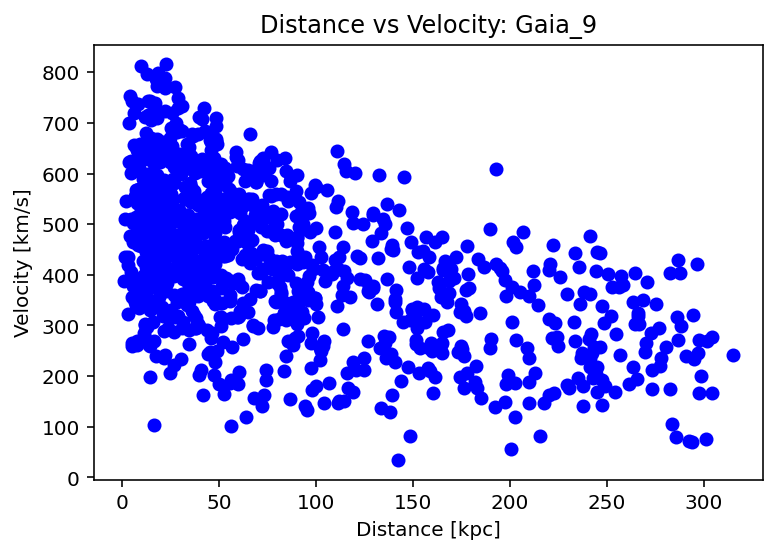

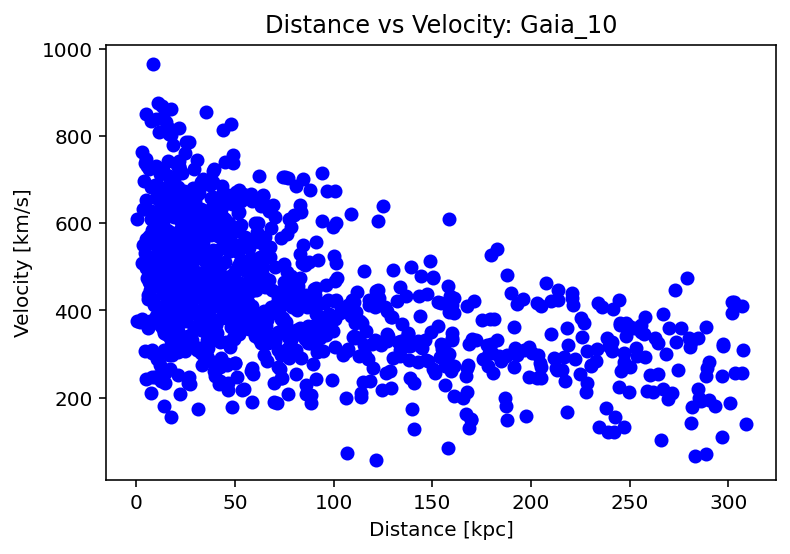

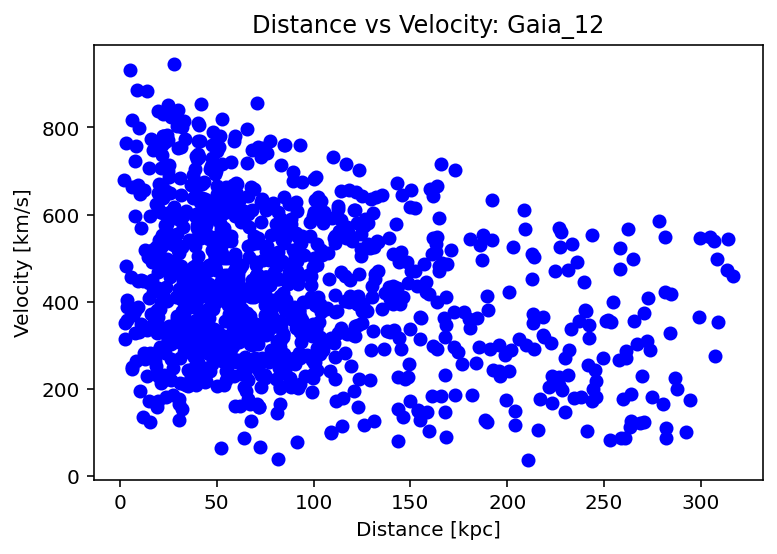

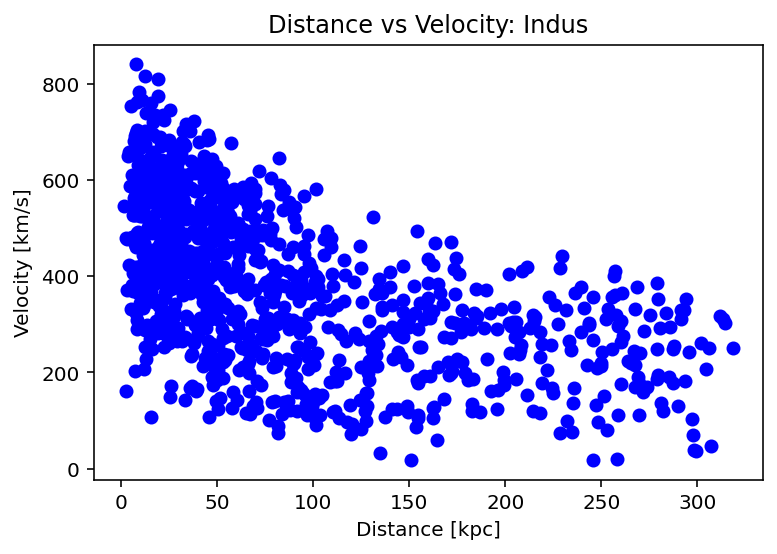

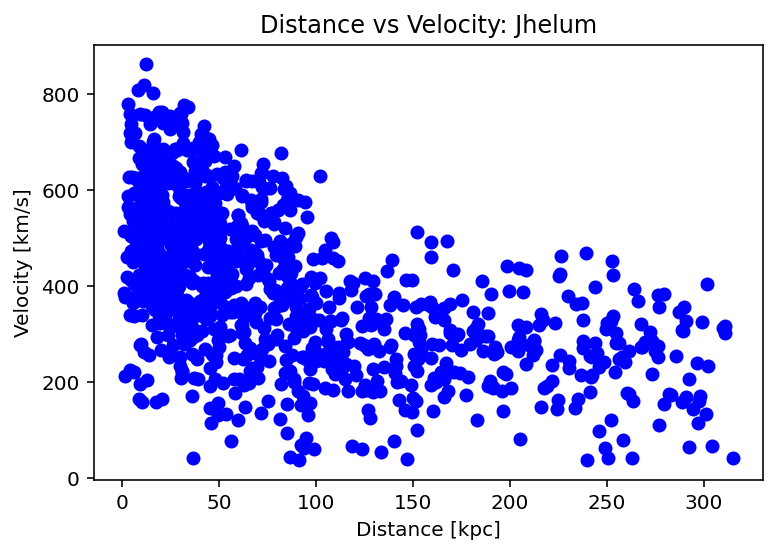

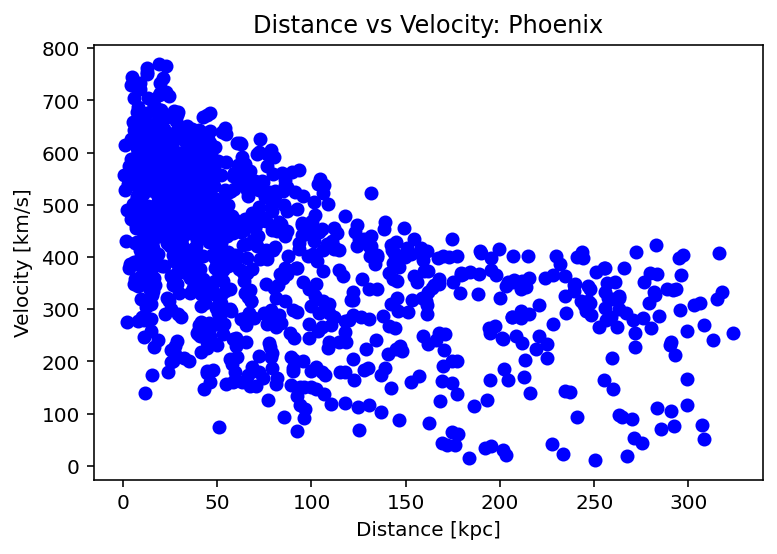

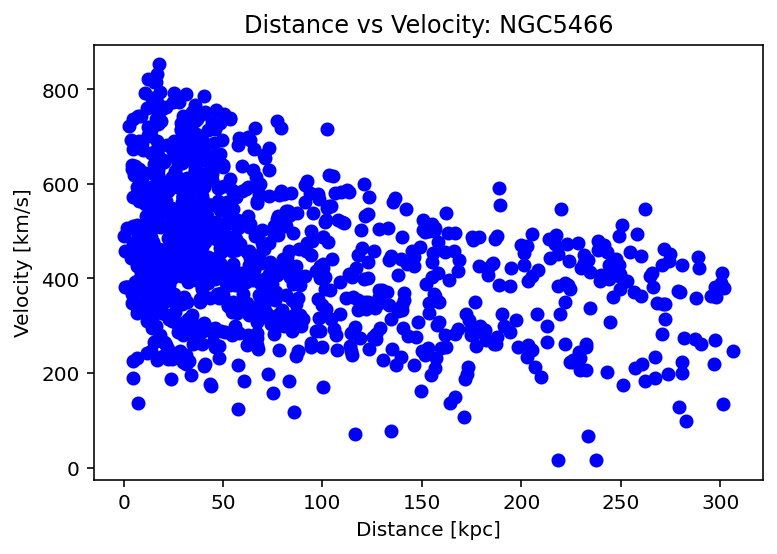

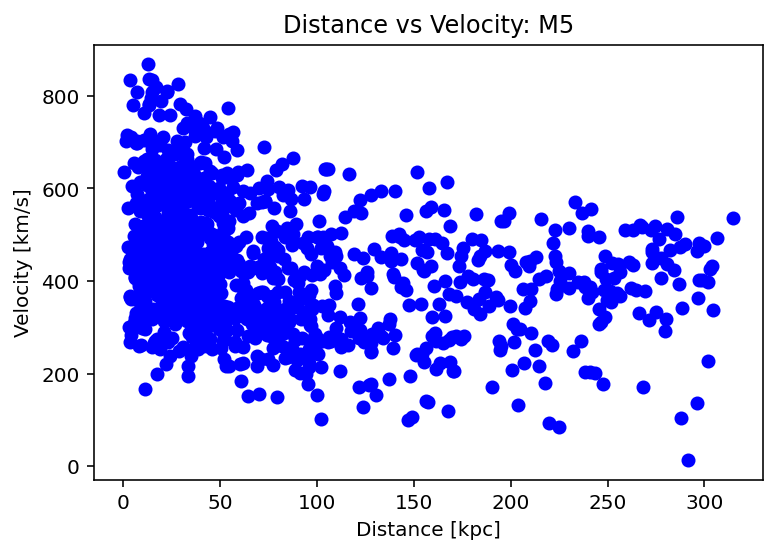

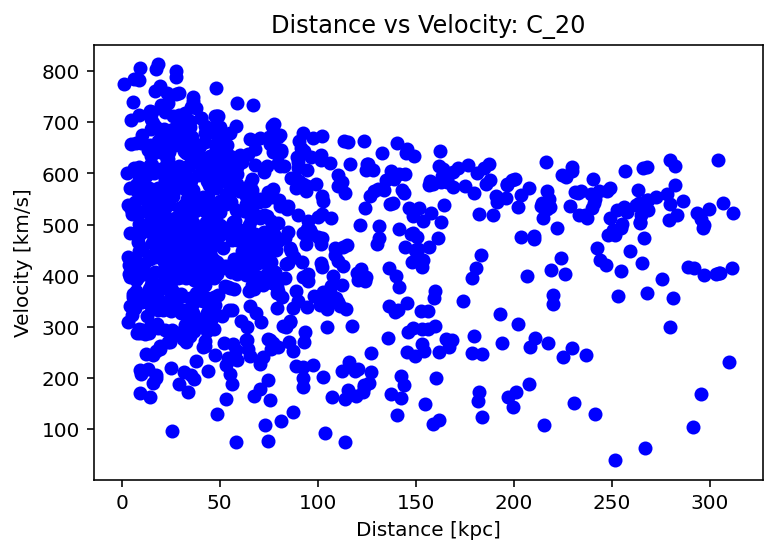

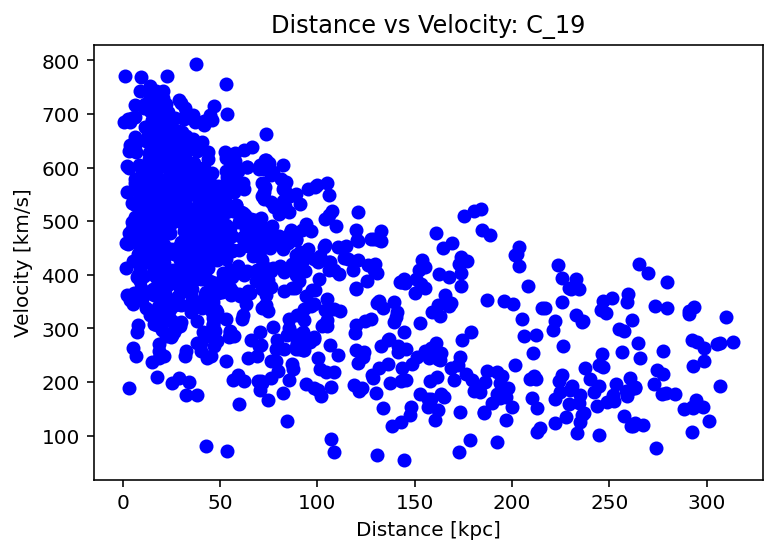

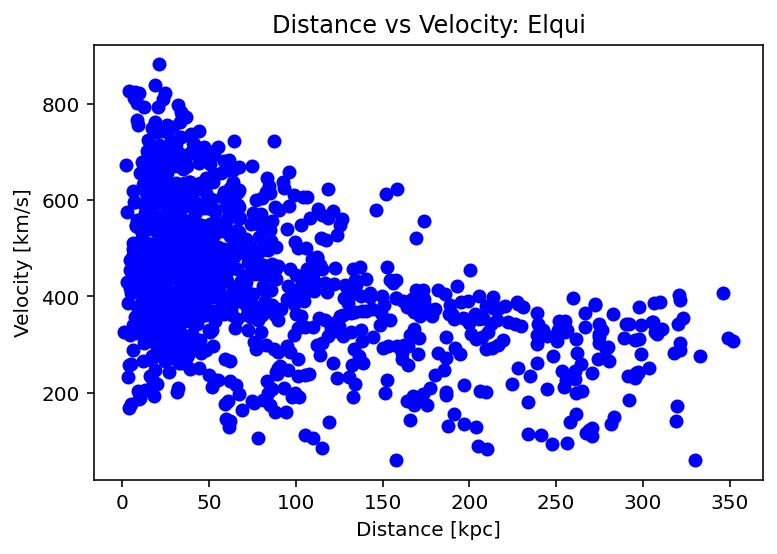

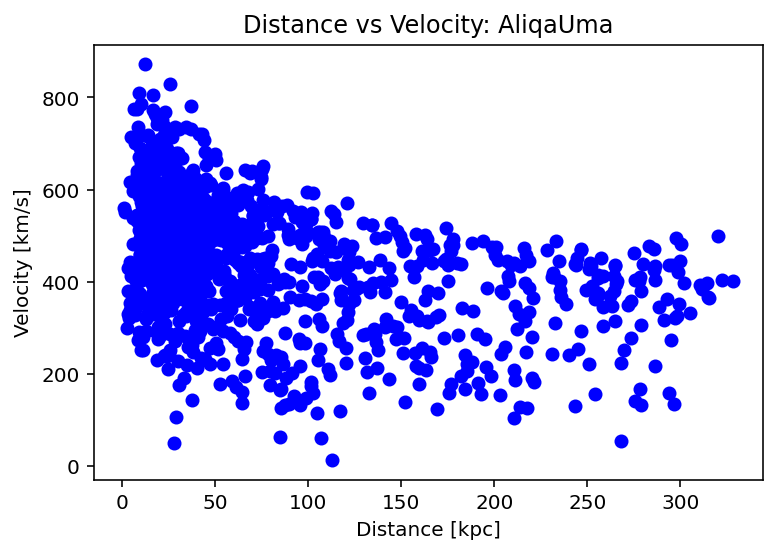

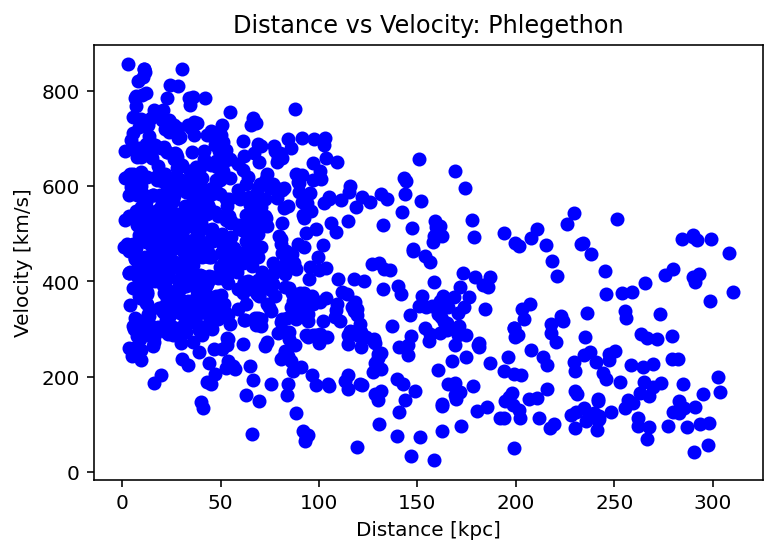

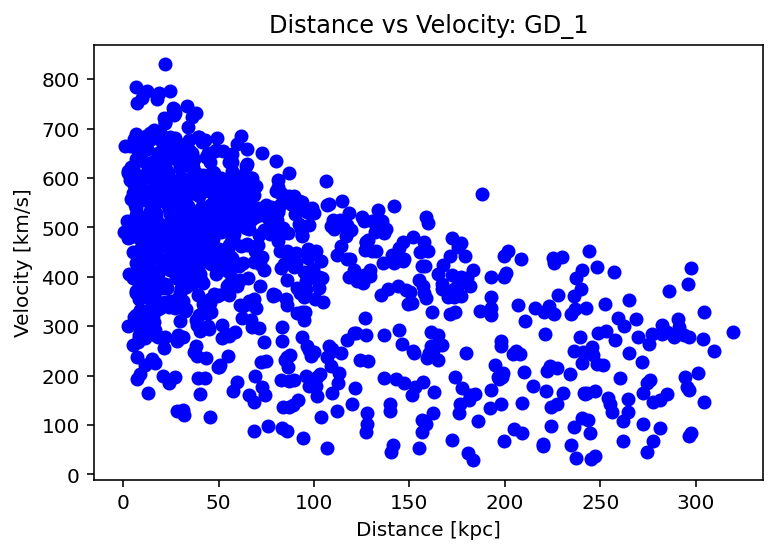

In [174]:
#Creating Visualization of Subhalo impact on streams (distance vs velocity kick)
for i in range(len(pb)):
    plt.figure()
    for subh in range(len(trot)):
        plt.scatter(pb['Subhalo_'+str(subh)+' Distance (kpc)'][i],pb['Subhalo_'+str(subh)+' Relative Velocity (km/s)'][i], color='blue') 
    plt.xlabel('Distance [kpc]')
    plt.ylabel('Velocity [km/s]')
    plt.title('Distance vs Velocity: '+str(pb.iloc[i][0]))
    #plt.legend(loc='best')
    plt.savefig('Distance_vs_Velocity/'+str(pb.iloc[i][0])+'.png', transparent=False, dpi=200)
    

In [175]:
#Calculation of Velocity Kick
#This is for GJOLL (UNITS ARE WRONG, check below for correct units)

G = (6.6743*10**(-11))*(u.m**3/(u.kg*u.s**2)) #gravitational constant
r_min = np.array(pb_new.iloc[0][1:])*u.kpc  #smallest distance between subhalos and stream 
v_rel = np.array(pb.iloc[0][3::3])*(u.km/u.s) #relative vel btwn strean and subhalos 
mass_subh = (np.array(ts[ind_massive]['mvir']))*u.M_sun #mass of subhalos

delta_v = 2*G*mass_subh/(r_min*v_rel) #start with this one 
vel_kick = np.sqrt(np.sum(delta_v**2))
vel_kick 


NameError: name 'pb_new' is not defined

In [ ]:
# #Creating a pd to store the delta values from each subhalo 
# lst_names = []
# for i in range(len(pb['Stream'])):
#     lst_names = np.append(lst_names, (pb['Stream'][i]))
#     data = {'Streams': lst_names}
# delta_v_general_info = pd.DataFrame(data = data)
# delta_v_general_info['Streams'][0]

# lst_col_name = np.array(['Streams'])
# for i in range(len(ts[ind_massive]['mvir'])):
#     lst_col_name = np.append(lst_col_name, 'Subhalo_'+str(i))  
# lst_col_name
# col = [lst_col_name]
# delta_v_general_info.assign(columns = col)

In [ ]:
#GOALS FOR VEL_KICK: 
#distribution for each individual kicks 
#Take one stream and plot the distribution of all the velocity kicks 

In [ ]:

vel_kick = (np.empty(len(pb)))*(u.m**3*u.M_sun/(u.kg*u.km*u.kpc*u.s))
#delta_v_individual_info = np.zeros(len(ts[ind_massive]['mvir'])) #creating an empty array to store ind delta v 
#there are 1072 contributions to velocity changes per stream
data_all = pd.DataFrame()
for i in range(len(pb)):
    
    #Calculating Velocity Kick 
    G = (6.6743*10**(-11))*(u.m**3/(u.kg*u.s**2)) #gravitational constant
    r_min = np.array(pb.iloc[i][1::3])*u.kpc  #smallest distance between subhalos and stream 
    v_rel = np.array(pb.iloc[i][3::3])*(u.km/u.s) #relative vel btwn strean and subhalos 
    mass_subh = (np.array(ts[ind_massive]['mvir']))*u.M_sun #mass of subhalos
    delta_v = 2*G*mass_subh/(r_min*v_rel) #start with this one 
    
    print(str(pb.iloc[i][0]), str(delta_v.to(u.km/u.s)[0]))

    plt.figure()
    delta_v_km_new = delta_v.to(u.km/u.s)
    plt.hist(delta_v_km_new.value, bins=np.logspace(-4,2,30) , color='blue', alpha=0.7)
    plt.gca().set_xscale('log') 
    plt.xlabel('Velocity Kick')
    plt.ylabel('Total Number of Subhalos')
    plt.title(str(pb.iloc[i][0])+' with LMC')
    plt.savefig('Vel_Kick_Histogram_with_LMC/'+str(pb.iloc[i][0])+'.png', transparent=False, dpi=200)
    
    
    vel_kick_temp = np.sqrt(np.sum(delta_v**2))
    vel_kick[i] = vel_kick_temp
vel_kick


    


In [ ]:
#Calculation of Velocity Kick Without LMC
# Add units 
vel_kick_no_LMC = (np.empty(len(pb)))*(u.m**3*u.M_sun/(u.kg*u.km*u.kpc*u.s))
#max_vel_kick_no_LMC = vel_kick_new
for i in range(len(pb)):
    G = (6.6743*10**(-11))*(u.m**3/(u.kg*u.s**2)) #gravitational constant
    r_min = np.array(pb.iloc[i][1::3])*u.kpc  #smallest distance between subhalos and stream 
    v_rel = np.array(pb.iloc[i][3::3])*(u.km/u.s) #relative vel btwn strean and subhalos 
    mass_subh = (np.array(ts[ind_massive]['mvir']))*u.M_sun #mass of subhalos
    delta_v = 2*G*mass_subh/(r_min*v_rel) #start with this one 
   
     
    #delta_v_max = np.max(delta_v)
    delta_v = delta_v[1:]
    
    plt.figure()
    delta_v_km_new = delta_v.to(u.km/u.s)
    plt.hist(delta_v_km_new.value, bins=np.logspace(-4,2,30) , color='blue', alpha=0.7)
    plt.gca().set_xscale('log') 
    plt.xlabel('Velocity Kick without LMC')
    plt.ylabel('Total Number of Subhalos')
    plt.title(str(pb.iloc[i][0])+' without LMC')
    plt.savefig('Vel_Kick_Histogram_without_LMC/'+str(pb.iloc[i][0])+'.png', transparent=False, dpi=200) 
    
    vel_kick_temp = np.sqrt(np.sum(delta_v[1:]**2))
    vel_kick_no_LMC[i] = vel_kick_temp
vel_kick_no_LMC 



#use .decompe for SI units

In [ ]:
#Calculation of Velocity Kick Without LMC
# Add units 
colors = ['black', 'silver', 'rosybrown', 'red', 'sienna',
         'tan', 'moccasin', 'gold', 'darkkhaki', 'olivedrab', 
         'chartreuse', 'darkgreen', 'lightseagreen', 'paleturquoise',
         'deepskyblue', 'slategray', 'royalblue', 'darkorange', 'darkgoldenrod',
         'lawngreen', 'mediumseagreen', 'mediumpurple', 'darkorchid', 'plum', 
         'm', 'palevioletred', 'violet', 'c', 'olive', 'lemonchiffon', 'skyblue',
         'indigo']

vel_kick_no_LMC = (np.empty(len(pb)))*(u.m**3*u.M_sun/(u.kg*u.km*u.kpc*u.s))
#max_vel_kick_no_LMC = vel_kick_new
for i in range(len(pb)):   
    #Calculating Velocity Kick 
    G = (6.6743*10**(-11))*(u.m**3/(u.kg*u.s**2)) #gravitational constant
    r_min = np.array(pb.iloc[i][1::3])*u.kpc  #smallest distance between subhalos and stream 
    v_rel = np.array(pb.iloc[i][3::3])*(u.km/u.s) #relative vel btwn strean and subhalos 
    mass_subh = (np.array(ts[ind_massive]['mvir']))*u.M_sun #mass of subhalos
    delta_v = 2*G*mass_subh/(r_min*v_rel) #start with this one 
    
    #plt.figure()
    delta_v_km_new = delta_v.to(u.km/u.s)
    
    plt.hist(delta_v_km_new.value,bins=np.logspace(-4,2,30), color=colors[i], alpha=0.9,
         histtype='step', linewidth=2)
    plt.axvline(delta_v_km_new[0].value, color=colors[i], linewidth=2)
    
    plt.gca().set_xscale('log') 

    
    vel_kick_temp = np.sqrt(np.sum(delta_v[1:]**2))
    vel_kick_no_LMC[i] = vel_kick_temp
vel_kick_no_LMC 

plt.xlabel('Velocity Kick with LMC')
plt.ylabel('Total Number of Subhalos')
plt.title('Velocity Kick with LMC for All Streams')
plt.savefig('Vel_Kick_Histogram_with_LMC/All_Stream_Vel_Kick_With_LMC.png', transparent=False, dpi=200) 



In [152]:
r_peri = dict(LMS_1=10.8, Gjoll=8.5, Leiptr=12.3, Hrid=1.1, Pal5=6.9, Orphan=15.6, 
             Gaia_1=8.2, Fimbulthul=2.4, Ylgr=11.5, Fjorm=9.1, Kshir=13.4, Cetus=14.7,
             Svol=5.9, Gunnthra=4.2, Slidr=8.7, M92=3.0, NGC_6397=3.4, NGC_3201=8.5,
             Ophiuchus=3.9, Atlas=11.7, C_7=3.5, C_3=5.7, Palca=10.8, Sylgr=8.7,
             Gaia_6=6.0, Gaia_9=8.7, Gaia_10=4.3, Gaia_12=18.5, Indus=12.6, Jhelum=8.7,
             Phoenix=11.7, NGC5466=4.8, M5=3.4, C_20=20.8, NGC7089=2.9, C_19=9.3,
             Elqui=12.1, Chenab=22.0, AliqaUma=11.6, Phlegethon=5.5, GD_1=14.1)


r_apo = dict(LMS_1=20.6, Gjoll=27.4, Leiptr=45.1, Hrid=22.0, Pal5=15.8, Orphan=41.2, 
             Gaia_1=67.6, Fimbulthul=7.2, Ylgr=20.7, Fjorm=29.1, Kshir=16.0, Cetus=35.9,
             Svol=10.0, Gunnthra=7.2, Slidr=32.3, M92=10.7, NGC_6397=6.4, NGC_3201=30.5,
             Ophiuchus=14.2, Atlas=32.4, C_7=21.0, C_3=10.0, Palca=16.5, Sylgr=24.6,
             Gaia_6=9.5, Gaia_9=20.8, Gaia_10=37.7, Gaia_12=194.3, Indus=18.9, Jhelum=24.5,
             Phoenix=18.1, NGC5466=33.7, M5=24.8, C_20=58.5, NGC7089=14.7, C_19=21.6,
             Elqui=54.0, Chenab=81.0, AliqaUma=31.9, Phlegethon=22.1, GD_1=23.0)


In [153]:
streams['r_apo'] = np.nan
streams['r_peri'] = np.nan

In [154]:
streams_copy = streams.copy()

for i in range(len(streams['Stream'][:])):
    if streams['Stream'][i] in list(r_apo.keys()):
        streams_copy['r_apo'][i] = r_apo[streams['Stream'][i]]
        streams_copy['r_peri'][i] = r_peri[streams['Stream'][i]]
        

<ipython-input-154-27d5bfcf547a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streams_copy['r_apo'][i] = r_apo[streams['Stream'][i]]
<ipython-input-154-27d5bfcf547a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streams_copy['r_peri'][i] = r_peri[streams['Stream'][i]]


In [155]:
streams_copy

Stream      ra    dec  distance  pm_ra_cosdec  pm_dec  \
0        Gjoll   82.10 -13.95      3.26         23.58  -23.70   
1       Leiptr   89.11 -28.37      7.39         10.59   -9.90   
2         Hrid  280.51  33.30      2.75         -5.88   20.08   
3         Pal5  229.65   0.26     20.16         -2.75   -2.68   
4       Gaia_1  190.96  -9.16      5.57        -14.39  -19.72   
5         Ylgr  173.82 -22.31      9.72         -0.44   -7.65   
6        Fjorm  251.89  65.38      6.42          3.92    3.10   
7        Kshir  205.88  67.25      9.57         -7.67   -3.92   
8     Gunnthra  284.22 -73.49      2.83        -15.83  -24.04   
9        Slidr  160.05  10.22      2.99        -24.60   -6.65   
10         M92  259.89  43.08      8.94         -5.15   -0.63   
11    NGC_3201  152.46 -46.32      4.99          8.87   -2.22   
12       Atlas   25.04 -29.81     19.93          0.04   -0.89   
13         C_7  287.15 -50.17      6.77        -13.79  -12.38   
14       Palca   36.57 -36.15     12.31          0.90   -0.23   
15       Sylgr  179.68  -2.44      3.77        -13.98  -12.90   
16      Gaia_9  233.27  60.42      4.68        -12.49    6.37   
17     Gaia_10  161.47  15.17     13.32         -4.14   -3.15   
18     Gaia_12   41.05  16.45     15.71          5.84   -5.66   
19       Indus  340.12 -60.58     14.96          3.59   -4.89   
20      Jhelum  351.95 -51.74     11.39          7.23   -4.37   
21     Phoenix   23.96 -50.01     16.80          2.72   -0.07   
22     NGC5466  214.41  26.84     14.09         -5.64   -0.72   
23          M5  206.96  13.50      7.44          3.50   -8.76   
24        C_20  359.81   8.63     18.11         -0.58    1.44   
25        C_19  355.28  28.82     18.04          1.25   -2.74   
26       Elqui   19.77 -42.36     51.41          0.33   -0.49   
27    AliqaUma   34.08 -33.97     21.98          0.24   -0.79   
28  Phlegethon  319.89 -32.07      3.29         -3.97  -37.66   
29        GD_1  160.02  45.90      8.06         -6.75  -10.88   

    radial_velocity  r_apo  r_peri  
0             78.73   27.4     8.5  
1            194.22   45.1    12.3  
2           -238.77   22.0     1.1  
3            -57.03   15.8     6.9  
4            214.91   67.6     8.2  
5            317.86   20.7    11.5  
6            -25.37   29.1     9.1  
7           -249.88   16.0    13.4  
8            132.26    7.2     4.2  
9             87.98   32.3     8.7  
10          -140.66   10.7     3.0  
11           489.63   30.5     8.5  
12           -85.65   32.4    11.7  
13            55.05   21.0     3.5  
14           106.32   16.5    10.8  
15          -184.80   24.6     8.7  
16          -359.86   20.8     8.7  
17           289.62   37.7     4.3  
18          -303.83  194.3    18.5  
19           -49.15   18.9    12.6  
20            -1.29   24.5     8.7  
21            45.92   18.1    11.7  
22            95.04   33.7     4.8  
23           -42.97   24.8     3.4  
24          -116.87   58.5    20.8  
25          -193.48   21.6     9.3  
26            15.86   54.0    12.1  
27           -42.33   31.9    11.6  
28            15.90   22.1     5.5  
29          -101.83   23.0    14.1

In [156]:
streams_copy.to_csv('Streams_data.csv', index='False')


In [157]:
streams = pd.read_csv('Streams_data.csv')
streams = streams.drop("Unnamed: 0",axis=1)

In [158]:
streams['vel_kick'] = np.nan

In [159]:
streams_copy = streams.copy()

vel_kick_km_s = vel_kick.to(u.km/u.s)
for i in range(len(streams['Stream'][:])):
    streams_copy['vel_kick'][i] = vel_kick_km_s[i]

<ipython-input-159-123d4aa28891>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streams_copy['vel_kick'][i] = vel_kick_km_s[i]


In [160]:
streams_copy

Stream      ra    dec  distance  pm_ra_cosdec  pm_dec  \
0        Gjoll   82.10 -13.95      3.26         23.58  -23.70   
1       Leiptr   89.11 -28.37      7.39         10.59   -9.90   
2         Hrid  280.51  33.30      2.75         -5.88   20.08   
3         Pal5  229.65   0.26     20.16         -2.75   -2.68   
4       Gaia_1  190.96  -9.16      5.57        -14.39  -19.72   
5         Ylgr  173.82 -22.31      9.72         -0.44   -7.65   
6        Fjorm  251.89  65.38      6.42          3.92    3.10   
7        Kshir  205.88  67.25      9.57         -7.67   -3.92   
8     Gunnthra  284.22 -73.49      2.83        -15.83  -24.04   
9        Slidr  160.05  10.22      2.99        -24.60   -6.65   
10         M92  259.89  43.08      8.94         -5.15   -0.63   
11    NGC_3201  152.46 -46.32      4.99          8.87   -2.22   
12       Atlas   25.04 -29.81     19.93          0.04   -0.89   
13         C_7  287.15 -50.17      6.77        -13.79  -12.38   
14       Palca   36.57 -36.15     12.31          0.90   -0.23   
15       Sylgr  179.68  -2.44      3.77        -13.98  -12.90   
16      Gaia_9  233.27  60.42      4.68        -12.49    6.37   
17     Gaia_10  161.47  15.17     13.32         -4.14   -3.15   
18     Gaia_12   41.05  16.45     15.71          5.84   -5.66   
19       Indus  340.12 -60.58     14.96          3.59   -4.89   
20      Jhelum  351.95 -51.74     11.39          7.23   -4.37   
21     Phoenix   23.96 -50.01     16.80          2.72   -0.07   
22     NGC5466  214.41  26.84     14.09         -5.64   -0.72   
23          M5  206.96  13.50      7.44          3.50   -8.76   
24        C_20  359.81   8.63     18.11         -0.58    1.44   
25        C_19  355.28  28.82     18.04          1.25   -2.74   
26       Elqui   19.77 -42.36     51.41          0.33   -0.49   
27    AliqaUma   34.08 -33.97     21.98          0.24   -0.79   
28  Phlegethon  319.89 -32.07      3.29         -3.97  -37.66   
29        GD_1  160.02  45.90      8.06         -6.75  -10.88   

    radial_velocity  r_apo  r_peri    vel_kick  
0             78.73   27.4     8.5   85.281863  
1            194.22   45.1    12.3  290.241352  
2           -238.77   22.0     1.1   48.045656  
3            -57.03   15.8     6.9   57.153605  
4            214.91   67.6     8.2   79.465647  
5            317.86   20.7    11.5   54.028556  
6            -25.37   29.1     9.1   46.494469  
7           -249.88   16.0    13.4   43.925118  
8            132.26    7.2     4.2   67.940894  
9             87.98   32.3     8.7   51.873998  
10          -140.66   10.7     3.0   67.260248  
11           489.63   30.5     8.5  187.721498  
12           -85.65   32.4    11.7   68.912629  
13            55.05   21.0     3.5  131.806263  
14           106.32   16.5    10.8   55.820556  
15          -184.80   24.6     8.7   38.359667  
16          -359.86   20.8     8.7   41.418034  
17           289.62   37.7     4.3   66.021964  
18          -303.83  194.3    18.5   75.461684  
19           -49.15   18.9    12.6   57.692290  
20            -1.29   24.5     8.7   44.930548  
21            45.92   18.1    11.7   52.291065  
22            95.04   33.7     4.8   96.872192  
23           -42.97   24.8     3.4   54.158798  
24          -116.87   58.5    20.8   65.107546  
25          -193.48   21.6     9.3   69.600493  
26            15.86   54.0    12.1  252.855823  
27           -42.33   31.9    11.6   67.229462  
28            15.90   22.1     5.5   47.903083  
29          -101.83   23.0    14.1   40.232870

In [161]:
streams_copy.to_csv('Streams_data_with_velkick.csv', index='False')

In [162]:
streams_copy

Stream      ra    dec  distance  pm_ra_cosdec  pm_dec  \
0        Gjoll   82.10 -13.95      3.26         23.58  -23.70   
1       Leiptr   89.11 -28.37      7.39         10.59   -9.90   
2         Hrid  280.51  33.30      2.75         -5.88   20.08   
3         Pal5  229.65   0.26     20.16         -2.75   -2.68   
4       Gaia_1  190.96  -9.16      5.57        -14.39  -19.72   
5         Ylgr  173.82 -22.31      9.72         -0.44   -7.65   
6        Fjorm  251.89  65.38      6.42          3.92    3.10   
7        Kshir  205.88  67.25      9.57         -7.67   -3.92   
8     Gunnthra  284.22 -73.49      2.83        -15.83  -24.04   
9        Slidr  160.05  10.22      2.99        -24.60   -6.65   
10         M92  259.89  43.08      8.94         -5.15   -0.63   
11    NGC_3201  152.46 -46.32      4.99          8.87   -2.22   
12       Atlas   25.04 -29.81     19.93          0.04   -0.89   
13         C_7  287.15 -50.17      6.77        -13.79  -12.38   
14       Palca   36.57 -36.15     12.31          0.90   -0.23   
15       Sylgr  179.68  -2.44      3.77        -13.98  -12.90   
16      Gaia_9  233.27  60.42      4.68        -12.49    6.37   
17     Gaia_10  161.47  15.17     13.32         -4.14   -3.15   
18     Gaia_12   41.05  16.45     15.71          5.84   -5.66   
19       Indus  340.12 -60.58     14.96          3.59   -4.89   
20      Jhelum  351.95 -51.74     11.39          7.23   -4.37   
21     Phoenix   23.96 -50.01     16.80          2.72   -0.07   
22     NGC5466  214.41  26.84     14.09         -5.64   -0.72   
23          M5  206.96  13.50      7.44          3.50   -8.76   
24        C_20  359.81   8.63     18.11         -0.58    1.44   
25        C_19  355.28  28.82     18.04          1.25   -2.74   
26       Elqui   19.77 -42.36     51.41          0.33   -0.49   
27    AliqaUma   34.08 -33.97     21.98          0.24   -0.79   
28  Phlegethon  319.89 -32.07      3.29         -3.97  -37.66   
29        GD_1  160.02  45.90      8.06         -6.75  -10.88   

    radial_velocity  r_apo  r_peri    vel_kick  
0             78.73   27.4     8.5   85.281863  
1            194.22   45.1    12.3  290.241352  
2           -238.77   22.0     1.1   48.045656  
3            -57.03   15.8     6.9   57.153605  
4            214.91   67.6     8.2   79.465647  
5            317.86   20.7    11.5   54.028556  
6            -25.37   29.1     9.1   46.494469  
7           -249.88   16.0    13.4   43.925118  
8            132.26    7.2     4.2   67.940894  
9             87.98   32.3     8.7   51.873998  
10          -140.66   10.7     3.0   67.260248  
11           489.63   30.5     8.5  187.721498  
12           -85.65   32.4    11.7   68.912629  
13            55.05   21.0     3.5  131.806263  
14           106.32   16.5    10.8   55.820556  
15          -184.80   24.6     8.7   38.359667  
16          -359.86   20.8     8.7   41.418034  
17           289.62   37.7     4.3   66.021964  
18          -303.83  194.3    18.5   75.461684  
19           -49.15   18.9    12.6   57.692290  
20            -1.29   24.5     8.7   44.930548  
21            45.92   18.1    11.7   52.291065  
22            95.04   33.7     4.8   96.872192  
23           -42.97   24.8     3.4   54.158798  
24          -116.87   58.5    20.8   65.107546  
25          -193.48   21.6     9.3   69.600493  
26            15.86   54.0    12.1  252.855823  
27           -42.33   31.9    11.6   67.229462  
28            15.90   22.1     5.5   47.903083  
29          -101.83   23.0    14.1   40.232870

In [163]:
streams_copy['vel_kick_no_LMC'] = np.nan

In [164]:
streams_copy_new = streams_copy.copy()

vel_kick_no_LMC_km_s = vel_kick_no_LMC.to(u.km/u.s)
for i in range(len(streams['Stream'][:])):
    streams_copy_new['vel_kick_no_LMC'][i] = vel_kick_no_LMC_km_s[i]

<ipython-input-164-f418d5b2479f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streams_copy_new['vel_kick_no_LMC'][i] = vel_kick_no_LMC_km_s[i]


In [165]:
streams_copy_new

Stream      ra    dec  distance  pm_ra_cosdec  pm_dec  \
0        Gjoll   82.10 -13.95      3.26         23.58  -23.70   
1       Leiptr   89.11 -28.37      7.39         10.59   -9.90   
2         Hrid  280.51  33.30      2.75         -5.88   20.08   
3         Pal5  229.65   0.26     20.16         -2.75   -2.68   
4       Gaia_1  190.96  -9.16      5.57        -14.39  -19.72   
5         Ylgr  173.82 -22.31      9.72         -0.44   -7.65   
6        Fjorm  251.89  65.38      6.42          3.92    3.10   
7        Kshir  205.88  67.25      9.57         -7.67   -3.92   
8     Gunnthra  284.22 -73.49      2.83        -15.83  -24.04   
9        Slidr  160.05  10.22      2.99        -24.60   -6.65   
10         M92  259.89  43.08      8.94         -5.15   -0.63   
11    NGC_3201  152.46 -46.32      4.99          8.87   -2.22   
12       Atlas   25.04 -29.81     19.93          0.04   -0.89   
13         C_7  287.15 -50.17      6.77        -13.79  -12.38   
14       Palca   36.57 -36.15     12.31          0.90   -0.23   
15       Sylgr  179.68  -2.44      3.77        -13.98  -12.90   
16      Gaia_9  233.27  60.42      4.68        -12.49    6.37   
17     Gaia_10  161.47  15.17     13.32         -4.14   -3.15   
18     Gaia_12   41.05  16.45     15.71          5.84   -5.66   
19       Indus  340.12 -60.58     14.96          3.59   -4.89   
20      Jhelum  351.95 -51.74     11.39          7.23   -4.37   
21     Phoenix   23.96 -50.01     16.80          2.72   -0.07   
22     NGC5466  214.41  26.84     14.09         -5.64   -0.72   
23          M5  206.96  13.50      7.44          3.50   -8.76   
24        C_20  359.81   8.63     18.11         -0.58    1.44   
25        C_19  355.28  28.82     18.04          1.25   -2.74   
26       Elqui   19.77 -42.36     51.41          0.33   -0.49   
27    AliqaUma   34.08 -33.97     21.98          0.24   -0.79   
28  Phlegethon  319.89 -32.07      3.29         -3.97  -37.66   
29        GD_1  160.02  45.90      8.06         -6.75  -10.88   

    radial_velocity  r_apo  r_peri    vel_kick  vel_kick_no_LMC  
0             78.73   27.4     8.5   85.281863        20.434221  
1            194.22   45.1    12.3  290.241352        19.290136  
2           -238.77   22.0     1.1   48.045656        20.309230  
3            -57.03   15.8     6.9   57.153605        17.339283  
4            214.91   67.6     8.2   79.465647        20.213433  
5            317.86   20.7    11.5   54.028556        15.694849  
6            -25.37   29.1     9.1   46.494469        26.273828  
7           -249.88   16.0    13.4   43.925118        19.010165  
8            132.26    7.2     4.2   67.940894        17.895889  
9             87.98   32.3     8.7   51.873998        15.520480  
10          -140.66   10.7     3.0   67.260248        19.749363  
11           489.63   30.5     8.5  187.721498        19.620481  
12           -85.65   32.4    11.7   68.912629        17.678834  
13            55.05   21.0     3.5  131.806263        26.347777  
14           106.32   16.5    10.8   55.820556        21.431967  
15          -184.80   24.6     8.7   38.359667        20.777941  
16          -359.86   20.8     8.7   41.418034        16.088737  
17           289.62   37.7     4.3   66.021964        19.030668  
18          -303.83  194.3    18.5   75.461684        24.809409  
19           -49.15   18.9    12.6   57.692290        47.023070  
20            -1.29   24.5     8.7   44.930548        32.808196  
21            45.92   18.1    11.7   52.291065        27.835622  
22            95.04   33.7     4.8   96.872192        23.295723  
23           -42.97   24.8     3.4   54.158798        28.397205  
24          -116.87   58.5    20.8   65.107546        29.129016  
25          -193.48   21.6     9.3   69.600493        61.200506  
26            15.86   54.0    12.1  252.855823        32.580607  
27           -42.33   31.9    11.6   67.229462        17.618005  
28            15.90   22.1     5.5   47.903083        20.388100  
29          

In [166]:
streams_copy_new.to_csv('Streams_data_with_velkick_NO_LMC.csv', index='False')

In [167]:
streams_copy_new = pd.read_csv('Streams_data_with_velkick_NO_LMC.csv')
streams_copy_new = streams_copy_new.drop("Unnamed: 0",axis=1)

In [168]:
streams_copy_new

Stream      ra    dec  distance  pm_ra_cosdec  pm_dec  \
0        Gjoll   82.10 -13.95      3.26         23.58  -23.70   
1       Leiptr   89.11 -28.37      7.39         10.59   -9.90   
2         Hrid  280.51  33.30      2.75         -5.88   20.08   
3         Pal5  229.65   0.26     20.16         -2.75   -2.68   
4       Gaia_1  190.96  -9.16      5.57        -14.39  -19.72   
5         Ylgr  173.82 -22.31      9.72         -0.44   -7.65   
6        Fjorm  251.89  65.38      6.42          3.92    3.10   
7        Kshir  205.88  67.25      9.57         -7.67   -3.92   
8     Gunnthra  284.22 -73.49      2.83        -15.83  -24.04   
9        Slidr  160.05  10.22      2.99        -24.60   -6.65   
10         M92  259.89  43.08      8.94         -5.15   -0.63   
11    NGC_3201  152.46 -46.32      4.99          8.87   -2.22   
12       Atlas   25.04 -29.81     19.93          0.04   -0.89   
13         C_7  287.15 -50.17      6.77        -13.79  -12.38   
14       Palca   36.57 -36.15     12.31          0.90   -0.23   
15       Sylgr  179.68  -2.44      3.77        -13.98  -12.90   
16      Gaia_9  233.27  60.42      4.68        -12.49    6.37   
17     Gaia_10  161.47  15.17     13.32         -4.14   -3.15   
18     Gaia_12   41.05  16.45     15.71          5.84   -5.66   
19       Indus  340.12 -60.58     14.96          3.59   -4.89   
20      Jhelum  351.95 -51.74     11.39          7.23   -4.37   
21     Phoenix   23.96 -50.01     16.80          2.72   -0.07   
22     NGC5466  214.41  26.84     14.09         -5.64   -0.72   
23          M5  206.96  13.50      7.44          3.50   -8.76   
24        C_20  359.81   8.63     18.11         -0.58    1.44   
25        C_19  355.28  28.82     18.04          1.25   -2.74   
26       Elqui   19.77 -42.36     51.41          0.33   -0.49   
27    AliqaUma   34.08 -33.97     21.98          0.24   -0.79   
28  Phlegethon  319.89 -32.07      3.29         -3.97  -37.66   
29        GD_1  160.02  45.90      8.06         -6.75  -10.88   

    radial_velocity  r_apo  r_peri    vel_kick  vel_kick_no_LMC  
0             78.73   27.4     8.5   85.281863        20.434221  
1            194.22   45.1    12.3  290.241352        19.290136  
2           -238.77   22.0     1.1   48.045656        20.309230  
3            -57.03   15.8     6.9   57.153605        17.339283  
4            214.91   67.6     8.2   79.465647        20.213433  
5            317.86   20.7    11.5   54.028556        15.694849  
6            -25.37   29.1     9.1   46.494469        26.273828  
7           -249.88   16.0    13.4   43.925118        19.010165  
8            132.26    7.2     4.2   67.940894        17.895889  
9             87.98   32.3     8.7   51.873998        15.520480  
10          -140.66   10.7     3.0   67.260248        19.749363  
11           489.63   30.5     8.5  187.721498        19.620481  
12           -85.65   32.4    11.7   68.912629        17.678834  
13            55.05   21.0     3.5  131.806263        26.347777  
14           106.32   16.5    10.8   55.820556        21.431967  
15          -184.80   24.6     8.7   38.359667        20.777941  
16          -359.86   20.8     8.7   41.418034        16.088737  
17           289.62   37.7     4.3   66.021964        19.030668  
18          -303.83  194.3    18.5   75.461684        24.809409  
19           -49.15   18.9    12.6   57.692290        47.023070  
20            -1.29   24.5     8.7   44.930548        32.808196  
21            45.92   18.1    11.7   52.291065        27.835622  
22            95.04   33.7     4.8   96.872192        23.295723  
23           -42.97   24.8     3.4   54.158798        28.397205  
24          -116.87   58.5    20.8   65.107546        29.129016  
25          -193.48   21.6     9.3   69.600493        61.200506  
26            15.86   54.0    12.1  252.855823        32.580607  
27           -42.33   31.9    11.6   67.229462        17.618005  
28            15.90   22.1     5.5   47.903083        20.388100  
29          

Text(0.5, 1.0, 'Streams Apocenter vs Pericenter')

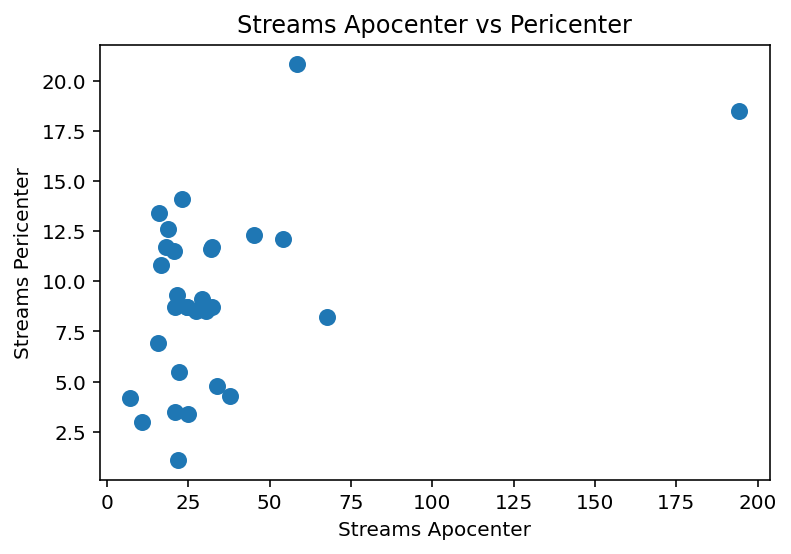

In [25]:
plt.figure()
plt.plot(streams_copy_new['r_apo'], streams_copy_new['r_peri'], '.', ms=15)
plt.xlabel('Streams Apocenter')
plt.ylabel('Streams Pericenter')
plt.title('Streams Apocenter vs Pericenter')
#plt.gca().set_aspect('equal', adjustable='datalim')

In [36]:
corr_apo_peri = np.corrcoef(streams_copy_new['r_apo'], streams_copy_new['r_peri'])
corr_apo_peri

array([[1.        , 0.49676505],
       [0.49676505, 1.        ]])

Text(0.5, 1.0, 'Streams Pericenter vs Velocity Kick')

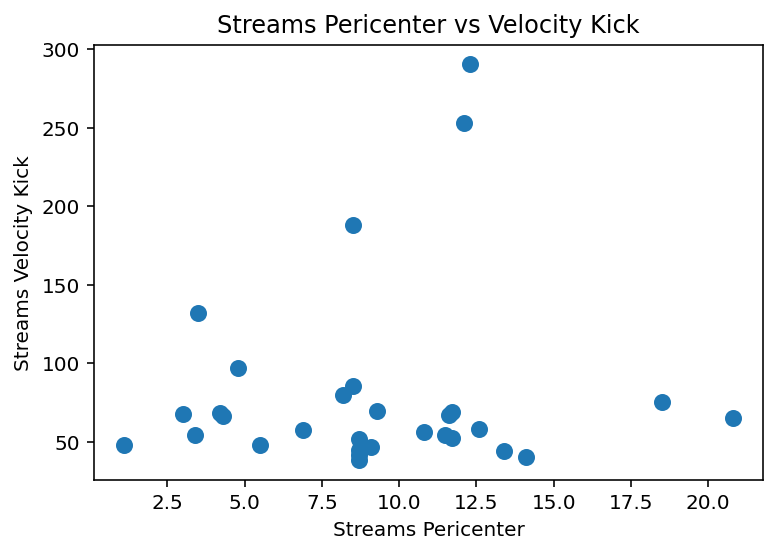

In [105]:
#x = np.linspace(0,300,10)
plt.figure()
plt.plot(streams_copy_new['r_peri'], streams_copy_new['vel_kick'], '.', ms=15)
plt.xlabel('Streams Pericenter')
plt.ylabel('Streams Velocity Kick')
plt.title('Streams Pericenter vs Velocity Kick')
#plt.plot(x, x)
#plt.xlim(0, 75)
#plt.gca().set_aspect('equal', adjustable='datalim')

In [37]:
corr_peri_velkick = np.corrcoef(streams_copy_new['r_peri'], streams_copy_new['vel_kick'])
corr_peri_velkick

array([[1.        , 0.09029779],
       [0.09029779, 1.        ]])

Text(0.5, 1.0, 'Streams Apo vs Velocity Kick')

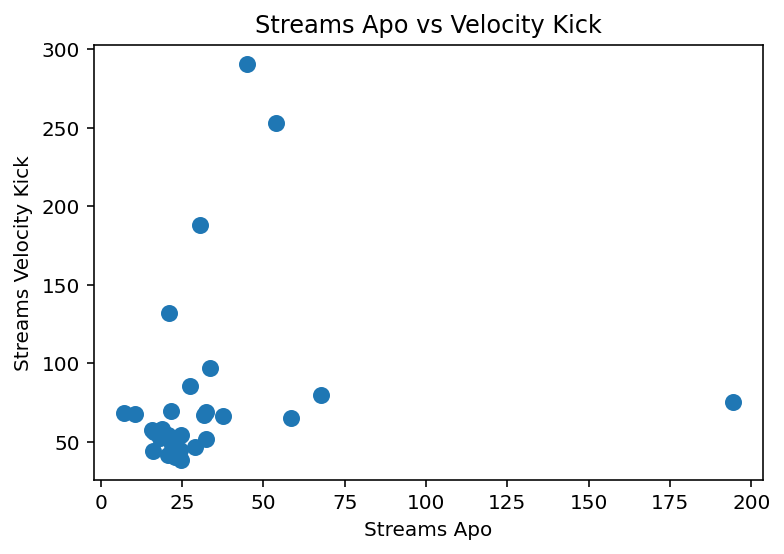

In [26]:
#x = np.linspace(0,300,10)
plt.figure()
plt.plot(streams_copy_new['r_apo'], streams_copy_new['vel_kick'], '.', ms=15)
plt.xlabel('Streams Apo')
plt.ylabel('Streams Velocity Kick')
plt.title('Streams Apo vs Velocity Kick')
#plt.plot(x, x)
#plt.xlim(0, 75)
#plt.gca().set_aspect('equal', adjustable='datalim')

In [38]:
corr_apo_velkick = np.corrcoef(streams_copy_new['r_apo'], streams_copy_new['vel_kick'])
corr_apo_velkick

array([[1.        , 0.16953206],
       [0.16953206, 1.        ]])

Text(0.5, 1.0, 'Streams Pericenter vs Velocity Kick No LMC')

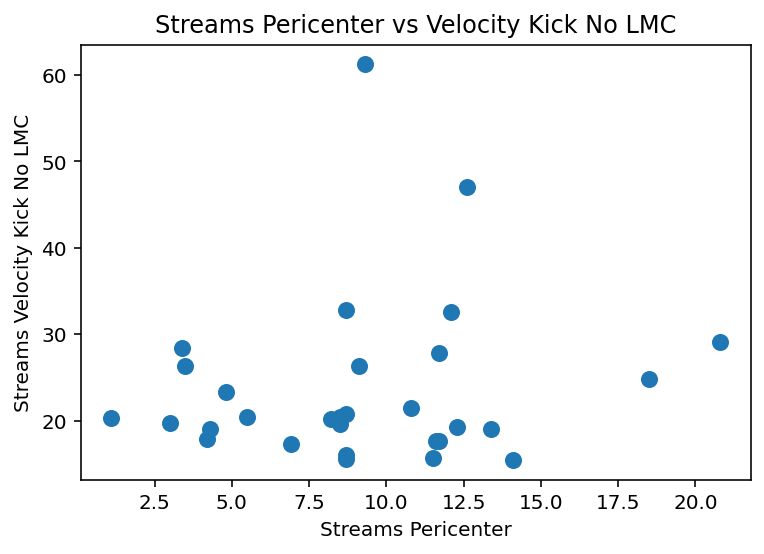

In [116]:
#x = np.linspace(0,300,10)
plt.figure()
plt.plot(streams_copy_new['r_peri'], streams_copy_new['vel_kick_no_LMC'], '.', ms=15)
plt.xlabel('Streams Pericenter')
plt.ylabel('Streams Velocity Kick No LMC')
plt.title('Streams Pericenter vs Velocity Kick No LMC')
#plt.plot(x, x)
#plt.xlim(0, 75)
#plt.gca().set_aspect('equal', adjustable='datalim')

In [39]:
corr_peri_velkicknoLMC = np.corrcoef(streams_copy_new['r_peri'], streams_copy_new['vel_kick_no_LMC'])
corr_peri_velkicknoLMC

array([[1.        , 0.13498624],
       [0.13498624, 1.        ]])

Text(0.5, 1.0, 'Streams Apo vs Velocity Kick No LMC')

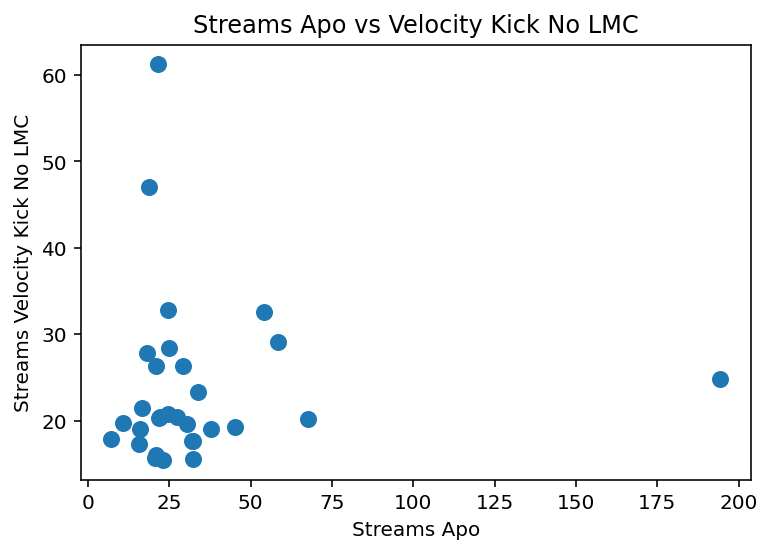

In [27]:
#x = np.linspace(0,300,10)
plt.figure()
plt.plot(streams_copy_new['r_apo'], streams_copy_new['vel_kick_no_LMC'], '.', ms=15)
plt.xlabel('Streams Apo')
plt.ylabel('Streams Velocity Kick No LMC')
plt.title('Streams Apo vs Velocity Kick No LMC')
#plt.plot(x, x)
#plt.xlim(0, 75)
#plt.gca().set_aspect('equal', adjustable='datalim')

In [40]:
corr_apo_velkicknoLMC = np.corrcoef(streams_copy_new['r_apo'], streams_copy_new['vel_kick_no_LMC'])
corr_apo_velkicknoLMC

array([[1.        , 0.02248158],
       [0.02248158, 1.        ]])

In [21]:
diff_velkicks = np.abs(streams_copy_new['vel_kick_no_LMC'] - streams_copy_new['vel_kick'])
#diff_velkicks

0      64.847642
1     270.951215
2      27.736426
3      39.814322
4      59.252214
5      38.333706
6      20.220641
7      24.914953
8      50.045005
9      36.353518
10     47.510886
11    168.101017
12     51.233794
13    105.458487
14     34.388589
15     17.581726
16     25.329297
17     46.991297
18     50.652276
19     10.669220
20     12.122353
21     24.455443
22     73.576469
23     25.761592
24     35.978530
25      8.399987
26    220.275215
27     49.611457
28     27.514983
29     24.753259
dtype: float64

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Absolute Difference in Velocity Kicks Per Stream')

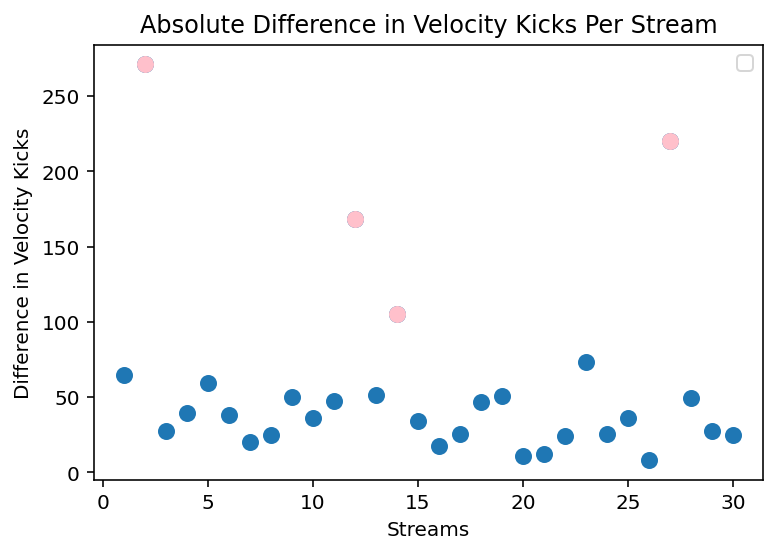

In [22]:
x = np.linspace(1,30,30)
plt.figure()
plt.plot(x, diff_velkicks, '.', ms=15)
plt.plot(x[diff_velkicks>100], diff_velkicks[diff_velkicks>100], '.', 
         color= 'pink', ms=15) #label=str(streams_copy_new['Stream'][diff_velkicks>100]) + ':' + 

# feed back from lmc generically heats up the streams 
#str(mwsts[str(streams_copy_new['Stream'][diff_velkicks>100])].length.deg))
#Need Help Adding Names 

plt.xlabel('Streams')
plt.ylabel('Difference in Velocity Kicks')
plt.legend(loc='best')
plt.title('Absolute Difference in Velocity Kicks Per Stream')

In [56]:
streams_copy_new['Stream'][diff_velkicks>100]

1       Leiptr
11    NGC_3201
13         C_7
26       Elqui
Name: Stream, dtype: object

In [ ]:
Getting Max Velocity Kicks 

In [110]:
for i in range(len(streams_copy_new)):
    if streams_copy_new['vel_kick'][i] > 150:
        print(streams_copy_new['Stream'][i])
    

Leiptr
NGC_3201
Elqui


In [114]:
for i in range(len(streams_copy_new)):
    if streams_copy_new['vel_kick_no_LMC'][i] > 40:
        print(streams_copy_new['Stream'][i])

Indus
C_19


In [ ]:
#Smallest Distance on y axis and apocenter on x axis for all streams

In [18]:
# define Galactocentric reference frame
coord.galactocentric_frame_defaults.set('v4.0')
gc_frame = coord.Galactocentric()

#define hamiltonian
ham = gp.Hamiltonian(gp.NFWPotential(m=MW_analog['mvir']/h*u.Msun, 
                                     r_s=(MW_analog['rs'])/h*u.kpc, units=galactic))

def ClosestDistNoTime(streams):
    #Information for Stream 
    closest_dist1 = pd.DataFrame()
    for i in range(len(streams)): #goes through every stream
        c = coord.SkyCoord(ra=streams.iloc[i]['ra']*u.deg, dec=streams.iloc[i]['dec']*u.deg, 
                           distance=streams.iloc[i]['distance']*u.kpc, pm_ra_cosdec=streams.iloc[i]['pm_ra_cosdec']*u.mas/u.yr,
                           pm_dec=streams.iloc[i]['pm_dec']*u.mas/u.yr, radial_velocity=streams.iloc[i]['radial_velocity']*u.km/u.s, frame='icrs')

        w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)


        dt = 1*u.Myr
        Nstep_foward = 2
        orbit_foward = ham.integrate_orbit(w0, dt=dt, n_steps=Nstep_foward)
        orbit_foward_icrs = orbit_foward.to_coord_frame(coord.ICRS())

        w0_start = gd.PhaseSpacePosition(orbit_foward.pos[-1], orbit_foward.vel[-1])
        Nstep = 7
        orbit = ham.integrate_orbit(w0_start, dt=-dt, n_steps=Nstep)
        orbit_sky = orbit.to_coord_frame(coord.ICRS())
        
        #Going back for 3 Gyrs (3000 steps of -1Myr)
        Nstep_long = 3000
        orbit_long = ham.integrate_orbit(w0_start, dt=-dt, n_steps=Nstep_long)

        
        
        data_new = {'Stream':[str(streams.iloc[i]['Stream'])]}
        data_temp = pd.DataFrame(data=data_new)
        for subh in range(len(trot['x'])): #subh stands for individual subhalo
            dist_x = orbit_long.pos.x - rot_orbits[subh,:,0]*u.kpc 
            dist_y = orbit_long.pos.y - rot_orbits[subh,:,1]*u.kpc
            dist_z = orbit_long.pos.z - rot_orbits[subh,:,2]*u.kpc
            rel_dist = np.sqrt((dist_x**2) + (dist_y**2) + (dist_z**2))
            closest_dist2 = np.min(rel_dist)
            
            data_temp['Subhalo_'+ str(subh)+ ' Distance (kpc)'] = [closest_dist2.value]
   
            
        closest_dist1 = closest_dist1.append(data_temp, ignore_index=True)
    return closest_dist1

    #closest_dist.to_csv('Closest_Rel_Dist_to_Subhalos.csv', index='False')







In [21]:
pb_new = ClosestDistNoTime(streams)

<ipython-input-44-f18070418c8b>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


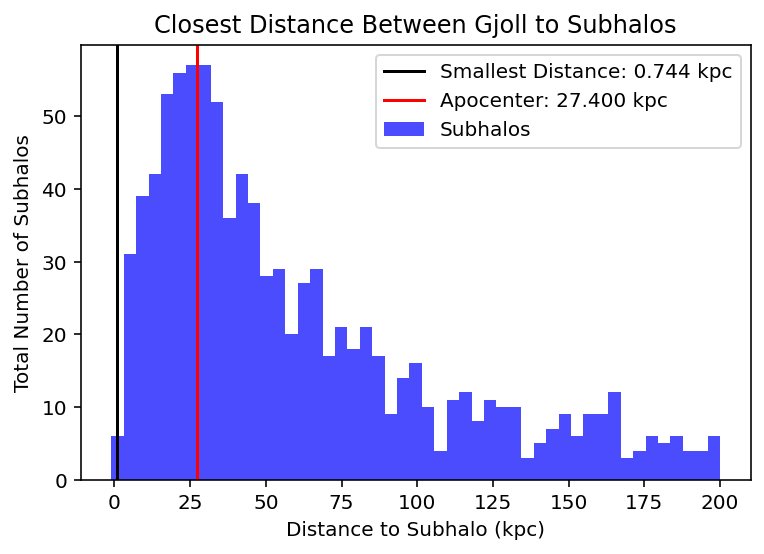

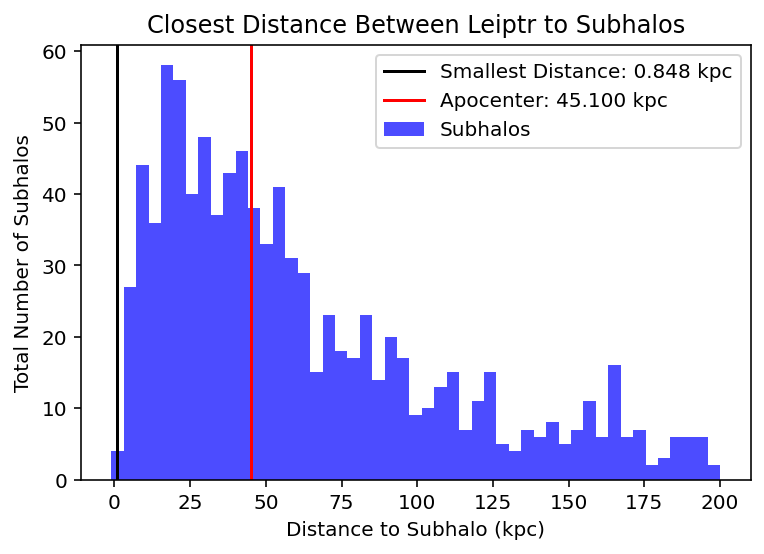

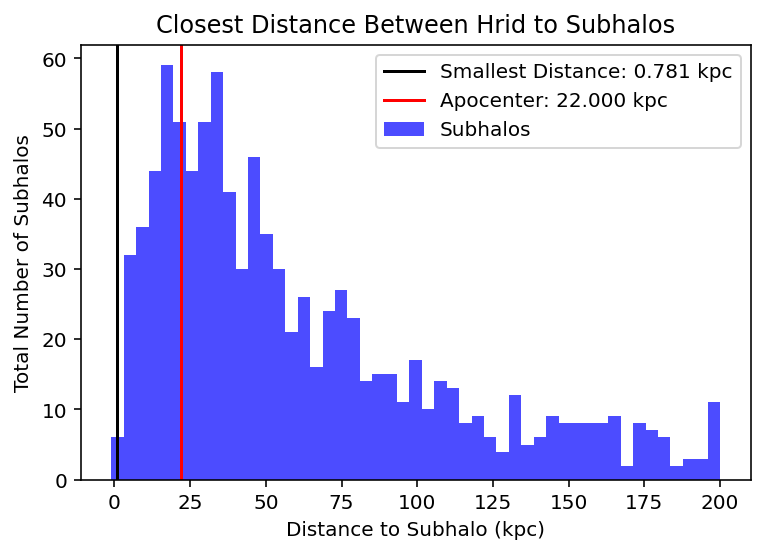

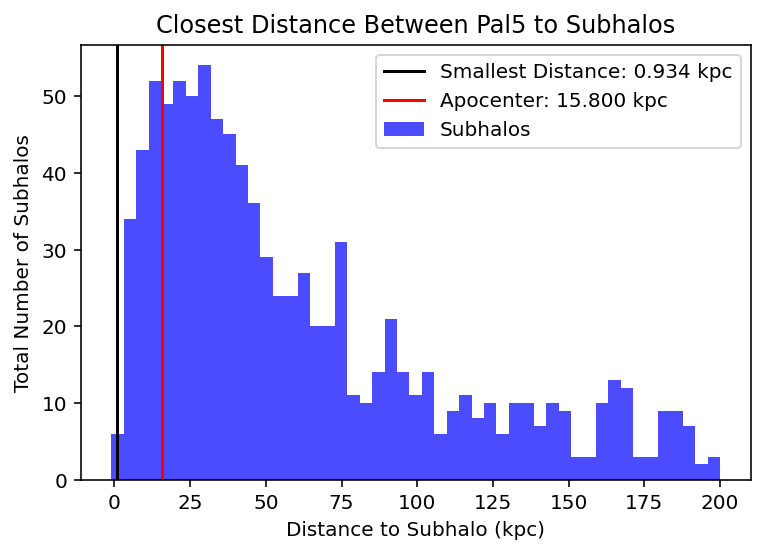

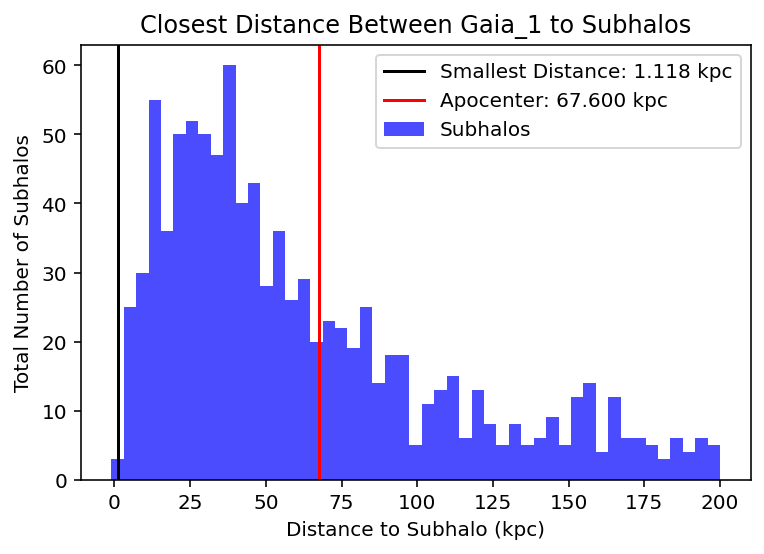

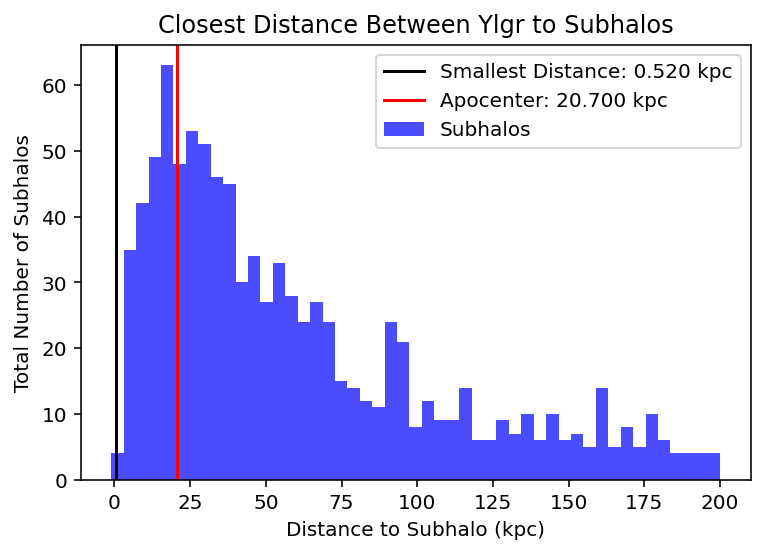

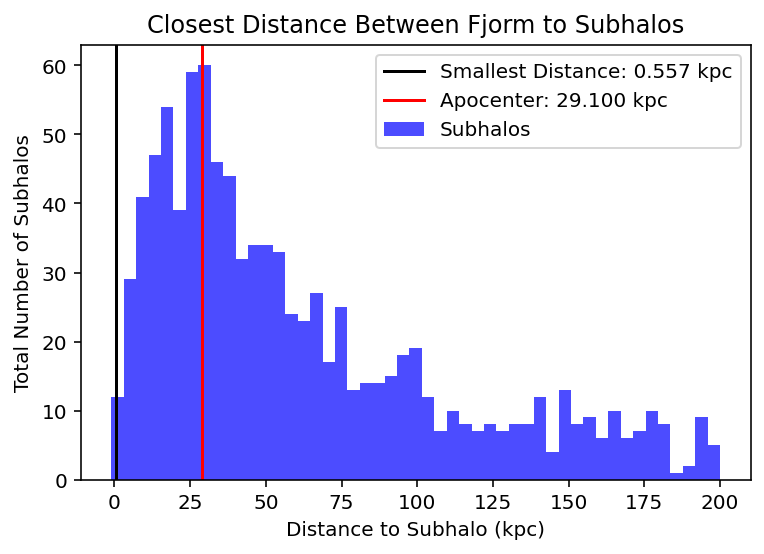

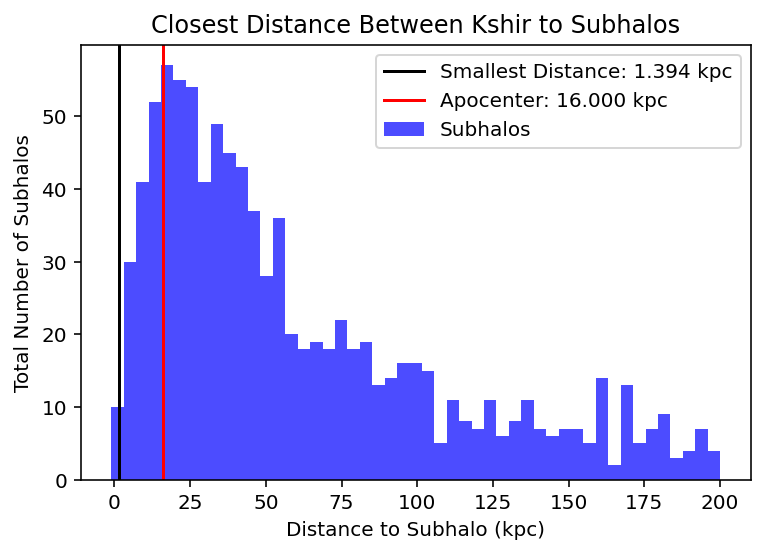

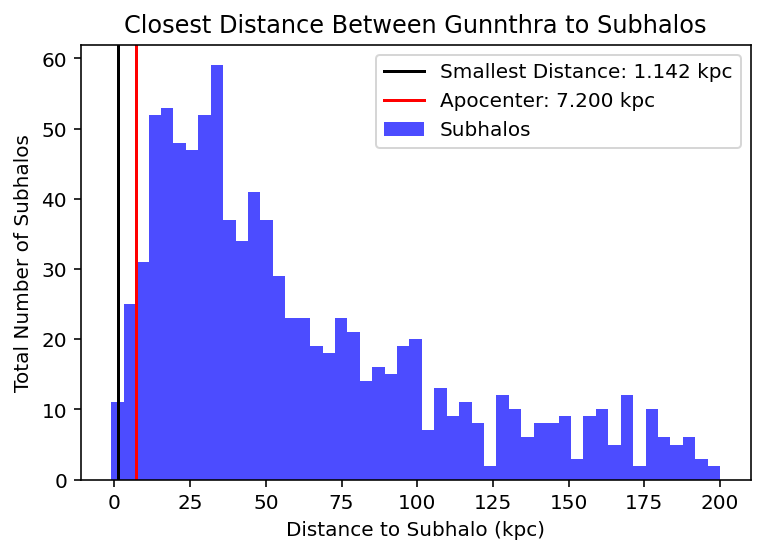

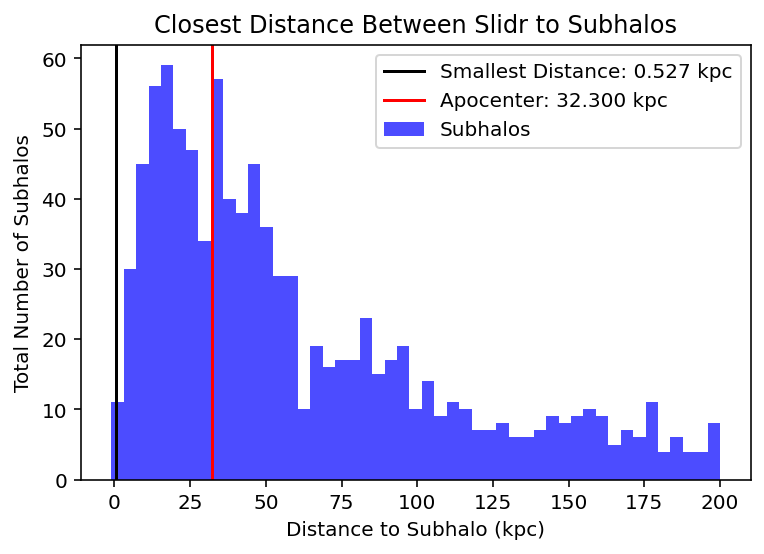

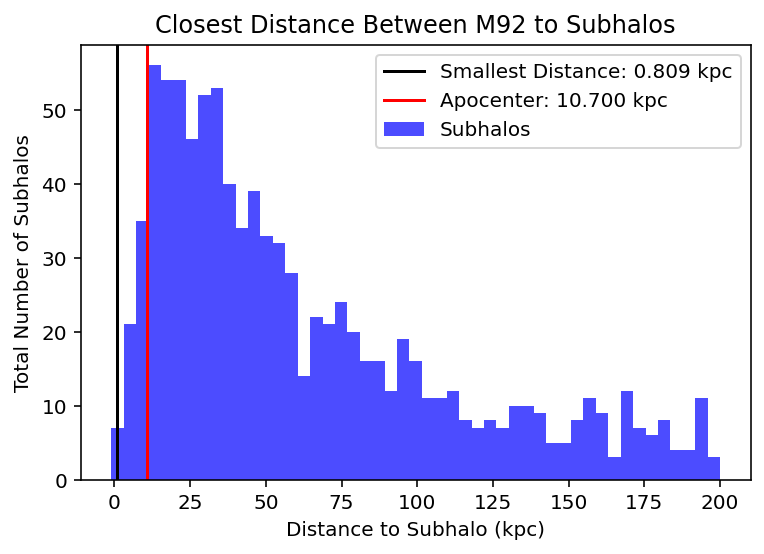

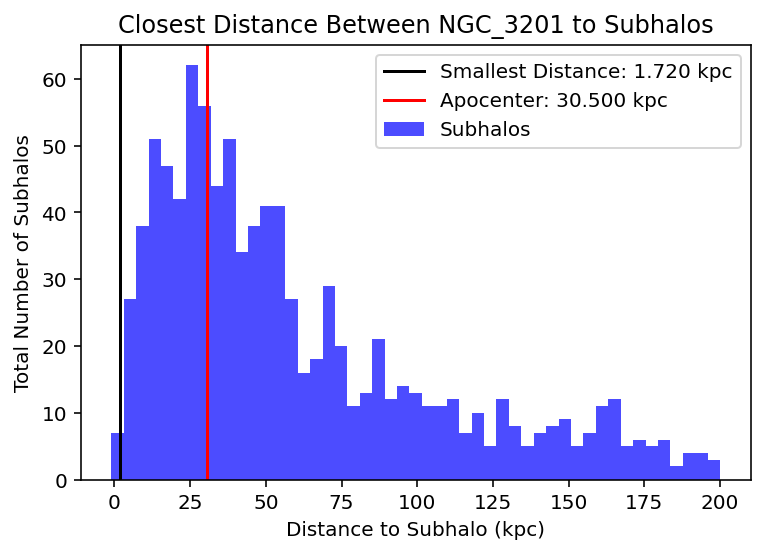

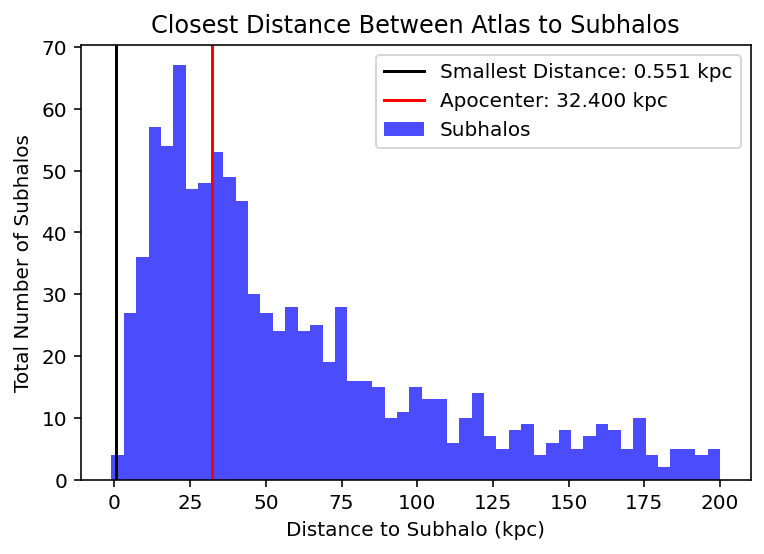

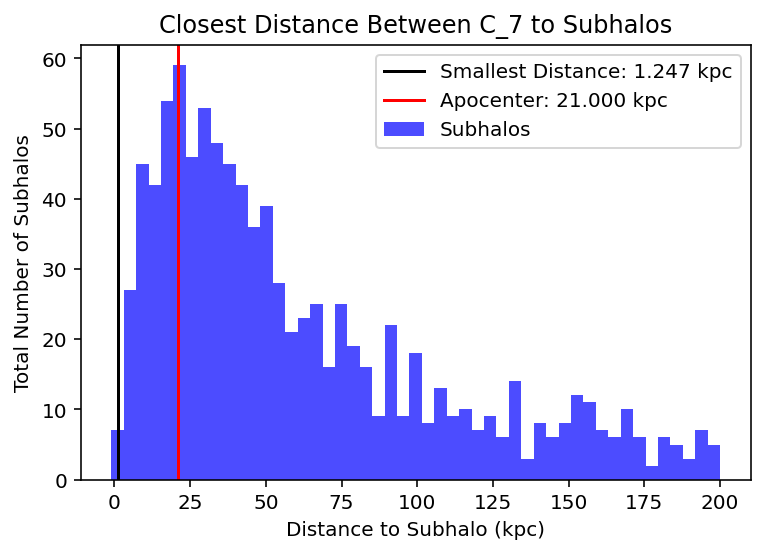

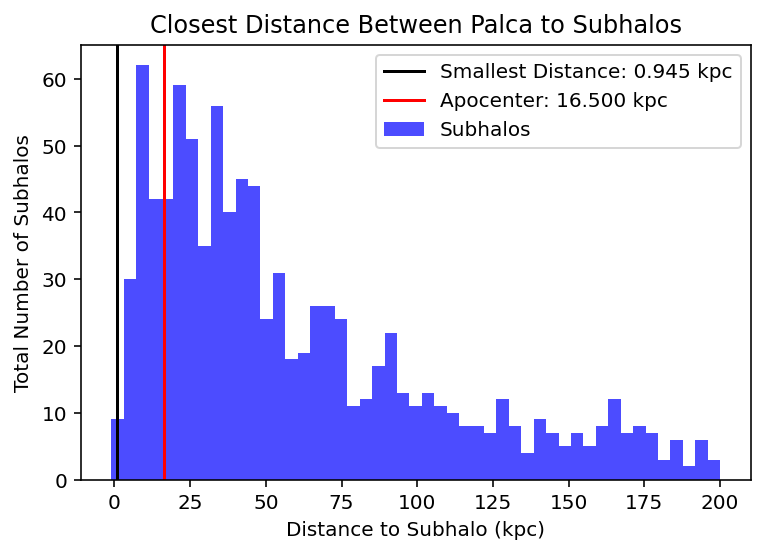

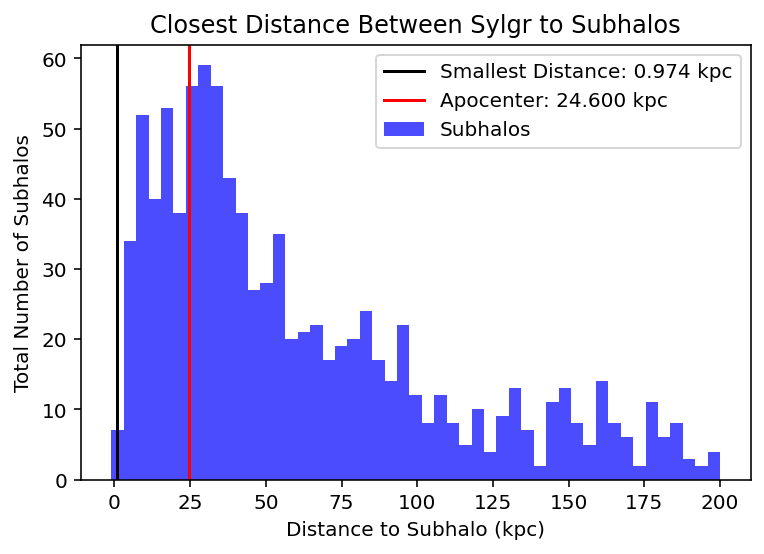

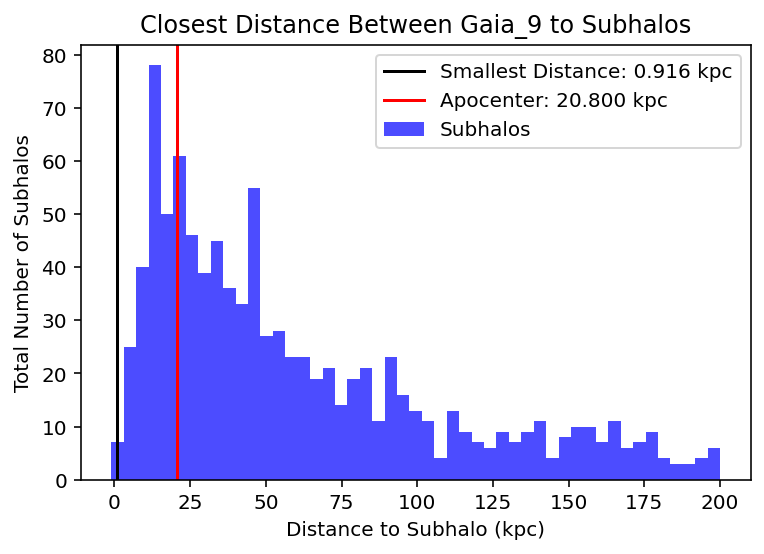

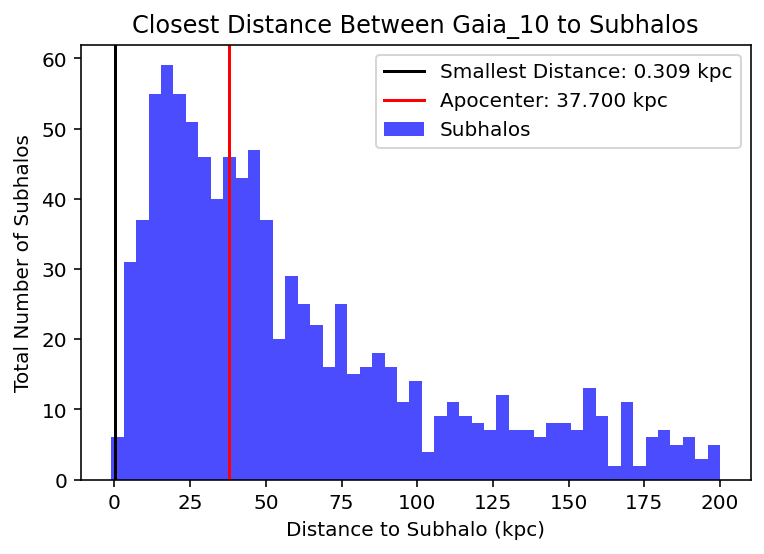

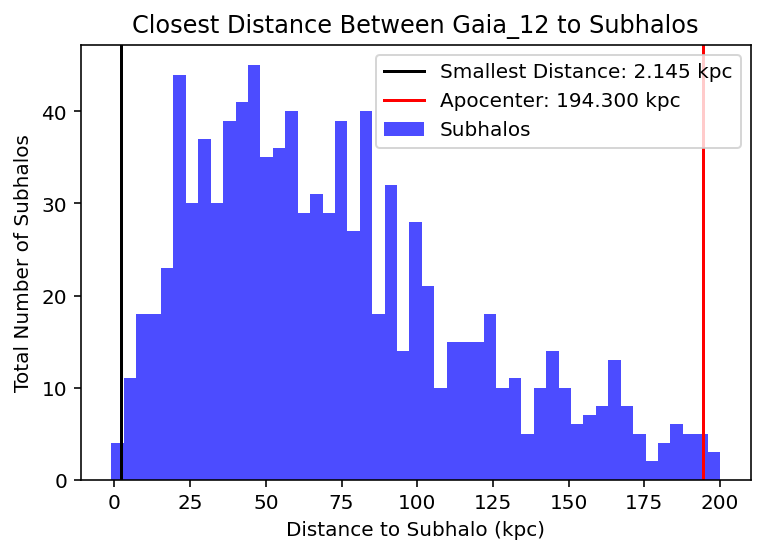

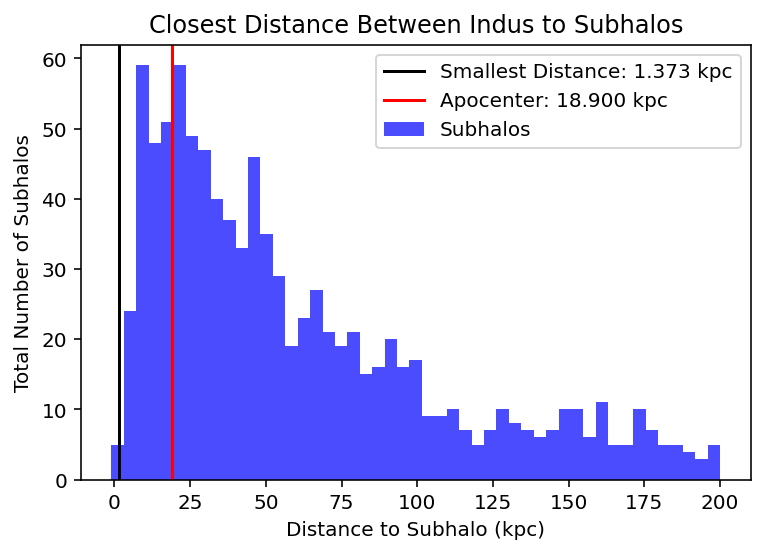

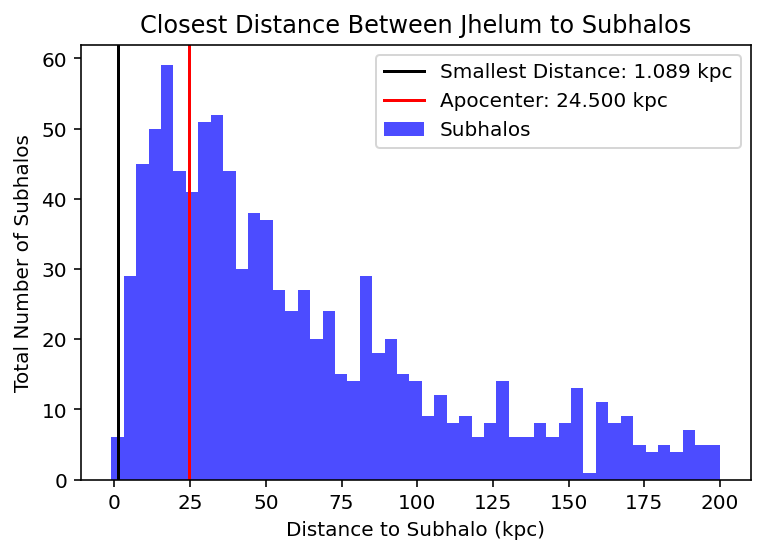

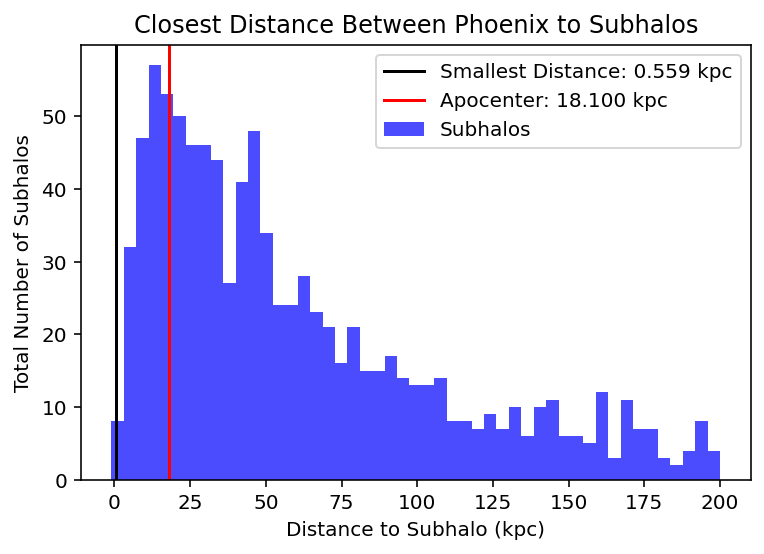

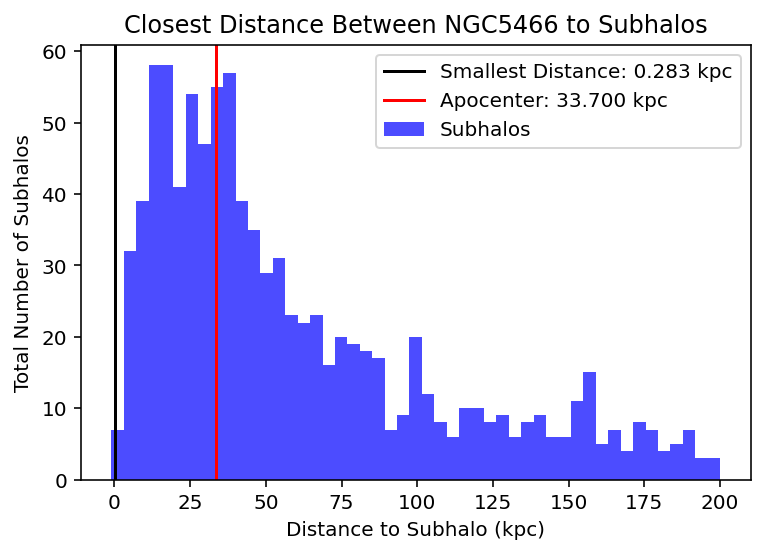

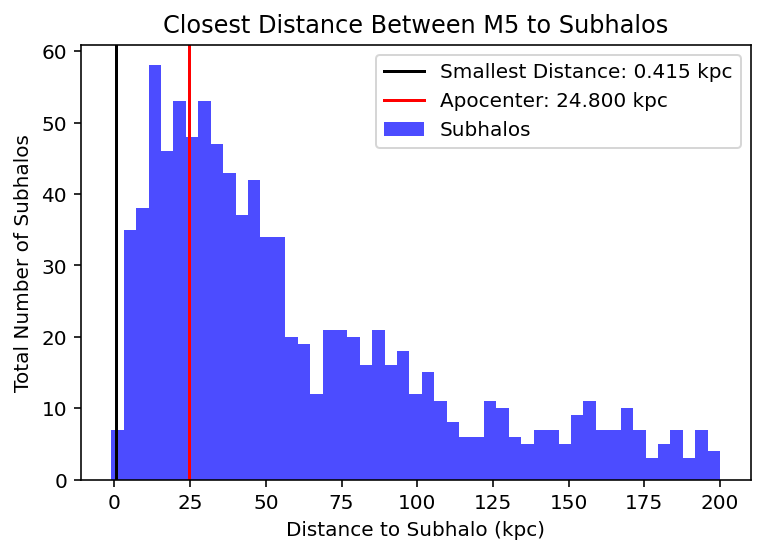

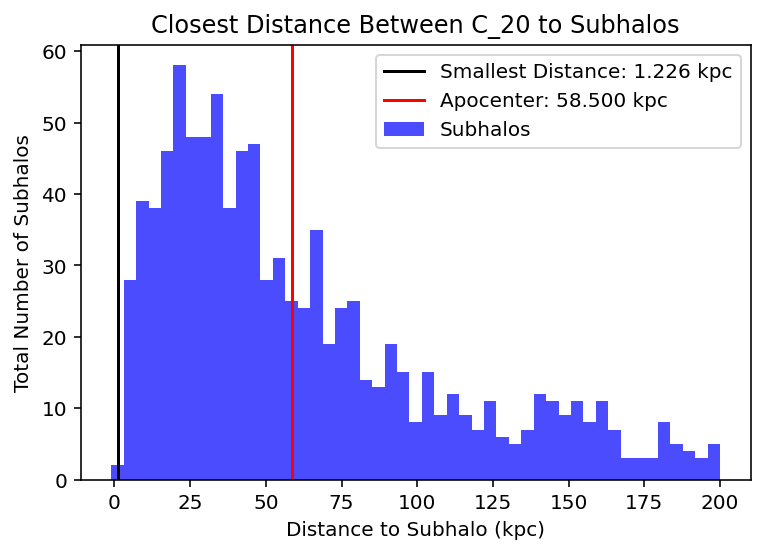

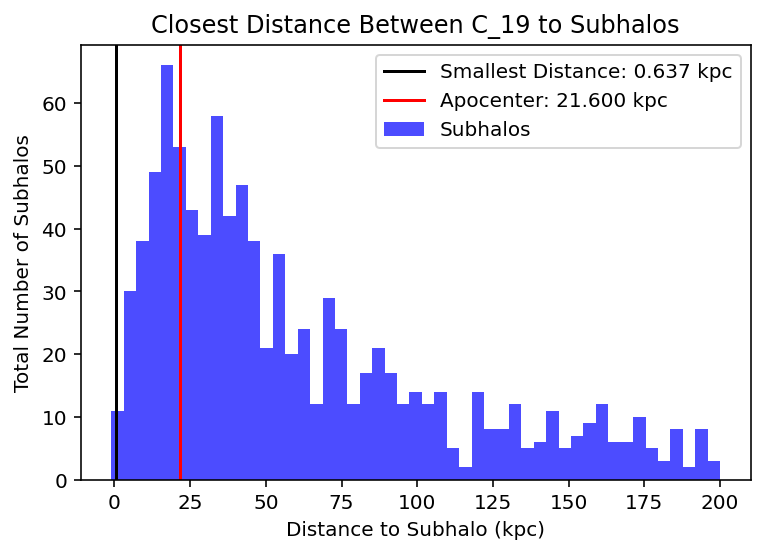

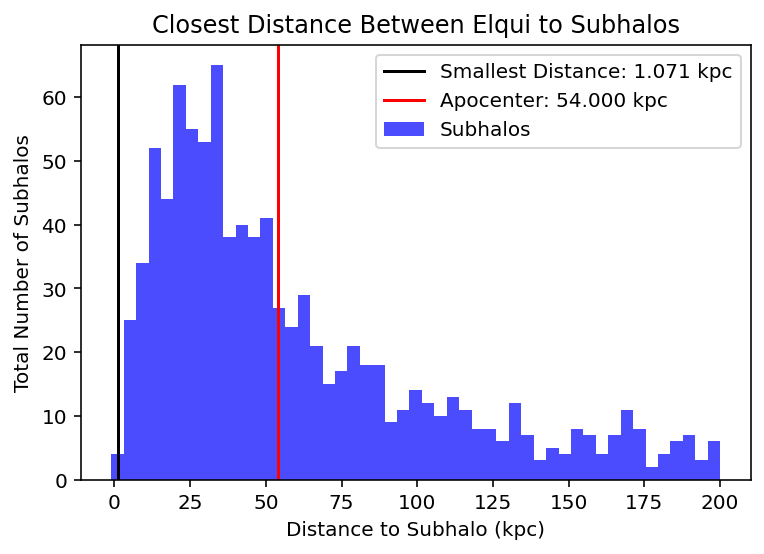

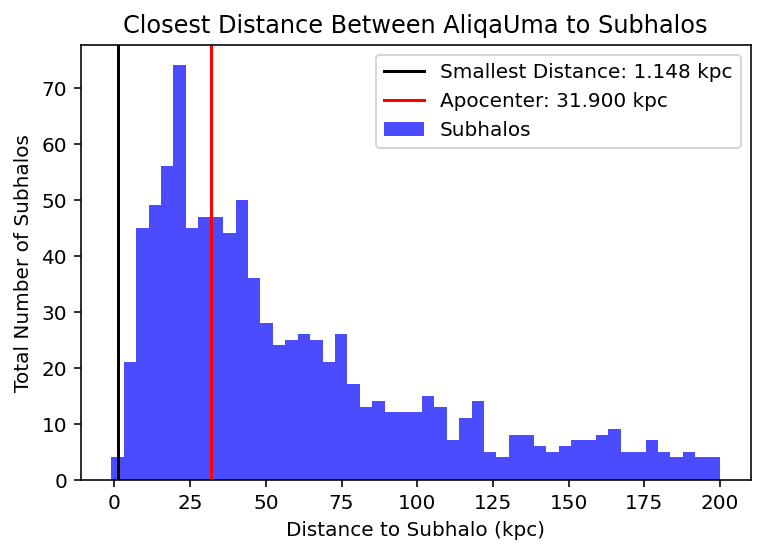

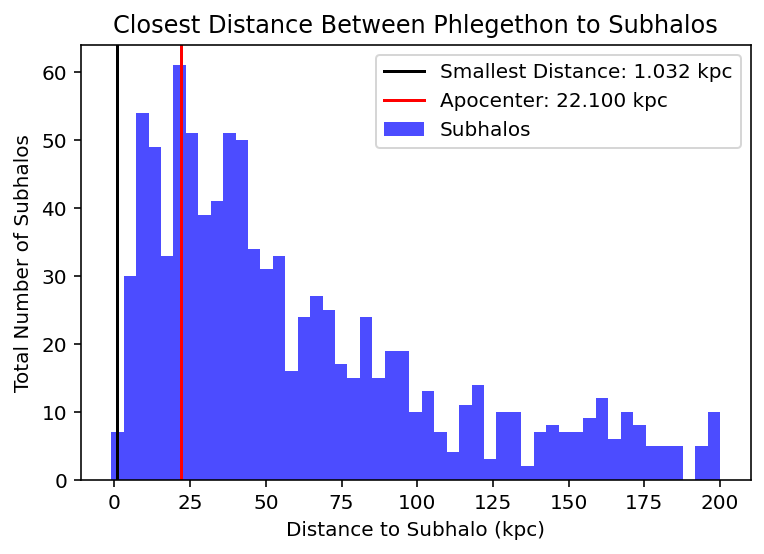

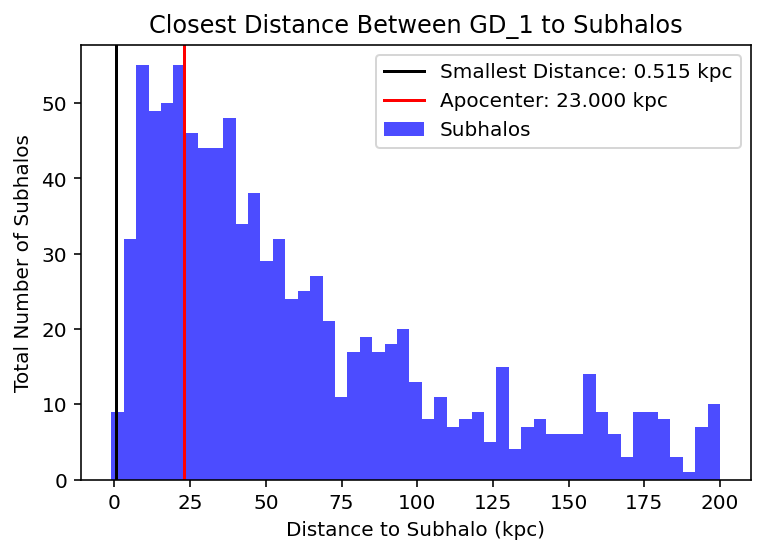

In [44]:
#Creates Histograms for All Streams 
#Include both Apocenter and Pericenter
for i in range(len(pb_new)):
    plt.figure()
    plt.hist(pb_new.iloc[i][1:], bins=np.linspace(-1,200,50), color='blue', alpha=0.7, label='Subhalos');  
    plt.axvline(min(pb_new.iloc[i][1:]), color='black', label = 'Smallest Distance: {:.3f} kpc'.format(min(pb_new.iloc[i][1:])))
    for key in range(len(r_apo.keys())):
        if pb_new.iloc[i][0] == list(r_apo.keys())[key]:
            plt.axvline(r_apo[pb_new.iloc[i][0]], color='red', label = 'Apocenter: {:.3f} kpc'.format(r_apo[pb_new.iloc[i][0]]))
    plt.title('Closest Distance Between {:s} to Subhalos'.format(pb_new.iloc[i][0]))
    plt.xlabel('Distance to Subhalo (kpc)')
    plt.ylabel('Total Number of Subhalos')
    plt.legend(loc='best')
    plt.savefig('Stream_to_Subhalo_Histograms/'+str(pb_new.iloc[i][0])+'.png', transparent=False, dpi=200)
    
    

In [100]:
trot['x'][1:]

<Column name='x' dtype='float64' length=1071>
  19.90469941445416
  40.51952434373715
 112.99428921774361
  -80.7158924016363
 208.41599574083165
  89.26177293486964
 -119.7141498527599
 -138.1078821850083
-22.121974963244966
-164.05876667593722
 -174.7101790860813
  81.05410964911513
                ...
 38.990001739047194
  54.76624943589129
 115.57762677890085
  21.62779748615728
-52.694167533750296
  40.62091169320566
  -38.0521371513839
  35.39212295017454
-27.797026860502946
 -61.40875365591903
 -75.18317063535272
 -80.02111012263964

<IPython.core.display.Javascript object>


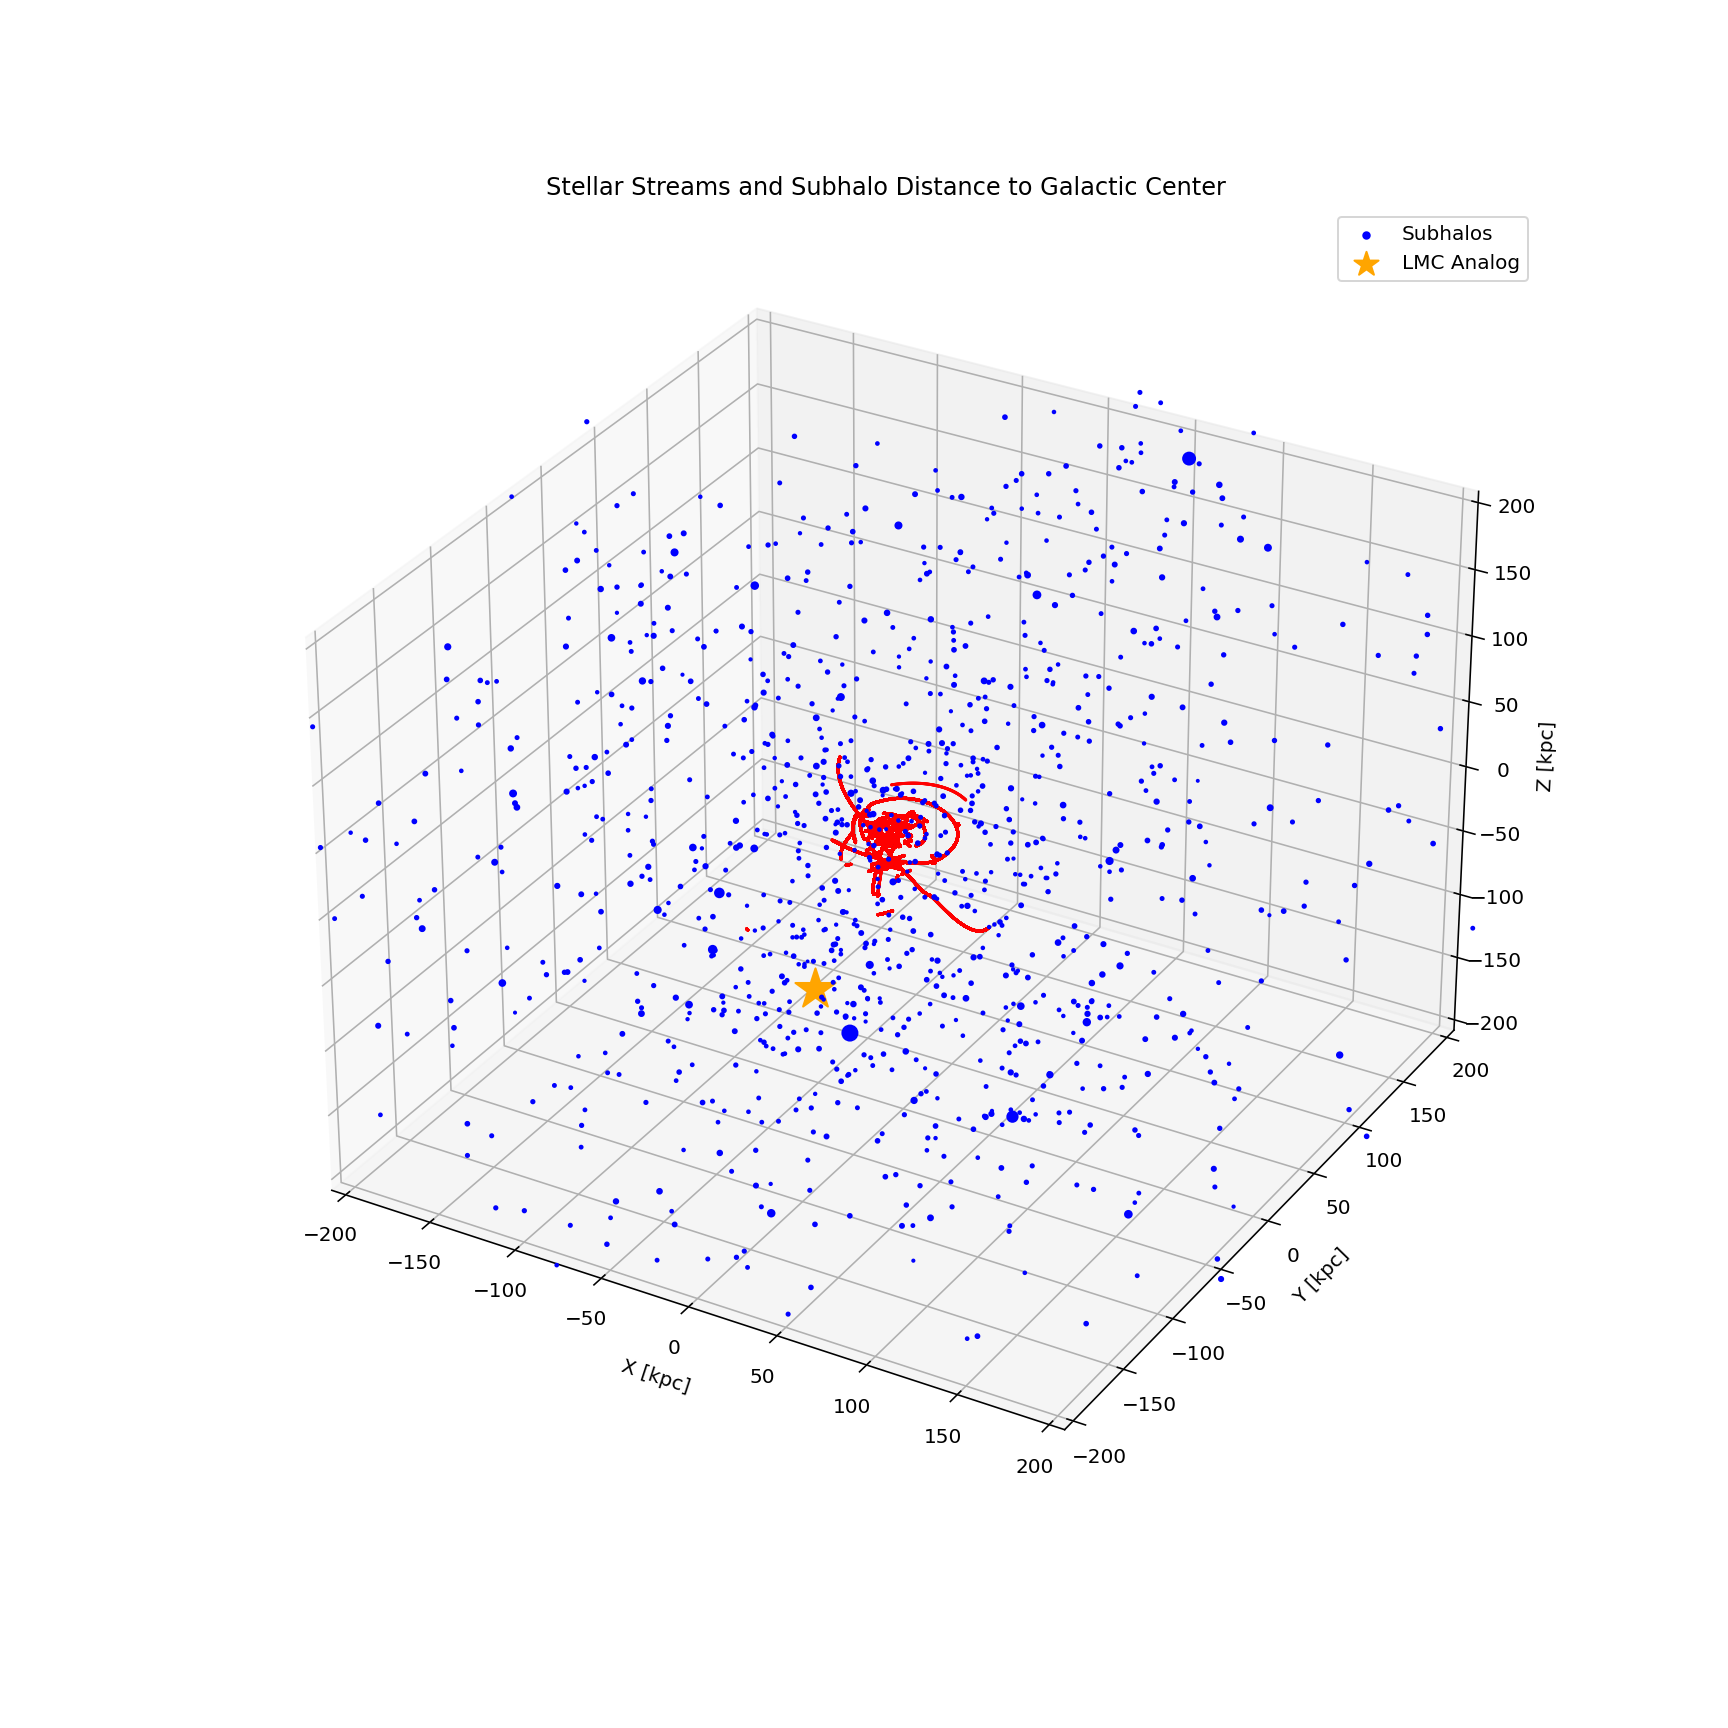

In [18]:
%matplotlib notebook
fig = plt.figure(1,figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
for st in mwsts.keys():
    ax.scatter3D(mwsts[st].track.transform_to(gsr).x,mwsts[st].track.transform_to(gsr).y,
                 mwsts[st].track.transform_to(gsr).z,
                 marker='.', color='red', s=1, c=None, alpha=1)
ax.scatter3D(trot['x'][1:], trot['y'][1:], trot['z'][1:], color='blue', label='Subhalos', s=10*(trot['rs'][1:]), alpha=1)    
ax.scatter3D(trot['x'][0], trot['y'][0], trot['z'][0], marker='*', color='orange', s=50*trot['rs'][0], 
             label='LMC Analog', alpha=1)
ax.set_xlim3d(-200, 200)
ax.set_ylim3d(-200, 200)
ax.set_zlim3d(-200, 200)
ax.set_xlabel('X [kpc]')
ax.set_ylabel('Y [kpc]')
ax.set_zlabel('Z [kpc]')
plt.legend(loc='best', markerscale=0.6)
plt.title('Stellar Streams and Subhalo Distance to Galactic Center')
plt.savefig('Stellar_Streams_and_Subhalo_Distance_to_Galactic_Center.png', transparent=False, dpi=200)
#point size of subhalos to be related to the r_s (radial size)
#label LMC analog
#another version of zoomed in, with limits 50kpc (?) 
#label streams (maybe) 
                 
                 

In [27]:
#Orbit time step for Gaia-1

# define Galactocentric reference frame
coord.galactocentric_frame_defaults.set('v4.0')
gc_frame = coord.Galactocentric()

ham = gp.Hamiltonian(gp.NFWPotential(m=MW_analog['mvir']/h*u.Msun, 
                                     r_s=(MW_analog['rs'])/h*u.kpc, units=galactic))

name = 'Gaia-1-I21'
c = coord.SkyCoord(ra=190.96*u.deg, dec=-9.16*u.deg, distance=5.57*u.kpc, pm_ra_cosdec=-14.39*u.mas/u.yr,
                  pm_dec=-19.72*u.mas/u.yr, radial_velocity=214.91*u.km/u.s, frame='icrs')

w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)

dt = 1*u.Myr
Nstep_foward = 3
orbit_foward = ham.integrate_orbit(w0, dt=dt, n_steps=Nstep_foward)
orbit_foward_icrs = orbit_foward.to_coord_frame(coord.ICRS())

w0_start = gd.PhaseSpacePosition(orbit_foward.pos[-1], orbit_foward.vel[-1])
Nstep = 9
orbit = ham.integrate_orbit(w0_start, dt=-dt, n_steps=Nstep)
orbit_sky = orbit.to_coord_frame(coord.ICRS())

In [28]:
#LONG ORBIT: going backwards in time
Nstep_long = 3000
orbit_long = ham.integrate_orbit(w0_start, dt=-dt, n_steps=Nstep_long)

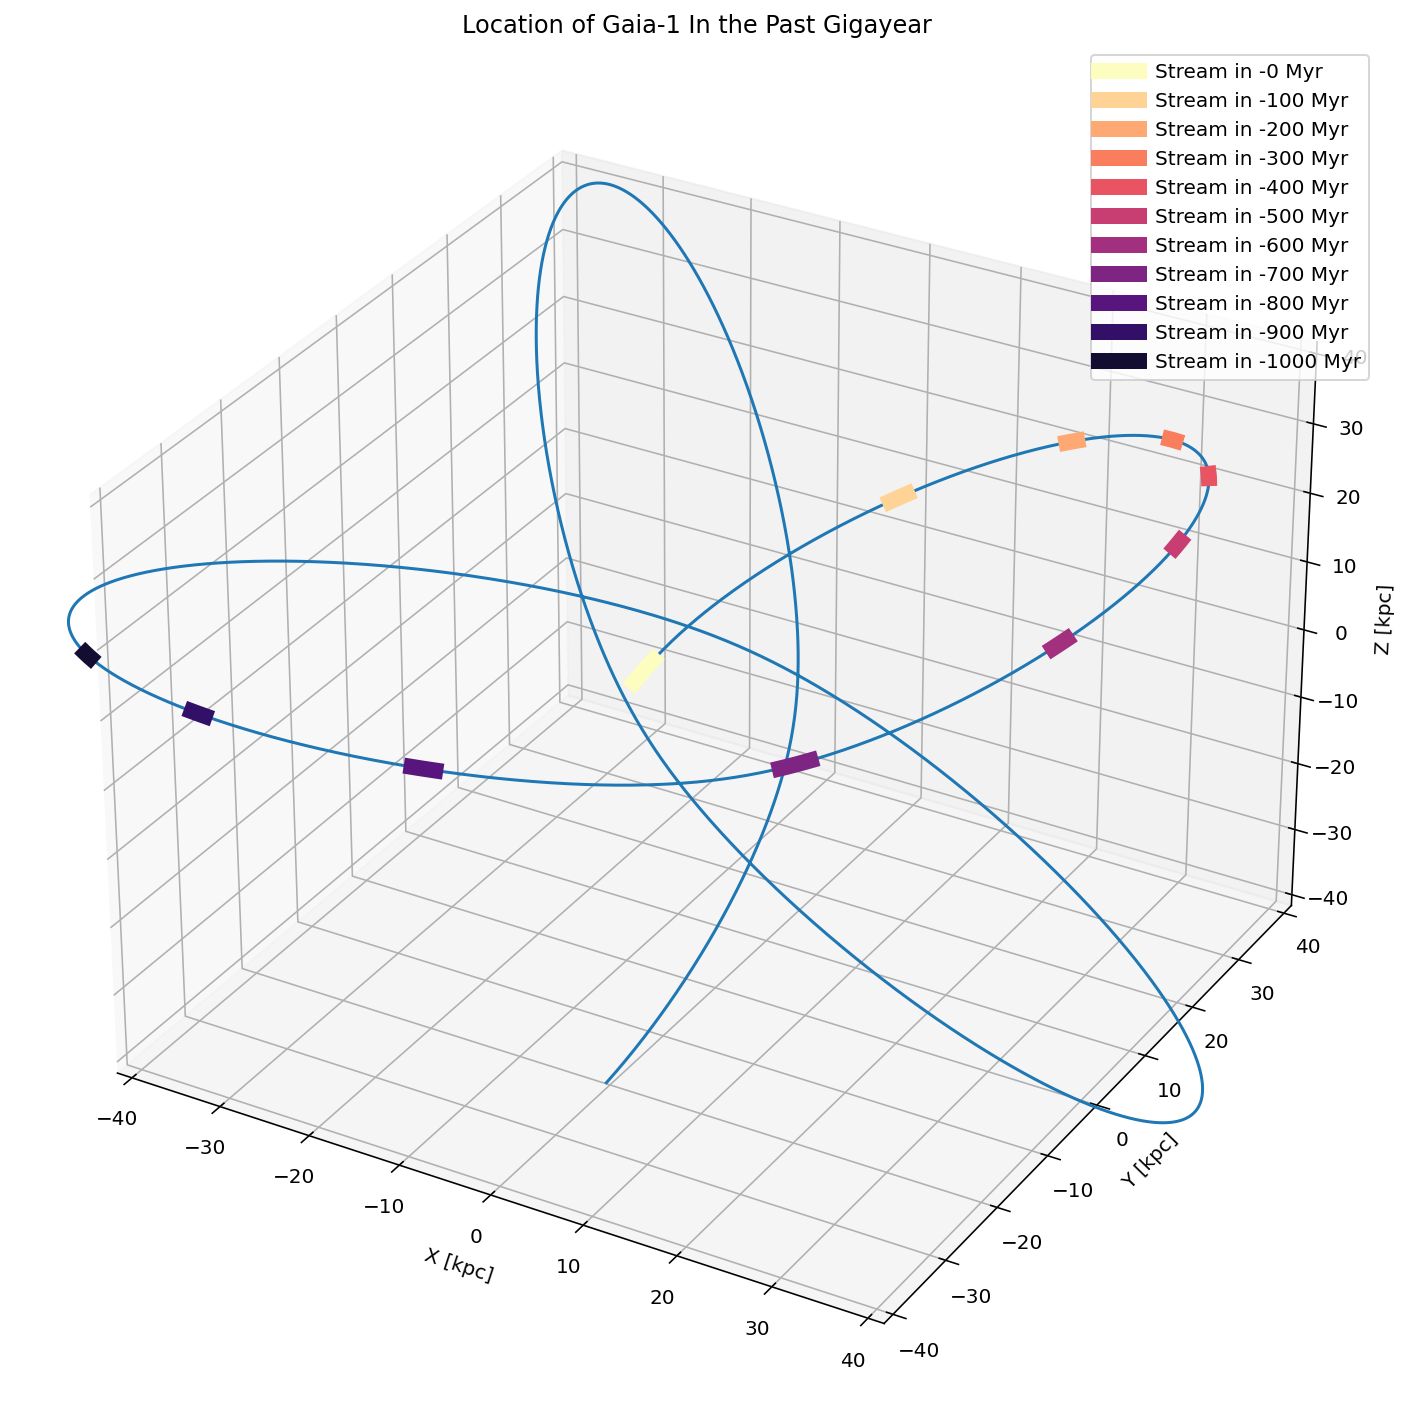

In [21]:
#%matplotlib notebook
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)

ax = plt.axes(projection='3d')

ax.plot(orbit_long.pos.x, orbit_long.pos.y, orbit_long.pos.z, '-')
ax.set_xlabel('X [kpc]')
ax.set_ylabel('Y [kpc]')
ax.set_zlabel('Z [kpc]')

#orbital segments of past positions of the stream
times = np.linspace(0,1000,11)*u.Myr

colors = [mpl.cm.magma_r(x/11) for x in range(11)] #creating a list of 11 colors 

for i, tm in enumerate(times):
    t = int((tm/dt).decompose())
    ax.plot(orbit_long.pos.x[t:t+Nstep], orbit_long.pos.y[t:t+Nstep],
             orbit_long.pos.z[t:t+Nstep], '-', lw=8, color=colors[i],
             label='Stream in {:g}'.format(-tm))
plt.legend(loc='best')
ax.set_xlim(-40,40)
ax.set_ylim(-40,40)
ax.set_zlim(-40,40)
plt.title('Location of Gaia-1 In the Past Gigayear')
plt.tight_layout()
plt.savefig('Location of Stellar Stream in the Past Gigayear', transparent=True)

#maybe use a colormap to have a smooth gradient of colors 

In [61]:
for i in range(len(pb)):
    
    #Calculating Velocity Kick 
    G = (6.6743*10**(-11))*(u.m**3/(u.kg*u.s**2)) #gravitational constant
    r_min = np.array(pb.iloc[i][1::3])*u.kpc  #smallest distance between subhalos and stream 
    v_rel = np.array(pb.iloc[i][3::3])*(u.km/u.s) #relative vel btwn strean and subhalos 
    mass_subh = (np.array(ts[ind_massive]['mvir']))*u.M_sun #mass of subhalos
    delta_v = 2*G*mass_subh/(r_min*v_rel) #start with this one 
delta_v_km_new = delta_v.to(u.km/u.s)
np.array(delta_v_km_new.value)

array([3.71357708e+01, 1.28442192e+01, 5.34036607e+00, ...,
       2.23082132e-02, 4.36499817e-03, 6.41173640e-03])

<IPython.core.display.Javascript object>


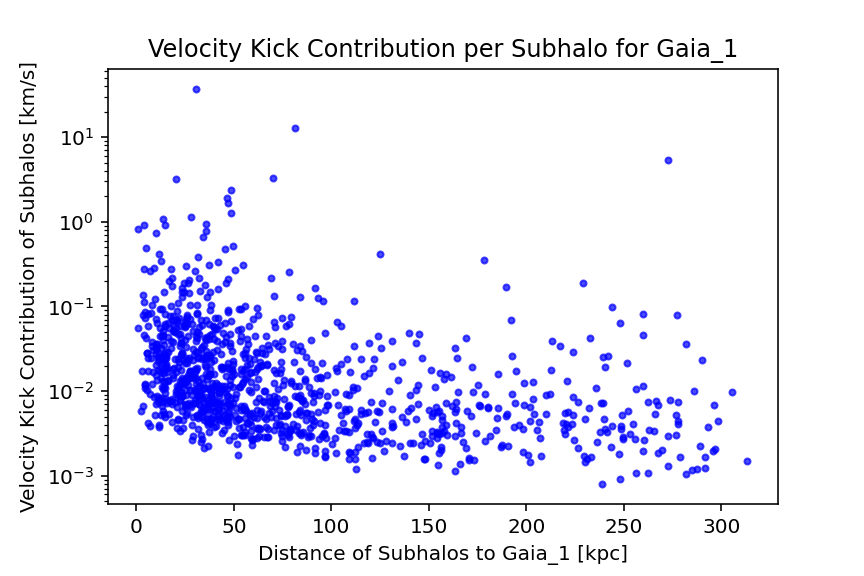

In [95]:
#dist_to_gal_center = np.sqrt((trot['x'])**2+(trot['y'])**2+(trot['z'])**2)
#want to have distance to gaia-1 vs velocity kick contribution of subhalo
plt.figure()
plt.plot(np.array(pb.iloc[4][1::3]), np.array(delta_v_km_new.value), '.', color='blue', 
         alpha=0.7, label='Subhalos')

plt.xlabel('Distance of Subhalos to Gaia_1 [kpc]')
plt.ylabel('Velocity Kick Contribution of Subhalos [km/s]')
plt.title('Velocity Kick Contribution per Subhalo for Gaia_1')
plt.yscale('log')
plt.savefig('Velocity_Kick_Contribution_per_Subhalo_for_Gaia_1.png', transparent=False, dpi=200)
#add units and label 

In [18]:
vel_kick = (np.empty(len(pb)))*(u.m**3*u.M_sun/(u.kg*u.km*u.kpc*u.s))
total_larger_1 = np.empty(len(pb))
total_larger_half = np.empty(len(pb))
total_larger_tenth = np.empty(len(pb))
for i in range(len(pb)):
    
    #Calculating Velocity Kick 
    G = (6.6743*10**(-11))*(u.m**3/(u.kg*u.s**2)) #gravitational constant
    r_min = np.array(pb.iloc[i][1::3])*u.kpc  #smallest distance between subhalos and stream 
    v_rel = np.array(pb.iloc[i][3::3])*(u.km/u.s) #relative vel btwn stream and subhalos 
    mass_subh = (np.array(ts[ind_massive]['mvir']))*u.M_sun #mass of subhalos
    delta_v = 2*G*mass_subh/(r_min*v_rel) #start with this one 
    delta_v = delta_v[1:]
    total_larger_1[i] = np.count_nonzero(delta_v.to(u.km/u.s).value>1) #getting how many have >1km/s vel kick
    total_larger_half[i] = np.count_nonzero(delta_v.to(u.km/u.s).value>0.5) #getting how many have >0.5km/s vel kick
    total_larger_tenth[i] = np.count_nonzero(delta_v.to(u.km/u.s).value>0.1)
    vel_kick_temp = np.sqrt(np.sum(delta_v**2))
    vel_kick[i] = vel_kick_temp
vel_kick.to(u.km/u.s)
#streams_copy_new['r_apo']

<Quantity [20.43422124, 19.29013644, 20.30923045, 17.3392829 , 20.21343275,
           15.69484948, 26.27382817, 19.01016498, 17.89588896, 15.52047987,
           19.74936271, 19.62048061, 17.67883422, 26.34777676, 21.43196674,
           20.77794108, 16.08873729, 19.03066768, 24.80940854, 47.02307032,
           32.80819565, 27.83562168, 23.29572301, 28.39720538, 29.12901643,
           61.20050576, 32.58060744, 17.61800518, 20.38810001, 15.47961063] km / s>

<IPython.core.display.Javascript object>


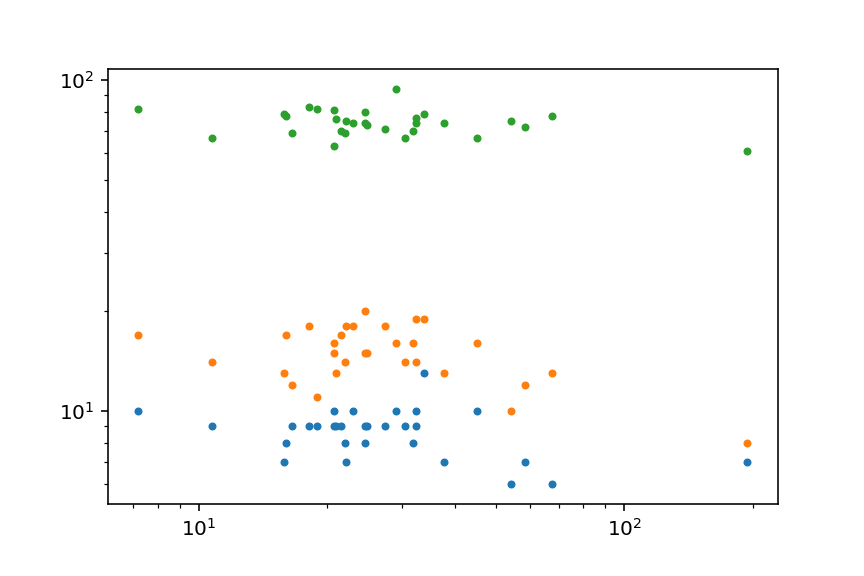

In [32]:
plt.figure()
plt.plot(np.array(streams_copy_new['r_apo']), total_larger_1, '.')
plt.plot(np.array(streams_copy_new['r_apo']), total_larger_half, '.')
plt.plot(np.array(streams_copy_new['r_apo']), total_larger_tenth, '.')
plt.xscale('log')
plt.yscale('log')

#Create len of stream vs same y axis 

In [34]:
mwsts

{'20.0-1-M18': <galstreams.Track6D at 0x7fa25a95dfd0>,
 '300S-F18': <galstreams.Track6D at 0x7fa25a9546a0>,
 'AAU-AliqaUma-L21': <galstreams.Track6D at 0x7fa24a071970>,
 'AAU-ATLAS-L21': <galstreams.Track6D at 0x7fa24a0719d0>,
 'Acheron-G09': <galstreams.Track6D at 0x7fa24a06e730>,
 'ACS-R21': <galstreams.Track6D at 0x7fa24a06ef70>,
 'Alpheus-G13': <galstreams.Track6D at 0x7fa25a95da30>,
 'Aquarius-W11': <galstreams.Track6D at 0x7fa25a95d9d0>,
 'C-19-I21': <galstreams.Track6D at 0x7fa25abf38e0>,
 'C-4-I21': <galstreams.Track6D at 0x7fa24a08adf0>,
 'C-5-I21': <galstreams.Track6D at 0x7fa25aa382b0>,
 'C-7-I21': <galstreams.Track6D at 0x7fa25a9ab370>,
 'C-8-I21': <galstreams.Track6D at 0x7fa25a9ab670>,
 'C-9-I21': <galstreams.Track6D at 0x7fa24a5009d0>,
 'Cetus-New-Y21': <galstreams.Track6D at 0x7fa25a9b7a60>,
 'Cetus-Palca-T21': <galstreams.Track6D at 0x7fa25aa92370>,
 'Cetus-Y13': <galstreams.Track6D at 0x7fa24a421c70>,
 'Cocytos-G09': <galstreams.Track6D at 0x7fa24a42dc10>,
 'Corvus-M1

In [35]:
length = dict(Gjoll=mwsts['NGC3201-P21'].length.deg, Leiptr=mwsts['Leiptr-I21'].length.deg, 
              Hrid=mwsts['Hrid-I21'].length.deg, Pal5=mwsts['Pal15-M17'].length.deg, #Pal5 has 2
              Gaia_1=mwsts['Gaia-1-I21'].length.deg, Ylgr=mwsts['Ylgr-I21'].length.deg, 
              Fjorm=mwsts['M68-P19'].length.deg, Kshir=mwsts['Kshir-I21'].length.deg, 
              Gunnthra=mwsts['Gunnthra-I21'].length.deg, Slidr=mwsts['Slidr-I21'].length.deg, 
              M92=mwsts['M92-I21'].length.deg, NGC_3201=mwsts['NGC3201-P21'].length.deg,
              Atlas=mwsts['AAU-ATLAS-L21'].length.deg, C_7=mwsts['C-7-I21'].length.deg, 
              Palca=mwsts['Palca-S18'].length.deg, Sylgr=mwsts['Sylgr-I21'].length.deg,
              Gaia_9=mwsts['Gaia-9-I21'].length.deg, Gaia_10=mwsts['Gaia-10-I21'].length.deg, 
              Gaia_12=mwsts['Gaia-12-I21'].length.deg, Indus=mwsts['Indus-S19'].length.deg, 
              Jhelum=mwsts['Jhelum-a-B19'].length.deg, Phoenix=mwsts['Phoenix-S19'].length.deg, #Jhelum has 2
              NGC5466=mwsts['NGC5466-G06'].length.deg, M5=mwsts['M5-G19'].length.deg, 
              C_20='0', C_19=mwsts['C-9-I21'].length.deg,
              Elqui=mwsts['Elqui-S19'].length.deg, AliqaUma=mwsts['AAU-AliqaUma-L21'].length.deg, 
              Phlegethon=mwsts['Phlegethon-I21'].length.deg, GD_1=mwsts['GD-1-I21'].length.deg)

In [36]:
#Read in streams_copy_new before hand
streams_copy_new['length [deg]'] = np.nan

In [37]:
streams_copy_new_updated = streams_copy_new.copy()

for i in range(len(streams_copy_new['Stream'][:])):
    streams_copy_new_updated['length [deg]'][i] = list(length.values())[i]

<ipython-input-37-6cf1d3cf1996>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streams_copy_new_updated['length [deg]'][i] = list(length.values())[i]


In [38]:
streams_copy_new_updated['length [deg]']

0     136.860661
1      70.370056
2      61.730058
3       1.469166
4      34.570252
5      44.786315
6     133.548763
7      17.393372
8      20.200567
9      33.614165
10     21.081884
11    136.860661
12     23.561687
13     24.933249
14     57.321494
15     26.164218
16     22.030526
17     17.245351
18     13.747912
19     18.222537
20     30.000486
21     11.768597
22     45.304151
23     41.394411
24      0.000000
25     20.620800
26     10.939633
27      9.677187
28     63.570210
29    102.521100
Name: length [deg], dtype: float64

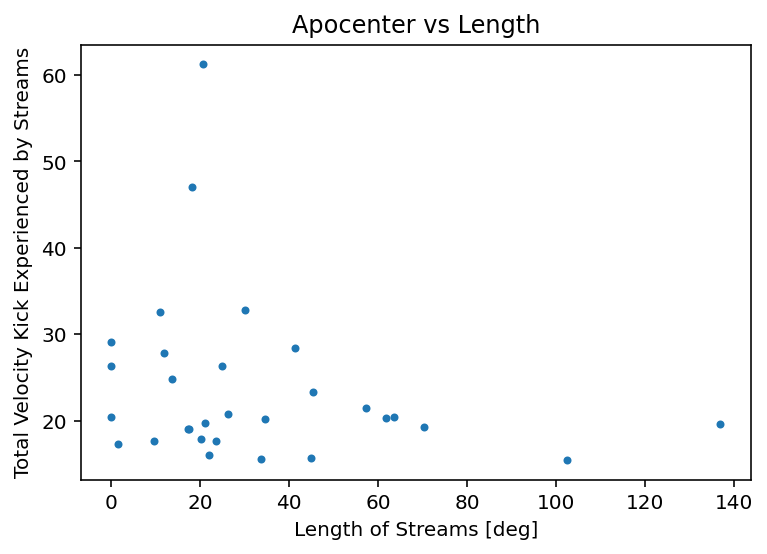

In [25]:
#X - axis apocenter & Y - axis Number of streams that give a velocity larger than 1 km/s - detectable impacts  (scatter plot)
plt.figure()
plt.plot(np.array(streams_copy_new_updated['length [deg]']), np.array(vel_kick.to(u.km/u.s)), '.')
plt.xlabel('Length of Streams [deg]')
plt.ylabel('Total Velocity Kick Experienced by Streams')
plt.title('Apocenter vs Length')
plt.savefig('Apocenter_vs_Length.png', transparent=False, dpi=200)
#For every Stream, count how many subhalos give a velocity kick larger than 1km/s (y axis)
#Do the same one for 0.5km/s 




Text(0.5, 1.0, 'Length of Streams vs Number of Kicks')

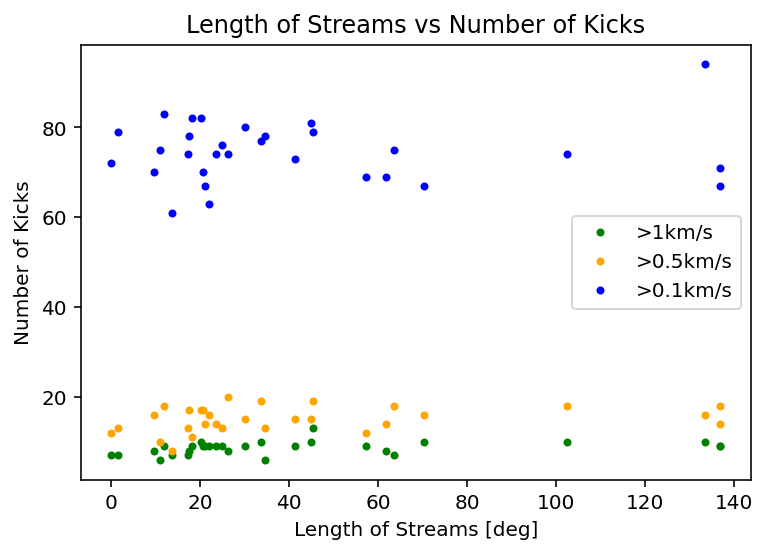

In [40]:
plt.figure()
plt.plot(np.array(streams_copy_new_updated['length [deg]']), total_larger_1, '.', color='green', label='>1km/s')
plt.plot(np.array(streams_copy_new_updated['length [deg]']), total_larger_half, '.', color='orange', label='>0.5km/s')
plt.plot(np.array(streams_copy_new_updated['length [deg]']), total_larger_tenth, '.', color='blue', label='>0.1km/s')
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Length of Streams [deg]')
plt.ylabel('Number of Kicks')
plt.legend(loc='best')
plt.title('Length of Streams vs Number of Kicks')


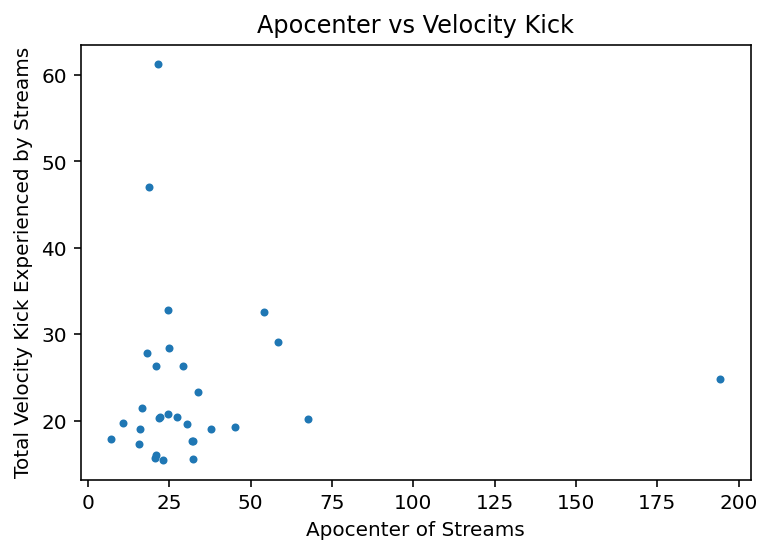

In [49]:
#X - axis apocenter & Y - axis Number of streams that give a velocity larger than 1 km/s - detectable impacts  (scatter plot)
plt.figure()
plt.plot(np.array(streams_copy_new['r_apo']), np.array(vel_kick.to(u.km/u.s)), '.')
plt.xlabel('Apocenter of Streams')
plt.ylabel('Total Velocity Kick Experienced by Streams')
plt.title('Apocenter vs Velocity Kick')
plt.savefig('Apocenter_vs_Velocity_Kick.png', transparent=False, dpi=200)
#For every Stream, count how many subhalos give a velocity kick larger than 1km/s (y axis)
#Do the same one for 0.5km/s 

In [41]:
a = np.array(vel_kick.to(u.km/u.s))
for i in range(len(a)):
    if a[i] >10:
        print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
